<a href="https://colab.research.google.com/github/tatsuhiko-suyama/Something-/blob/main/4_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ストリーミング出力は最後の 5000 行に切り捨てられました。
--- alpha = 0.503378 (3724/3935) ---
  SUCCESS. H(w*)=2.164721e-03, FW Gap=2.9453e-08, OuterIters=1
  Optimal w*: [0.0000205761, 0.0739094650, 0.9260699588]
  Gradient∇H(w*): [1.182e-03, 1.262e-03, 1.263e-03]

--- alpha = 0.503378 (3725/3935) ---
  SUCCESS. H(w*)=2.164721e-03, FW Gap=2.9455e-08, OuterIters=1
  Optimal w*: [0.0000205761, 0.0739094650, 0.9260699588]
  Gradient∇H(w*): [1.182e-03, 1.262e-03, 1.263e-03]

--- alpha = 0.503378 (3726/3935) ---
  SUCCESS. H(w*)=2.164721e-03, FW Gap=2.9458e-08, OuterIters=1
  Optimal w*: [0.0000205761, 0.0739094650, 0.9260699588]
  Gradient∇H(w*): [1.182e-03, 1.262e-03, 1.263e-03]

--- alpha = 0.503379 (3727/3935) ---
  SUCCESS. H(w*)=2.164721e-03, FW Gap=2.9460e-08, OuterIters=1
  Optimal w*: [0.0000205761, 0.0739094650, 0.9260699588]
  Gradient∇H(w*): [1.182e-03, 1.262e-03, 1.263e-03]

--- alpha = 0.503379 (3728/3935) ---
  SUCCESS. H(w*)=2.164721e-03, FW Gap=2.9463e-08, OuterIters=1
  Optimal w*: [0.0000205761,

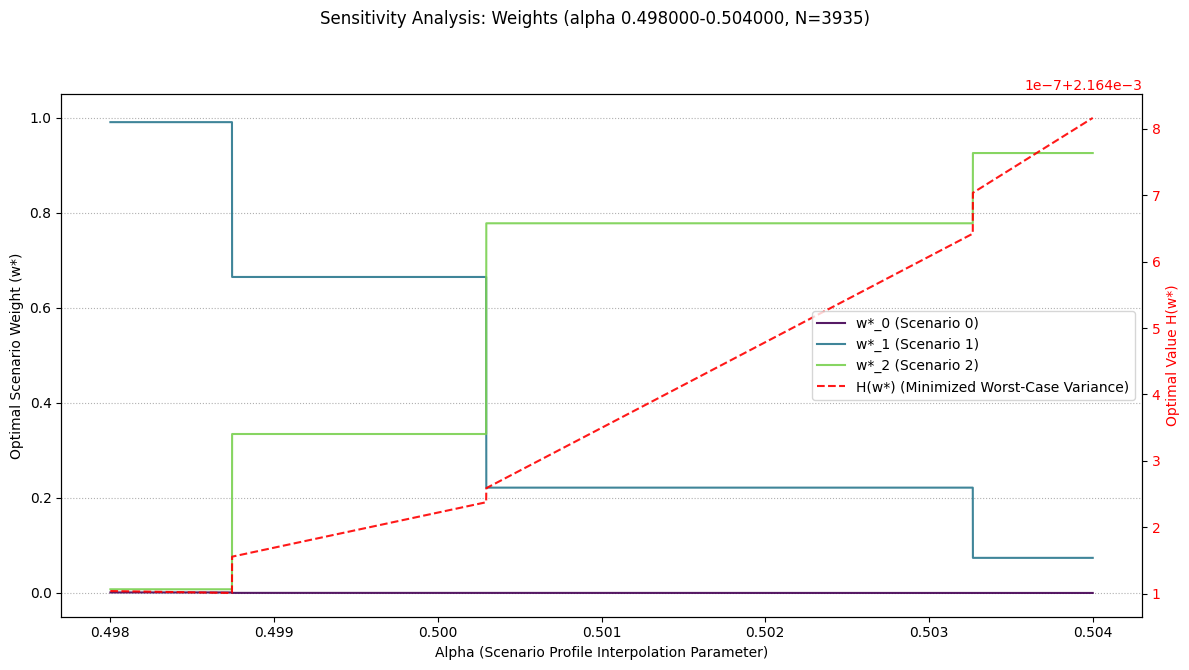


プロットする有効な結果(∇H)がありませんでした。


In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy.linalg import solve, LinAlgError, lstsq
from scipy.optimize import linprog, OptimizeWarning
import traceback
import time

# 数値許容誤差のデフォルト値
DEFAULT_TOLERANCE = 1e-9

# --- OptimizationResult クラス (変更なし) ---
class OptimizationResult:
    def __init__(self, success, message, w_opt=None, pi_opt=None, lambda_opt=None, H_opt=None, grad_H_opt=None, iterations=None, fw_gap=None):
        self.success, self.message, self.w_opt, self.pi_opt, self.lambda_opt, self.H_opt = success, message, w_opt, pi_opt, lambda_opt, H_opt
        self.grad_H_opt = grad_H_opt
        self.iterations, self.fw_gap = iterations, fw_gap

# --- find_feasible_initial_pi 関数 (変更なし) ---
def find_feasible_initial_pi(R, mu_tilde, K, tolerance=1e-8):
    M = R.shape[1]; c = np.zeros(K + 1); c[K] = 1.0
    A_ub = np.hstack((-R.T, -np.ones((M, 1)))); b_ub = -mu_tilde * np.ones(M)
    bounds = [(None, None)] * K + [(0, None)]; opts = {'tol': tolerance, 'disp': False, 'presolve': True}
    result = None; methods_to_try = ['highs', 'highs-ipm', 'highs-ds', 'simplex']
    for method in methods_to_try:
        try:
            with warnings.catch_warnings(): warnings.filterwarnings("ignore", category=OptimizeWarning)
            result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method=method, options=opts)
            if result.success: break
        except ValueError: continue
        except Exception as e: return None, False, f"Phase 1 LP failed during {method}: {e}"
    if result is None or not result.success:
        msg = result.message if result else "No solver succeeded"; status = result.status if result else -1
        return None, False, f"Phase 1 LP solver failed after trying {methods_to_try}: {msg} (last status={status})"
    s = result.x[K]; pi = result.x[:K]
    if s <= tolerance * 100:
        G = -R.T; h = -mu_tilde * np.ones(M); violation = np.max(G @ pi - h)
        if violation <= tolerance * 1000: return pi, True, f"Phase 1 OK (s*={s:.1e}, max_vio={violation:.1e})"
        else: return pi, True, f"Phase 1 OK (s*={s:.1e}), but WARNING: Max violation {violation:.1e} > tol"
    else: return None, False, f"Phase 1 Infeasible (s* = {s:.1e} > 0)."

# --- solve_kkt_system 関数 (変更なし) ---
def solve_kkt_system(Q, G_W, g, tolerance=DEFAULT_TOLERANCE):
    K = Q.shape[0]; n_act = G_W.shape[0] if G_W is not None and G_W.ndim == 2 and G_W.shape[0] > 0 else 0
    if n_act == 0:
        try: p = solve(Q, -g, assume_a='sym'); l = []
        except LinAlgError: return None, None, False
        res_norm = np.linalg.norm(Q @ p + g); g_norm = np.linalg.norm(g); solved_ok = res_norm <= tolerance * 1e2 * (1 + g_norm)
        return p, l, solved_ok
    else:
        kkt_mat = None; rhs = None
        try:
          kkt_mat = np.block([[Q, G_W.T], [G_W, np.zeros((n_act, n_act))]])
          rhs = np.concatenate([-g, np.zeros(n_act)])
        except ValueError: return None, None, False
        try: sol = solve(kkt_mat, rhs, assume_a='sym'); p, l = sol[:K], sol[K:]
        except LinAlgError: return None, None, False
        res_norm = np.linalg.norm(kkt_mat @ sol - rhs); rhs_norm = np.linalg.norm(rhs); solved_ok = res_norm <= tolerance * 1e2 * (1 + rhs_norm)
        return p, l, solved_ok

# --- solve_inner_qp_active_set 関数 (変更なし) ---
def solve_inner_qp_active_set(Vw, R, mu_tilde, initial_pi, max_iter=350, tolerance=DEFAULT_TOLERANCE, regularization_epsilon=1e-10):
    K = Vw.shape[0]; M = R.shape[1]; Q = 2 * Vw + 2 * regularization_epsilon * np.eye(K); G = -R.T; h = -mu_tilde * np.ones(M)
    if initial_pi is None: return None, None, False, "No initial pi provided."
    pi_k = np.copy(initial_pi); lam_opt = np.zeros(M); W = set()
    infeasibility = np.max(G @ pi_k - h)
    if infeasibility > tolerance * 10: warnings.warn(f"Initial pi slightly infeasible (max violation: {infeasibility:.2e}). Proceeding.", UserWarning)
    for i in range(max_iter):
        g_k = Q @ pi_k; act = sorted(list(W)); n_act = len(act); G_Wk = G[act, :] if n_act > 0 else np.empty((0, K))
        p_k, lam_Wk, solved = solve_kkt_system(Q, G_Wk, g_k, tolerance)
        if not solved or p_k is None:
            cond_Q = np.linalg.cond(Q) if K > 0 else np.nan; kkt_mat_info = f"Q cond={cond_Q:.2e}"
            if n_act > 0 and G_Wk.size > 0:
                try: kkt_mat = np.block([[Q, G_Wk.T], [G_Wk, np.zeros((n_act, n_act))]]) ;cond_kkt = np.linalg.cond(kkt_mat)
                except (LinAlgError, ValueError): cond_kkt = float('inf')
                try: svd_vals = np.linalg.svd(G_Wk, compute_uv=False); rank_tol = tolerance * max(G_Wk.shape) * svd_vals[0] if svd_vals.size > 0 else tolerance; rank_G_Wk = np.linalg.matrix_rank(G_Wk, tol=rank_tol)
                except LinAlgError: rank_G_Wk = -1
                kkt_mat_info += f", KKT cond={cond_kkt:.2e}, rank(G_Wk)={rank_G_Wk}/{n_act}"
            fail_reason = "KKT solve failed" if p_k is None else "KKT residual too large"; return None, None, False, f"QP fail:Iter {i+1}: {fail_reason} (reg={regularization_epsilon:.1e}). {kkt_mat_info}. ActiveSet={act}"
        if np.linalg.norm(p_k) <= tolerance * (1 + np.linalg.norm(pi_k)):
            is_optimal_point = True; blocking_constraint_idx = -1; min_negative_lambda = float('inf'); lambda_map = {}
            if W:
                if lam_Wk is None: return None, None, False, f"QP fail:Iter {i+1}: p_k is small but lam_Wk is None? ActiveSet={act}"
                lambda_map = dict(zip(act, lam_Wk))
                for constraint_idx, lagrange_multiplier in lambda_map.items():
                    if lagrange_multiplier < -tolerance: is_optimal_point = False;
                    if lagrange_multiplier < min_negative_lambda: min_negative_lambda = lagrange_multiplier; blocking_constraint_idx = constraint_idx
            if is_optimal_point:
                if W and len(lam_Wk) == n_act: lam_opt[act] = lam_Wk
                final_infeas = np.max(G @ pi_k - h); msg = f"Optimal found at iter {i+1} (reg={regularization_epsilon:.1e})."
                if final_infeas > tolerance * 10: msg += f" (WARN: small final violation {final_infeas:.1e})"
                return pi_k, lam_opt, True, msg
            else:
                if blocking_constraint_idx in W: W.remove(blocking_constraint_idx); continue
                else: return None, None, False, f"QP fail:Iter {i+1}: Neg lambda {min_negative_lambda:.1e} for idx {blocking_constraint_idx}, not in W={act}?"
        else:
            alpha_k = 1.0; blocking_constraint_idx = -1
            direction_threshold = tolerance * (1 + np.linalg.norm(p_k)); blocking_candidates = []
            for j in range(M):
                if j not in W:
                    constraint_gradient_dot_p = G[j, :] @ p_k
                    if constraint_gradient_dot_p > direction_threshold:
                        distance_to_boundary = h[j] - (G[j, :] @ pi_k)
                        if distance_to_boundary >= -tolerance * 10:
                            if abs(constraint_gradient_dot_p) > 1e-15:
                                alpha_j = distance_to_boundary / constraint_gradient_dot_p
                                if alpha_j >= -tolerance: blocking_candidates.append((max(0.0, alpha_j), j))
            if blocking_candidates:
                min_alpha_candidate = min(blocking_candidates, key=lambda x: x[0])
                min_step_length, constraint_to_add = min_alpha_candidate
                if min_step_length < 1.0 - tolerance: alpha_k = min_step_length; blocking_constraint_idx = constraint_to_add
            pi_k += alpha_k * p_k
            if alpha_k < 1.0 - tolerance and blocking_constraint_idx != -1:
                if blocking_constraint_idx not in W: W.add(blocking_constraint_idx)
            continue
    # Max iter reached
    msg = f"Max iter ({max_iter}) reached."; final_infeas = np.max(G @ pi_k - h)
    if final_infeas > tolerance * 100: return None, None, False, f"{msg} Final solution potentially infeasible (max violation: {final_infeas:.1e}). ActiveSet={sorted(list(W))}"
    g_k = Q @ pi_k; act=sorted(list(W)); n_act=len(act); G_Wk=G[act,:] if n_act>0 else np.empty((0,K));
    p_f, lam_f, solved_f = solve_kkt_system(Q, G_Wk, g_k, tolerance)
    final_lambda_estimate = np.zeros(M); is_likely_optimal = False
    if solved_f and p_f is not None and np.linalg.norm(p_f) <= tolerance * (1 + np.linalg.norm(pi_k)):
        if n_act > 0 and lam_f is not None and len(lam_f) == n_act: final_lambda_estimate[act] = lam_f
        active_lambdas = final_lambda_estimate[act] if n_act > 0 else np.array([])
        if n_act == 0 or np.all(active_lambdas >= -tolerance): is_likely_optimal = True; msg += " Final check suggests KKT satisfied (likely optimal)."
        else: neg_lam_indices = [idx for idx in act if final_lambda_estimate[idx] < -tolerance]; msg += f" Final check: KKT stationarity ok, but dual feasibility fails (neg lambda for {neg_lam_indices})."
    elif solved_f and p_f is not None: msg += f" Final check: KKT stationarity likely not met (||p_k||={np.linalg.norm(p_f):.1e} > tol)."
    else: msg += " Final check: KKT system solve failed at the end."
    if n_act > 0 and lam_f is not None and final_lambda_estimate is not None and len(final_lambda_estimate) == M and len(lam_f) == n_act:
        try: final_lambda_estimate[act] = lam_f
        except IndexError: pass
    return pi_k, final_lambda_estimate, is_likely_optimal, msg

# --- make_psd 関数 (変更なし) ---
def make_psd(matrix, tolerance=1e-8):
    sym = (matrix + matrix.T) / 2;
    try: eigenvalues, eigenvectors = np.linalg.eigh(sym); min_eigenvalue = np.min(eigenvalues)
    except LinAlgError: warnings.warn("make_psd: eigenvalue decomposition failed.", RuntimeWarning); return sym
    if min_eigenvalue < tolerance: eigenvalues[eigenvalues < tolerance] = tolerance; psd_matrix = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T; return (psd_matrix + psd_matrix.T) / 2
    else: return sym

# --- calculate_Vw 関数 (変更なし) ---
def calculate_Vw(w, R, SecondMomentMatrices, tolerance=DEFAULT_TOLERANCE, psd_tolerance=1e-8):
    K, M = R.shape; w_sum = np.sum(w)
    if not np.isclose(w_sum, 1.0) and w_sum > 0: w_norm = w / w_sum
    elif w_sum <= 0: w_norm = np.ones(M) / M
    else: w_norm = w
    w_norm = np.maximum(w_norm, 0); w_sum_final = np.sum(w_norm)
    if w_sum_final > 0 and not np.isclose(w_sum_final, 1.0): w_norm = w_norm / w_sum_final
    elif w_sum_final <= 0: w_norm = np.ones(M) / M
    EwX = R @ w_norm; EwXXT = np.zeros((K, K));
    for m in range(M): EwXXT += w_norm[m] * SecondMomentMatrices[m]
    Vw = EwXXT - np.outer(EwX, EwX); return make_psd(Vw, psd_tolerance), EwX, EwXXT

# --- calculate_H_gradient 関数 (変更なし) ---
def calculate_H_gradient(pi_star, w, R, SecondMomentMatrices, EwX, EwXXT, tolerance=1e-9):
    M = w.shape[0]; grad = np.zeros(M)
    if pi_star is None or np.linalg.norm(pi_star) < tolerance or EwX is None: return grad
    pi_T_EwX = pi_star.T @ EwX
    for j in range(M): grad[j] = pi_star.T @ SecondMomentMatrices[j] @ pi_star - 2 * (pi_star.T @ R[:, j]) * pi_T_EwX
    if np.any(np.isnan(grad)) or np.any(np.isinf(grad)): warnings.warn("NaN or Inf in H gradient. Returning zero vector.", RuntimeWarning); return np.zeros(M)
    return grad

# --- project_to_simplex 関数 (変更なし) ---
def project_to_simplex(v, z=1):
    n_features = v.shape[0];
    if n_features == 0: return np.array([])
    if np.all(v >= -1e-9) and np.isclose(np.sum(v), z): return np.maximum(v, 0)
    u = np.sort(v)[::-1]; cssv = np.cumsum(u) - z; ind = np.arange(n_features) + 1; cond = u - cssv / ind > 0
    if np.any(cond): rho = ind[cond][-1]; theta = cssv[rho - 1] / float(rho); w = np.maximum(v - theta, 0)
    else: w = np.zeros(n_features); w[np.argmax(v)] = z
    w_sum = np.sum(w);
    if not np.isclose(w_sum, z):
        if w_sum > 1e-9: w = w * (z / w_sum)
        else: w = np.zeros(n_features) if z == 0 else np.array([z] + [0]*(n_features-1))
    return w

# --- frank_wolfe_optimizer 関数 (変更なし) ---
def frank_wolfe_optimizer(R_alpha, SecondMomentMatrices_alpha, mu_tilde, initial_w=None, max_outer_iter=250, fw_gap_tol=1e-7, inner_max_iter=350, tolerance=1e-9, psd_make_tolerance=1e-8, qp_regularization=1e-10):
    K, M = R_alpha.shape; w_k = np.ones(M) / M if initial_w is None else project_to_simplex(np.copy(initial_w)); fw_gap = float('inf')
    best_w = np.copy(w_k); best_pi = None; best_lam = np.zeros(M); best_H = -float('inf'); final_gHk = np.zeros(M)
    pi0, ok, p1msg = find_feasible_initial_pi(R_alpha, mu_tilde, K, tolerance)
    if not ok: return OptimizationResult(False, f"Phase 1 failed: {p1msg}", w_opt=initial_w)
    for k in range(max_outer_iter):
        try: Vk, Ex, ExxT = calculate_Vw(w_k, R_alpha, SecondMomentMatrices_alpha, tolerance, psd_tolerance=psd_make_tolerance)
        except Exception as e: return OptimizationResult(False, f"Outer iter {k+1}: calculate_Vw failed: {e}\n{traceback.format_exc()}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        pk, lk, inner_ok, inner_msg = solve_inner_qp_active_set(Vk, R_alpha, mu_tilde, pi0, inner_max_iter, tolerance=tolerance, regularization_epsilon=qp_regularization)
        if not inner_ok or pk is None: return OptimizationResult(False, f"Outer iter {k+1}: Inner QP failed: {inner_msg}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        Hk = pk.T @ Vk @ pk
        try: gHk = calculate_H_gradient(pk, w_k, R_alpha, SecondMomentMatrices_alpha, Ex, ExxT, tolerance)
        except Exception as e: return OptimizationResult(False, f"Outer iter {k+1}: Gradient calculation failed: {e}\n{traceback.format_exc()}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        final_gHk = gHk
        if Hk > best_H - tolerance: best_H = Hk; best_w = np.copy(w_k); best_pi = np.copy(pk); best_lam = np.copy(lk) if lk is not None else np.zeros(M)
        sk_idx = np.argmax(gHk); sk = np.zeros(M); sk[sk_idx] = 1.0; fw_gap = gHk.T @ (sk - w_k)
        if fw_gap <= fw_gap_tol: return OptimizationResult(True, f"Converged (FW Gap={fw_gap:.2e} <= {fw_gap_tol:.1e})", w_opt=best_w, pi_opt=best_pi, lambda_opt=best_lam, H_opt=best_H, grad_H_opt=final_gHk, iterations=k + 1, fw_gap=fw_gap)
        if np.abs(fw_gap) < tolerance: return OptimizationResult(True, f"Converged (FW Gap near zero: {fw_gap:.2e})", w_opt=best_w, pi_opt=best_pi, lambda_opt=best_lam, H_opt=best_H, grad_H_opt=final_gHk, iterations=k + 1, fw_gap=fw_gap)
        if fw_gap < -tolerance: warnings.warn(f"Outer iter {k+1}: Negative FW Gap ({fw_gap:.2e}).", RuntimeWarning)
        gamma = 2.0 / (k + 3.0); w_k = (1.0 - gamma) * w_k + gamma * sk; w_k = project_to_simplex(w_k); pi0 = pk
    return OptimizationResult(True, f"Max Outer Iterations ({max_outer_iter}) reached", w_opt=best_w, pi_opt=best_pi, lambda_opt=best_lam, H_opt=best_H, grad_H_opt=final_gHk, iterations=max_outer_iter, fw_gap=fw_gap)

# --- generate_params_profile_switching 関数 (変更なし) ---
def generate_params_profile_switching(alpha, alpha_max, K=5, M=3,
    R_base=np.array([0.08, 0.07, 0.06, 0.05, 0.04]),
    sigma_base=np.array([0.18, 0.15, 0.20, 0.12, 0.10]),
    Corr_base=np.array([[1.0, 0.4, 0.3, 0.2, 0.1], [0.4, 1.0, 0.5, 0.3, 0.2], [0.3, 0.5, 1.0, 0.6, 0.4], [0.2, 0.3, 0.6, 1.0, 0.5], [0.1, 0.2, 0.4, 0.5, 1.0]]),
    good_prof_r_factor=0.05, good_prof_r_offset=0.002, good_prof_s_factor=-0.02, good_prof_corr_factor=1.0,
    bad_prof_r_factor=-0.02, bad_prof_r_offset=-0.001, bad_prof_s_factor=0.02, bad_prof_corr_offset=0.0,
    sigma_min_epsilon=1e-4, psd_tolerance=1e-9
):
    assert alpha >= 0 and K == len(R_base) and K == len(sigma_base) and K == Corr_base.shape[0] and M == 3
    non_diag_indices = np.where(~np.eye(K, dtype=bool))
    R_neutral = R_base; sigma_neutral = np.maximum(sigma_min_epsilon, sigma_base); Corr_neutral = make_psd(Corr_base, psd_tolerance)
    R_good = R_base + (R_base * good_prof_r_factor + good_prof_r_offset); sigma_good = np.maximum(sigma_min_epsilon, sigma_base + (sigma_base * good_prof_s_factor)); Corr_good_target = np.copy(Corr_base); Corr_good_target[non_diag_indices] *= good_prof_corr_factor; Corr_good = make_psd(Corr_good_target, psd_tolerance)
    R_bad = R_base + (R_base * bad_prof_r_factor + bad_prof_r_offset); sigma_bad = np.maximum(sigma_min_epsilon, sigma_base + (sigma_base * bad_prof_s_factor)); Corr_bad_target = np.copy(Corr_base); Corr_bad_target[non_diag_indices] = np.clip(Corr_bad_target[non_diag_indices] + bad_prof_corr_offset, -1.0+psd_tolerance, 1.0-psd_tolerance); Corr_bad = make_psd(Corr_bad_target, psd_tolerance)
    beta = np.clip(alpha / alpha_max if alpha_max > 0 else (1.0 if alpha > 0 else 0.0), 0.0, 1.0)
    R_alpha = np.zeros((K, M)); sigma_alpha = np.zeros((K, M)); Corr_alpha = [np.eye(K) for _ in range(M)]; Cov_alpha = [np.eye(K) for _ in range(M)]; SecondMoments_alpha = [np.eye(K) for _ in range(M)]
    R_alpha[:, 0] = (1 - beta) * R_good + beta * R_neutral; sigma_alpha[:, 0] = np.maximum(sigma_min_epsilon, (1 - beta) * sigma_good + beta * sigma_neutral); Corr_alpha[0] = make_psd((1 - beta) * Corr_good + beta * Corr_neutral, psd_tolerance)
    R_alpha[:, 1] = (1 - beta) * R_bad + beta * R_good; sigma_alpha[:, 1] = np.maximum(sigma_min_epsilon, (1 - beta) * sigma_bad + beta * sigma_good); Corr_alpha[1] = make_psd((1 - beta) * Corr_bad + beta * Corr_good, psd_tolerance)
    R_alpha[:, 2] = (1 - beta) * R_neutral + beta * R_bad; sigma_alpha[:, 2] = np.maximum(sigma_min_epsilon, (1 - beta) * sigma_neutral + beta * sigma_bad); Corr_alpha[2] = make_psd((1 - beta) * Corr_neutral + beta * Corr_bad, psd_tolerance)
    for m in range(M): sigma_diag_m = np.diag(sigma_alpha[:, m]); Cov_alpha[m] = sigma_diag_m @ Corr_alpha[m] @ sigma_diag_m; SecondMoments_alpha[m] = Cov_alpha[m] + np.outer(R_alpha[:, m], R_alpha[:, m])
    return R_alpha, SecondMoments_alpha


# --- パラメトリックスタディ実行 ---
if __name__ == '__main__':
    start_time = time.time()
    warnings.filterwarnings('ignore', category=RuntimeWarning, message=".*invalid value encountered.*")
    warnings.filterwarnings('ignore', category=UserWarning, message=".*Initial pi is slightly infeasible.*")
    warnings.filterwarnings('ignore', category=UserWarning, message=".*Solver terminated early.*")
    warnings.filterwarnings('ignore', category=UserWarning, message=".*Phase 1:.*failed.*")
    warnings.filterwarnings('ignore', category=OptimizeWarning)

    K = 5; M = 3; mu_tilde = 0.03; scenario_names = ["Scenario 0", "Scenario 1", "Scenario 2"]

    # === Alpha 値の設定 (広範囲 + 遷移点近傍の高解像度スキャン) ===
    alpha_min_wide = 0.498
    alpha_max_wide = 0.504
    n_steps_wide = 1001 # 広範囲スキャンのステップ数

    transition_points = [0.4988, 0.5003, 0.5033] # 注目する遷移点
    zoom_radius = 0.0001 # 各遷移点の近傍半径
    n_steps_zoom = 1001 # 各近傍スキャンのステップ数 (例: 1000ステップ -> 1001点)

    # 広範囲スキャンのalpha値
    alpha_values_wide = np.linspace(alpha_min_wide, alpha_max_wide, n_steps_wide)

    # 各遷移点近傍の高解像度スキャンのalpha値リスト
    alpha_values_zoom_list = []
    for center in transition_points:
        # linspaceでステップ数を指定すると点数はステップ数+1になるため注意。指定区間にnum個の点を生成する。
        # 例：1000ステップでスキャン = 1001個の点を生成
        alpha_zoom = np.linspace(center - zoom_radius, center + zoom_radius, n_steps_zoom)
        alpha_values_zoom_list.append(alpha_zoom)

    # 全てのalpha値を結合し、重複を除去してソート
    all_alpha_values = np.concatenate([alpha_values_wide] + alpha_values_zoom_list)
    alpha_values = np.unique(all_alpha_values) # 重複除去とソート
    alpha_values.sort() # 念のためソート

    alpha_max = 1.5 # 元の範囲の最大値 (これは変更しない)

    # === プロファイル作成用パラメータ (試行案6) ===
    profile_adjustments = {
        'good_prof_r_factor': 0.05,   'good_prof_r_offset': 0.002,
        'good_prof_s_factor': -0.02, 'good_prof_corr_factor': 1.0,
        'bad_prof_r_factor': -0.02, 'bad_prof_r_offset': -0.001,
        'bad_prof_s_factor': 0.02,  'bad_prof_corr_offset': 0.0,
    }
    param_gen_kwargs = {'K': K, 'M': M, 'alpha_max': alpha_max, **profile_adjustments}

    optimizer_kwargs = {'max_outer_iter': 250, 'fw_gap_tol': 1e-7, 'inner_max_iter': 400, 'tolerance': DEFAULT_TOLERANCE, 'psd_make_tolerance': 1e-8, 'qp_regularization': 1e-8}
    results_w, results_pi, results_H, results_grad_H, results_success, results_msg = [], [], [], [], [], []
    initial_w_guess = None

    print(f"パラメトリックスタディ (M={M}, K={K}, mu_tilde={mu_tilde}, Profile Switching Trial 6 - High Resolution Scan)") # タイトル更新
    print(f"alpha 範囲: {alpha_values[0]:.6f} to {alpha_values[-1]:.6f}, N={len(alpha_values)}") # 表示精度変更
    print(f"広範囲: {alpha_min_wide:.3f}-{alpha_max_wide:.3f} ({n_steps_wide} points)") # points表記に変更
    print(f"遷移点近傍ズーム (半径 {zoom_radius:.4f}, {n_steps_zoom} points/point): {transition_points}") # points表記に変更
    print(f"プロファイル調整値 (試行6): {profile_adjustments}"); print(f"Optimizer Kwargs: {optimizer_kwargs}")

    for i, alpha in enumerate(alpha_values):
        # ループ内の進捗表示 (毎回表示)
        print(f"\n--- alpha = {alpha:.6f} ({i+1}/{len(alpha_values)}) ---") # 表示精度変更

        try: R_a, SecondMoments_a = generate_params_profile_switching(alpha, **param_gen_kwargs)
        except Exception as e:
            print(f"\n  ERROR: パラメータ生成エラー: {e}\n{traceback.format_exc()}"); results_success.append(False); results_msg.append(f"Param gen error: {e}"); results_w.append(None); results_pi.append(None); results_H.append(np.nan); results_grad_H.append(None); initial_w_guess = None; continue
        try: result = frank_wolfe_optimizer(R_a, SecondMoments_a, mu_tilde, initial_w=initial_w_guess, **optimizer_kwargs)
        except Exception as e:
             print(f"\n  ERROR: frank_wolfe_optimizer で予期せぬエラー: {e}\n{traceback.format_exc()}"); results_success.append(False); results_msg.append(f"Optimizer error: {e}"); results_w.append(None); results_pi.append(None); results_H.append(np.nan); results_grad_H.append(None); initial_w_guess = None; continue

        results_success.append(result.success); results_msg.append(result.message)
        if result.success and result.w_opt is not None:
            print(f"  SUCCESS. H(w*)={result.H_opt:.6e}, FW Gap={result.fw_gap:.4e}, OuterIters={result.iterations}")
            w_disp = ", ".join([f"{w:.10f}" for w in result.w_opt])
            print(f"  Optimal w*: [{w_disp}]")
            if result.grad_H_opt is not None: grad_disp = ", ".join([f"{g:.3e}" for g in result.grad_H_opt]); print(f"  Gradient∇H(w*): [{grad_disp}]")
            else: print("  Gradient∇H(w*): [N/A]")
            results_w.append(result.w_opt); results_pi.append(result.pi_opt); results_H.append(result.H_opt); results_grad_H.append(result.grad_H_opt); initial_w_guess = result.w_opt
        else:
            print(f"  FAILED/NO SOLUTION: {result.message}"); results_w.append(None); results_pi.append(None); results_H.append(np.nan); results_grad_H.append(None); initial_w_guess = None

    end_time = time.time()
    print(f"\n計算完了。所要時間: {end_time - start_time:.2f} 秒")

    # === 結果の表示とプロット ===
    print("\n--- パラメトリックスタディ結果 (High Resolution Scan) ---") # タイトル変更
    w_headers = "|".join([f" w*_{m} ({scenario_names[m]}) ".center(19) for m in range(M)])
    grad_headers = "|".join([f"∇H_{m}  " for m in range(M)])
    header = f" alpha    | Success | {w_headers} | H(w*)    | {grad_headers} | ||pi*||_2 | Message"; print(header); print("-" * len(header)) # alphaの幅調整
    plot_alphas, valid_results_w, valid_results_H, valid_results_grad_H = [], [], [], []

    # テーブル表示 (毎回表示)
    for idx, alpha in enumerate(alpha_values):
        success = results_success[idx] if idx < len(results_success) else False
        w_res = results_w[idx] if idx < len(results_w) else None
        pi_res = results_pi[idx] if idx < len(results_pi) else None
        h_res = results_H[idx] if idx < len(results_H) else np.nan
        grad_res = results_grad_H[idx] if idx < len(results_grad_H) else None
        msg_res = results_msg[idx] if idx < len(results_msg) else "N/A"
        success_str = " OK " if success and w_res is not None else "FAIL"
        w_str = "|".join([f" {w_res[m]:17.10f} " for m in range(M)]) if w_res is not None else "|".join([" {:^19} ".format("---")] * M)
        h_str = f"{h_res:9.4e}" if h_res is not None and not np.isnan(h_res) else "   ---   "
        grad_str = "|".join([f"{grad_res[m]:7.1e}" for m in range(M)]) if grad_res is not None else "|".join([" {:^7} ".format("---")] * M)
        pi_norm_str = f"{np.linalg.norm(pi_res):9.4f}" if pi_res is not None else "   ---   "
        msg_short = (msg_res[:20] + '...') if len(msg_res) > 23 else msg_res
        print(f"{alpha:9.6f} | {success_str} |{w_str}| {h_str} |{grad_str}| {pi_norm_str} | {msg_short}") # alpha表示精度変更

        if success and w_res is not None and h_res is not None and not np.isnan(h_res) and grad_res is not None:
             plot_alphas.append(alpha); valid_results_w.append(w_res); valid_results_H.append(h_res); results_grad_H.append(valid_results_grad_H) # ★ 修正: results_grad_H.append(valid_results_grad_H) -> valid_results_grad_H.append(grad_res)


    # --- w* と H(w*) のプロット ---
    if plot_alphas and valid_results_w:
        valid_results_w_array = np.array(valid_results_w); valid_results_H_array = np.array(valid_results_H)
        fig1, ax1 = plt.subplots(figsize=(12, 7)); colors = plt.cm.viridis(np.linspace(0, 0.8, M))
        for m in range(M): ax1.plot(plot_alphas, valid_results_w_array[:, m], marker=None, linestyle='-', label=f'w*_{m} ({scenario_names[m]})', color=colors[m], alpha=0.9, linewidth=1.5)
        ax1.set_xlabel('Alpha (Scenario Profile Interpolation Parameter)'); ax1.set_ylabel('Optimal Scenario Weight (w*)', color='black'); ax1.tick_params(axis='y', labelcolor='black'); ax1.set_ylim(-0.05, 1.05); ax1.grid(True, axis='y', linestyle=':')
        ax2 = ax1.twinx(); ax2.plot(plot_alphas, valid_results_H_array, marker=None, linestyle='--', color='red', label='H(w*) (Minimized Worst-Case Variance)', alpha=0.9, linewidth=1.5)
        ax2.set_ylabel('Optimal Value H(w*)', color='red'); ax2.tick_params(axis='y', labelcolor='red')
        lines, labels = ax1.get_legend_handles_labels(); lines2, labels2 = ax2.get_legend_handles_labels(); ax2.legend(lines + lines2, labels + labels2, loc='center right')
        fig1.suptitle(f'Sensitivity Analysis: Weights (alpha {alpha_values[0]:.6f}-{alpha_values[-1]:.6f}, N={len(alpha_values)})'); fig1.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.grid(True, axis='x', linestyle=':'); plt.show() # ★ プロット表示追加
    else: print("\nプロットする有効な結果(w*, H)がありませんでした。")

    # --- 勾配 ∇H(w*) のプロット ---
    if plot_alphas and valid_results_grad_H: # ★ 修正: results_grad_H -> valid_results_grad_H
        valid_results_grad_array = np.array(valid_results_grad_H) # ★ 修正: results_grad_H -> valid_results_grad_H
        fig2, ax_grad = plt.subplots(figsize=(12, 7)); colors_grad = plt.cm.plasma(np.linspace(0, 0.8, M))
        for m in range(M): ax_grad.plot(plot_alphas, valid_results_grad_array[:, m], marker=None, linestyle='-', label=f'∇H(w*)_{m} ({scenario_names[m]})', color=colors_grad[m], alpha=0.9, linewidth=1.5)
        ax_grad.set_xlabel('Alpha (Scenario Profile Interpolation Parameter)'); ax_grad.set_ylabel('Gradient Value ∇H(w*)')
        ax_grad.set_title(f'Sensitivity Analysis: Gradient ∇H(w*) (alpha {alpha_values[0]:.6f}-{alpha_values[-1]:.6f}, N={len(alpha_values)})') # ★ 表示精度変更
        ax_grad.legend(loc='best'); ax_grad.grid(True, linestyle=':')
        fig2.tight_layout(); plt.show()
    else: print("\nプロットする有効な結果(∇H)がありませんでした。")

ストリーミング出力は最後の 5000 行に切り捨てられました。
  Gradient∇H(w*): [1.177e-03, 1.258e-03, 1.258e-03]

--- alpha = 0.503222 (2937/3935) ---
  SUCCESS. H(w*)=2.164636e-03, FW Gap=9.8285e-08, OuterIters=1
  Optimal w*: [0.0000617284, 0.2217283951, 0.7782098765]
  Gradient∇H(w*): [1.177e-03, 1.258e-03, 1.258e-03]

--- alpha = 0.503222 (2938/3935) ---
  SUCCESS. H(w*)=2.164636e-03, FW Gap=9.8293e-08, OuterIters=1
  Optimal w*: [0.0000617284, 0.2217283951, 0.7782098765]
  Gradient∇H(w*): [1.177e-03, 1.258e-03, 1.258e-03]

--- alpha = 0.503222 (2939/3935) ---
  SUCCESS. H(w*)=2.164636e-03, FW Gap=9.8300e-08, OuterIters=1
  Optimal w*: [0.0000617284, 0.2217283951, 0.7782098765]
  Gradient∇H(w*): [1.177e-03, 1.258e-03, 1.258e-03]

--- alpha = 0.503223 (2940/3935) ---
  SUCCESS. H(w*)=2.164636e-03, FW Gap=9.8308e-08, OuterIters=1
  Optimal w*: [0.0000617284, 0.2217283951, 0.7782098765]
  Gradient∇H(w*): [1.177e-03, 1.258e-03, 1.258e-03]

--- alpha = 0.503223 (2941/3935) ---
  SUCCESS. H(w*)=2.164636e-03, FW Gap=

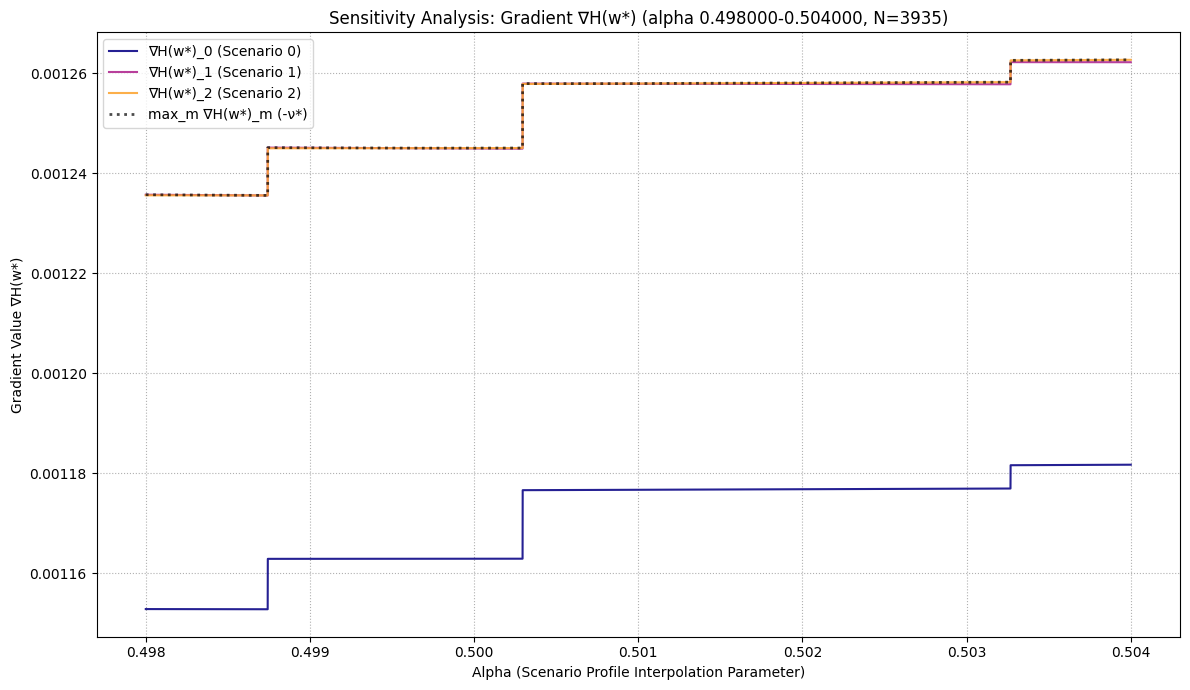

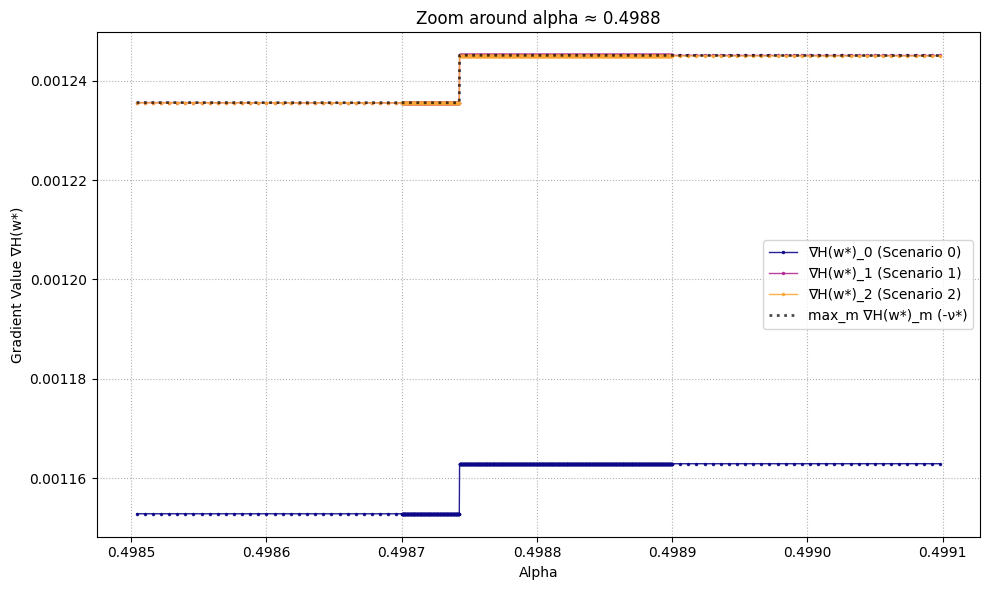

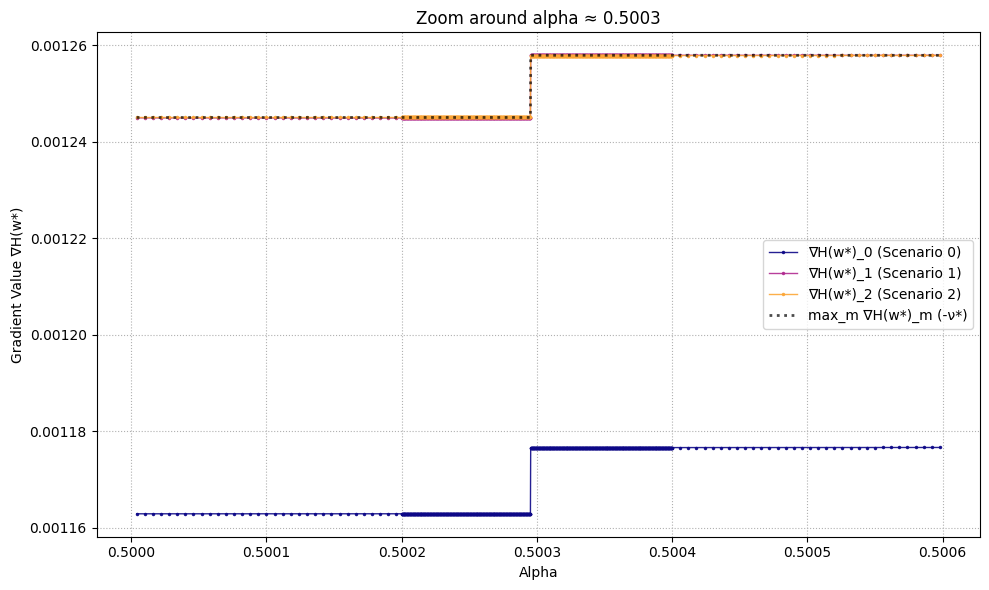

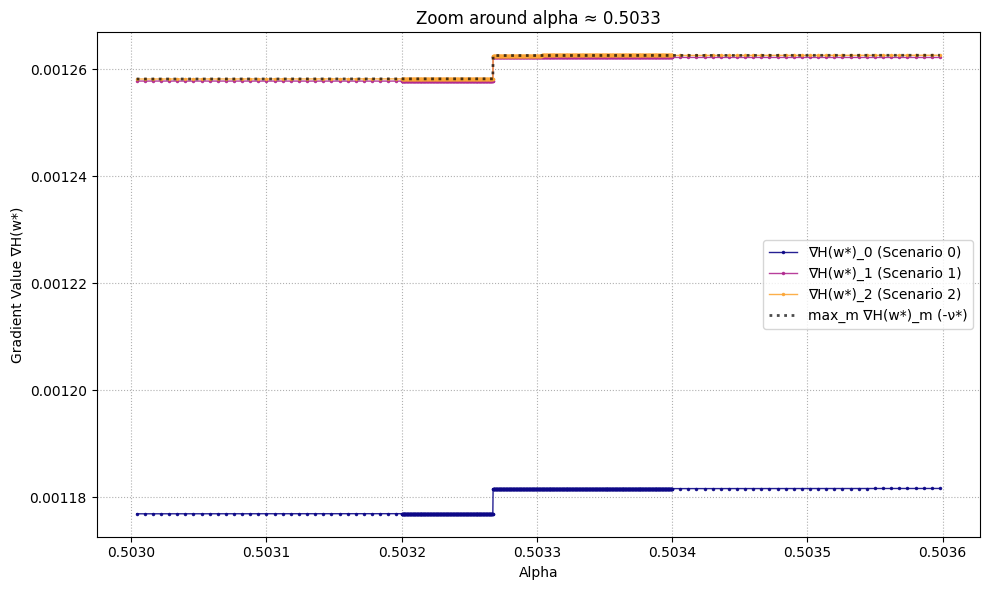

In [2]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy.linalg import solve, LinAlgError, lstsq
from scipy.optimize import linprog, OptimizeWarning
import traceback
import time

# 数値許容誤差のデフォルト値
DEFAULT_TOLERANCE = 1e-9

# --- OptimizationResult クラス (変更なし) ---
class OptimizationResult:
    def __init__(self, success, message, w_opt=None, pi_opt=None, lambda_opt=None, H_opt=None, grad_H_opt=None, iterations=None, fw_gap=None):
        self.success, self.message, self.w_opt, self.pi_opt, self.lambda_opt, self.H_opt = success, message, w_opt, pi_opt, lambda_opt, H_opt
        self.grad_H_opt = grad_H_opt
        self.iterations, self.fw_gap = iterations, fw_gap

# --- find_feasible_initial_pi 関数 (変更なし) ---
def find_feasible_initial_pi(R, mu_tilde, K, tolerance=1e-8):
    M = R.shape[1]; c = np.zeros(K + 1); c[K] = 1.0
    A_ub = np.hstack((-R.T, -np.ones((M, 1)))); b_ub = -mu_tilde * np.ones(M)
    bounds = [(None, None)] * K + [(0, None)]; opts = {'tol': tolerance, 'disp': False, 'presolve': True}
    result = None; methods_to_try = ['highs', 'highs-ipm', 'highs-ds', 'simplex']
    for method in methods_to_try:
        try:
            with warnings.catch_warnings(): warnings.filterwarnings("ignore", category=OptimizeWarning)
            result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method=method, options=opts)
            if result.success: break
        except ValueError: continue
        except Exception as e: return None, False, f"Phase 1 LP failed during {method}: {e}"
    if result is None or not result.success:
        msg = result.message if result else "No solver succeeded"; status = result.status if result else -1
        return None, False, f"Phase 1 LP solver failed after trying {methods_to_try}: {msg} (last status={status})"
    s = result.x[K]; pi = result.x[:K]
    if s <= tolerance * 100:
        G = -R.T; h = -mu_tilde * np.ones(M); violation = np.max(G @ pi - h)
        if violation <= tolerance * 1000: return pi, True, f"Phase 1 OK (s*={s:.1e}, max_vio={violation:.1e})"
        else: return pi, True, f"Phase 1 OK (s*={s:.1e}), but WARNING: Max violation {violation:.1e} > tol"
    else: return None, False, f"Phase 1 Infeasible (s* = {s:.1e} > 0)."

# --- solve_kkt_system 関数 (変更なし) ---
def solve_kkt_system(Q, G_W, g, tolerance=DEFAULT_TOLERANCE):
    K = Q.shape[0]; n_act = G_W.shape[0] if G_W is not None and G_W.ndim == 2 and G_W.shape[0] > 0 else 0
    if n_act == 0:
        try: p = solve(Q, -g, assume_a='sym'); l = []
        except LinAlgError: return None, None, False
        res_norm = np.linalg.norm(Q @ p + g); g_norm = np.linalg.norm(g); solved_ok = res_norm <= tolerance * 1e2 * (1 + g_norm)
        return p, l, solved_ok
    else:
        kkt_mat = None; rhs = None
        try:
          kkt_mat = np.block([[Q, G_W.T], [G_W, np.zeros((n_act, n_act))]])
          rhs = np.concatenate([-g, np.zeros(n_act)])
        except ValueError: return None, None, False
        try: sol = solve(kkt_mat, rhs, assume_a='sym'); p, l = sol[:K], sol[K:]
        except LinAlgError: return None, None, False
        res_norm = np.linalg.norm(kkt_mat @ sol - rhs); rhs_norm = np.linalg.norm(rhs); solved_ok = res_norm <= tolerance * 1e2 * (1 + rhs_norm)
        return p, l, solved_ok

# --- solve_inner_qp_active_set 関数 (変更なし) ---
def solve_inner_qp_active_set(Vw, R, mu_tilde, initial_pi, max_iter=350, tolerance=DEFAULT_TOLERANCE, regularization_epsilon=1e-10):
    K = Vw.shape[0]; M = R.shape[1]; Q = 2 * Vw + 2 * regularization_epsilon * np.eye(K); G = -R.T; h = -mu_tilde * np.ones(M)
    if initial_pi is None: return None, None, False, "No initial pi provided."
    pi_k = np.copy(initial_pi); lam_opt = np.zeros(M); W = set()
    infeasibility = np.max(G @ pi_k - h)
    if infeasibility > tolerance * 10: warnings.warn(f"Initial pi slightly infeasible (max violation: {infeasibility:.2e}). Proceeding.", UserWarning)
    for i in range(max_iter):
        g_k = Q @ pi_k; act = sorted(list(W)); n_act = len(act); G_Wk = G[act, :] if n_act > 0 else np.empty((0, K))
        p_k, lam_Wk, solved = solve_kkt_system(Q, G_Wk, g_k, tolerance)
        if not solved or p_k is None:
            cond_Q = np.linalg.cond(Q) if K > 0 else np.nan; kkt_mat_info = f"Q cond={cond_Q:.2e}"
            if n_act > 0 and G_Wk.size > 0:
                try: kkt_mat = np.block([[Q, G_Wk.T], [G_Wk, np.zeros((n_act, n_act))]]) ;cond_kkt = np.linalg.cond(kkt_mat)
                except (LinAlgError, ValueError): cond_kkt = float('inf')
                try: svd_vals = np.linalg.svd(G_Wk, compute_uv=False); rank_tol = tolerance * max(G_Wk.shape) * svd_vals[0] if svd_vals.size > 0 else tolerance; rank_G_Wk = np.linalg.matrix_rank(G_Wk, tol=rank_tol)
                except LinAlgError: rank_G_Wk = -1
                kkt_mat_info += f", KKT cond={cond_kkt:.2e}, rank(G_Wk)={rank_G_Wk}/{n_act}"
            fail_reason = "KKT solve failed" if p_k is None else "KKT residual too large"; return None, None, False, f"QP fail:Iter {i+1}: {fail_reason} (reg={regularization_epsilon:.1e}). {kkt_mat_info}. ActiveSet={act}"
        if np.linalg.norm(p_k) <= tolerance * (1 + np.linalg.norm(pi_k)):
            is_optimal_point = True; blocking_constraint_idx = -1; min_negative_lambda = float('inf'); lambda_map = {}
            if W:
                if lam_Wk is None: return None, None, False, f"QP fail:Iter {i+1}: p_k is small but lam_Wk is None? ActiveSet={act}"
                lambda_map = dict(zip(act, lam_Wk))
                for constraint_idx, lagrange_multiplier in lambda_map.items():
                    if lagrange_multiplier < -tolerance: is_optimal_point = False;
                    if lagrange_multiplier < min_negative_lambda: min_negative_lambda = lagrange_multiplier; blocking_constraint_idx = constraint_idx
            if is_optimal_point:
                if W and len(lam_Wk) == n_act: lam_opt[act] = lam_Wk
                final_infeas = np.max(G @ pi_k - h); msg = f"Optimal found at iter {i+1} (reg={regularization_epsilon:.1e})."
                if final_infeas > tolerance * 10: msg += f" (WARN: small final violation {final_infeas:.1e})"
                return pi_k, lam_opt, True, msg
            else:
                if blocking_constraint_idx in W: W.remove(blocking_constraint_idx); continue
                else: return None, None, False, f"QP fail:Iter {i+1}: Neg lambda {min_negative_lambda:.1e} for idx {blocking_constraint_idx}, not in W={act}?"
        else:
            alpha_k = 1.0; blocking_constraint_idx = -1
            direction_threshold = tolerance * (1 + np.linalg.norm(p_k)); blocking_candidates = []
            for j in range(M):
                if j not in W:
                    constraint_gradient_dot_p = G[j, :] @ p_k
                    if constraint_gradient_dot_p > direction_threshold:
                        distance_to_boundary = h[j] - (G[j, :] @ pi_k)
                        if distance_to_boundary >= -tolerance * 10:
                            if abs(constraint_gradient_dot_p) > 1e-15:
                                alpha_j = distance_to_boundary / constraint_gradient_dot_p
                                if alpha_j >= -tolerance: blocking_candidates.append((max(0.0, alpha_j), j))
            if blocking_candidates:
                min_alpha_candidate = min(blocking_candidates, key=lambda x: x[0])
                min_step_length, constraint_to_add = min_alpha_candidate
                if min_step_length < 1.0 - tolerance: alpha_k = min_step_length; blocking_constraint_idx = constraint_to_add
            pi_k += alpha_k * p_k
            if alpha_k < 1.0 - tolerance and blocking_constraint_idx != -1:
                if blocking_constraint_idx not in W: W.add(blocking_constraint_idx)
            continue
    # Max iter reached
    msg = f"Max iter ({max_iter}) reached."; final_infeas = np.max(G @ pi_k - h)
    if final_infeas > tolerance * 100: return None, None, False, f"{msg} Final solution potentially infeasible (max violation: {final_infeas:.1e}). ActiveSet={sorted(list(W))}"
    g_k = Q @ pi_k; act=sorted(list(W)); n_act=len(act); G_Wk=G[act,:] if n_act>0 else np.empty((0,K));
    p_f, lam_f, solved_f = solve_kkt_system(Q, G_Wk, g_k, tolerance)
    final_lambda_estimate = np.zeros(M); is_likely_optimal = False
    if solved_f and p_f is not None and np.linalg.norm(p_f) <= tolerance * (1 + np.linalg.norm(pi_k)):
        if n_act > 0 and lam_f is not None and len(lam_f) == n_act: final_lambda_estimate[act] = lam_f
        active_lambdas = final_lambda_estimate[act] if n_act > 0 else np.array([])
        if n_act == 0 or np.all(active_lambdas >= -tolerance): is_likely_optimal = True; msg += " Final check suggests KKT satisfied (likely optimal)."
        else: neg_lam_indices = [idx for idx in act if final_lambda_estimate[idx] < -tolerance]; msg += f" Final check: KKT stationarity ok, but dual feasibility fails (neg lambda for {neg_lam_indices})."
    elif solved_f and p_f is not None: msg += f" Final check: KKT stationarity likely not met (||p_k||={np.linalg.norm(p_f):.1e} > tol)."
    else: msg += " Final check: KKT system solve failed at the end."
    if n_act > 0 and lam_f is not None and final_lambda_estimate is not None and len(final_lambda_estimate) == M and len(lam_f) == n_act:
        try: final_lambda_estimate[act] = lam_f
        except IndexError: pass
    return pi_k, final_lambda_estimate, is_likely_optimal, msg

# --- make_psd 関数 (変更なし) ---
def make_psd(matrix, tolerance=1e-8):
    sym = (matrix + matrix.T) / 2;
    try: eigenvalues, eigenvectors = np.linalg.eigh(sym); min_eigenvalue = np.min(eigenvalues)
    except LinAlgError: warnings.warn("make_psd: eigenvalue decomposition failed.", RuntimeWarning); return sym
    if min_eigenvalue < tolerance: eigenvalues[eigenvalues < tolerance] = tolerance; psd_matrix = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T; return (psd_matrix + psd_matrix.T) / 2
    else: return sym

# --- calculate_Vw 関数 (変更なし) ---
def calculate_Vw(w, R, SecondMomentMatrices, tolerance=DEFAULT_TOLERANCE, psd_tolerance=1e-8):
    K, M = R.shape; w_sum = np.sum(w)
    if not np.isclose(w_sum, 1.0) and w_sum > 0: w_norm = w / w_sum
    elif w_sum <= 0: w_norm = np.ones(M) / M
    else: w_norm = w
    w_norm = np.maximum(w_norm, 0); w_sum_final = np.sum(w_norm)
    if w_sum_final > 0 and not np.isclose(w_sum_final, 1.0): w_norm = w_norm / w_sum_final
    elif w_sum_final <= 0: w_norm = np.ones(M) / M
    EwX = R @ w_norm; EwXXT = np.zeros((K, K));
    for m in range(M): EwXXT += w_norm[m] * SecondMomentMatrices[m]
    Vw = EwXXT - np.outer(EwX, EwX); return make_psd(Vw, psd_tolerance), EwX, EwXXT

# --- calculate_H_gradient 関数 (変更なし) ---
def calculate_H_gradient(pi_star, w, R, SecondMomentMatrices, EwX, EwXXT, tolerance=1e-9):
    M = w.shape[0]; grad = np.zeros(M)
    if pi_star is None or np.linalg.norm(pi_star) < tolerance or EwX is None: return grad
    pi_T_EwX = pi_star.T @ EwX
    for j in range(M): grad[j] = pi_star.T @ SecondMomentMatrices[j] @ pi_star - 2 * (pi_star.T @ R[:, j]) * pi_T_EwX
    if np.any(np.isnan(grad)) or np.any(np.isinf(grad)): warnings.warn("NaN or Inf in H gradient. Returning zero vector.", RuntimeWarning); return np.zeros(M)
    return grad

# --- project_to_simplex 関数 (変更なし) ---
def project_to_simplex(v, z=1):
    n_features = v.shape[0];
    if n_features == 0: return np.array([])
    if np.all(v >= -1e-9) and np.isclose(np.sum(v), z): return np.maximum(v, 0)
    u = np.sort(v)[::-1]; cssv = np.cumsum(u) - z; ind = np.arange(n_features) + 1; cond = u - cssv / ind > 0
    if np.any(cond): rho = ind[cond][-1]; theta = cssv[rho - 1] / float(rho); w = np.maximum(v - theta, 0)
    else: w = np.zeros(n_features); w[np.argmax(v)] = z
    w_sum = np.sum(w);
    if not np.isclose(w_sum, z):
        if w_sum > 1e-9: w = w * (z / w_sum)
        else: w = np.zeros(n_features) if z == 0 else np.array([z] + [0]*(n_features-1))
    return w

# --- frank_wolfe_optimizer 関数 (変更なし) ---
def frank_wolfe_optimizer(R_alpha, SecondMomentMatrices_alpha, mu_tilde, initial_w=None, max_outer_iter=250, fw_gap_tol=1e-7, inner_max_iter=350, tolerance=1e-9, psd_make_tolerance=1e-8, qp_regularization=1e-10):
    K, M = R_alpha.shape; w_k = np.ones(M) / M if initial_w is None else project_to_simplex(np.copy(initial_w)); fw_gap = float('inf')
    best_w = np.copy(w_k); best_pi = None; best_lam = np.zeros(M); best_H = -float('inf'); final_gHk = np.zeros(M)
    pi0, ok, p1msg = find_feasible_initial_pi(R_alpha, mu_tilde, K, tolerance)
    if not ok: return OptimizationResult(False, f"Phase 1 failed: {p1msg}", w_opt=initial_w)
    for k in range(max_outer_iter):
        try: Vk, Ex, ExxT = calculate_Vw(w_k, R_alpha, SecondMomentMatrices_alpha, tolerance, psd_tolerance=psd_make_tolerance)
        except Exception as e: return OptimizationResult(False, f"Outer iter {k+1}: calculate_Vw failed: {e}\n{traceback.format_exc()}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        pk, lk, inner_ok, inner_msg = solve_inner_qp_active_set(Vk, R_alpha, mu_tilde, pi0, inner_max_iter, tolerance=tolerance, regularization_epsilon=qp_regularization)
        if not inner_ok or pk is None: return OptimizationResult(False, f"Outer iter {k+1}: Inner QP failed: {inner_msg}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        Hk = pk.T @ Vk @ pk
        try: gHk = calculate_H_gradient(pk, w_k, R_alpha, SecondMomentMatrices_alpha, Ex, ExxT, tolerance)
        except Exception as e: return OptimizationResult(False, f"Outer iter {k+1}: Gradient calculation failed: {e}\n{traceback.format_exc()}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        final_gHk = gHk
        if Hk > best_H - tolerance: best_H = Hk; best_w = np.copy(w_k); best_pi = np.copy(pk); best_lam = np.copy(lk) if lk is not None else np.zeros(M)
        sk_idx = np.argmax(gHk); sk = np.zeros(M); sk[sk_idx] = 1.0; fw_gap = gHk.T @ (sk - w_k)
        if fw_gap <= fw_gap_tol: return OptimizationResult(True, f"Converged (FW Gap={fw_gap:.2e} <= {fw_gap_tol:.1e})", w_opt=best_w, pi_opt=best_pi, lambda_opt=best_lam, H_opt=best_H, grad_H_opt=final_gHk, iterations=k + 1, fw_gap=fw_gap)
        if np.abs(fw_gap) < tolerance: return OptimizationResult(True, f"Converged (FW Gap near zero: {fw_gap:.2e})", w_opt=best_w, pi_opt=best_pi, lambda_opt=best_lam, H_opt=best_H, grad_H_opt=final_gHk, iterations=k + 1, fw_gap=fw_gap)
        if fw_gap < -tolerance: warnings.warn(f"Outer iter {k+1}: Negative FW Gap ({fw_gap:.2e}).", RuntimeWarning)
        gamma = 2.0 / (k + 3.0); w_k = (1.0 - gamma) * w_k + gamma * sk; w_k = project_to_simplex(w_k); pi0 = pk
    return OptimizationResult(True, f"Max Outer Iterations ({max_outer_iter}) reached", w_opt=best_w, pi_opt=best_pi, lambda_opt=best_lam, H_opt=best_H, grad_H_opt=final_gHk, iterations=max_outer_iter, fw_gap=fw_gap)

# --- generate_params_profile_switching 関数 (変更なし) ---
def generate_params_profile_switching(alpha, alpha_max, K=5, M=3,
    R_base=np.array([0.08, 0.07, 0.06, 0.05, 0.04]),
    sigma_base=np.array([0.18, 0.15, 0.20, 0.12, 0.10]),
    Corr_base=np.array([[1.0, 0.4, 0.3, 0.2, 0.1], [0.4, 1.0, 0.5, 0.3, 0.2], [0.3, 0.5, 1.0, 0.6, 0.4], [0.2, 0.3, 0.6, 1.0, 0.5], [0.1, 0.2, 0.4, 0.5, 1.0]]),
    good_prof_r_factor=0.05, good_prof_r_offset=0.002, good_prof_s_factor=-0.02, good_prof_corr_factor=1.0,
    bad_prof_r_factor=-0.02, bad_prof_r_offset=-0.001, bad_prof_s_factor=0.02, bad_prof_corr_offset=0.0,
    sigma_min_epsilon=1e-4, psd_tolerance=1e-9
):
    assert alpha >= 0 and K == len(R_base) and K == len(sigma_base) and K == Corr_base.shape[0] and M == 3
    non_diag_indices = np.where(~np.eye(K, dtype=bool))
    R_neutral = R_base; sigma_neutral = np.maximum(sigma_min_epsilon, sigma_base); Corr_neutral = make_psd(Corr_base, psd_tolerance)
    R_good = R_base + (R_base * good_prof_r_factor + good_prof_r_offset); sigma_good = np.maximum(sigma_min_epsilon, sigma_base + (sigma_base * good_prof_s_factor)); Corr_good_target = np.copy(Corr_base); Corr_good_target[non_diag_indices] *= good_prof_corr_factor; Corr_good = make_psd(Corr_good_target, psd_tolerance)
    R_bad = R_base + (R_base * bad_prof_r_factor + bad_prof_r_offset); sigma_bad = np.maximum(sigma_min_epsilon, sigma_base + (sigma_base * bad_prof_s_factor)); Corr_bad_target = np.copy(Corr_base); Corr_bad_target[non_diag_indices] = np.clip(Corr_bad_target[non_diag_indices] + bad_prof_corr_offset, -1.0+psd_tolerance, 1.0-psd_tolerance); Corr_bad = make_psd(Corr_bad_target, psd_tolerance)
    beta = np.clip(alpha / alpha_max if alpha_max > 0 else (1.0 if alpha > 0 else 0.0), 0.0, 1.0)
    R_alpha = np.zeros((K, M)); sigma_alpha = np.zeros((K, M)); Corr_alpha = [np.eye(K) for _ in range(M)]; Cov_alpha = [np.eye(K) for _ in range(M)]; SecondMoments_alpha = [np.eye(K) for _ in range(M)]
    R_alpha[:, 0] = (1 - beta) * R_good + beta * R_neutral; sigma_alpha[:, 0] = np.maximum(sigma_min_epsilon, (1 - beta) * sigma_good + beta * sigma_neutral); Corr_alpha[0] = make_psd((1 - beta) * Corr_good + beta * Corr_neutral, psd_tolerance)
    R_alpha[:, 1] = (1 - beta) * R_bad + beta * R_good; sigma_alpha[:, 1] = np.maximum(sigma_min_epsilon, (1 - beta) * sigma_bad + beta * sigma_good); Corr_alpha[1] = make_psd((1 - beta) * Corr_bad + beta * Corr_good, psd_tolerance)
    R_alpha[:, 2] = (1 - beta) * R_neutral + beta * R_bad; sigma_alpha[:, 2] = np.maximum(sigma_min_epsilon, (1 - beta) * sigma_neutral + beta * sigma_bad); Corr_alpha[2] = make_psd((1 - beta) * Corr_neutral + beta * Corr_bad, psd_tolerance)
    for m in range(M): sigma_diag_m = np.diag(sigma_alpha[:, m]); Cov_alpha[m] = sigma_diag_m @ Corr_alpha[m] @ sigma_diag_m; SecondMoments_alpha[m] = Cov_alpha[m] + np.outer(R_alpha[:, m], R_alpha[:, m])
    return R_alpha, SecondMoments_alpha


# --- パラメトリックスタディ実行 ---
if __name__ == '__main__':
    start_time = time.time()
    warnings.filterwarnings('ignore', category=RuntimeWarning, message=".*invalid value encountered.*")
    warnings.filterwarnings('ignore', category=UserWarning, message=".*Initial pi is slightly infeasible.*")
    warnings.filterwarnings('ignore', category=UserWarning, message=".*Solver terminated early.*")
    warnings.filterwarnings('ignore', category=UserWarning, message=".*Phase 1:.*failed.*")
    warnings.filterwarnings('ignore', category=OptimizeWarning)

    K = 5; M = 3; mu_tilde = 0.03; scenario_names = ["Scenario 0", "Scenario 1", "Scenario 2"]

    # === Alpha 値の設定 (広範囲 + 遷移点近傍の高解像度スキャン) ===
    alpha_min_wide = 0.498
    alpha_max_wide = 0.504
    n_steps_wide = 1001 # 広範囲スキャンのステップ数

    transition_points = [0.4988, 0.5003, 0.5033] # 注目する遷移点
    zoom_radius = 0.0001 # 各遷移点の近傍半径
    n_steps_zoom = 1001 # 各近傍スキャンのステップ数 (例: 1000ステップ -> 1001点)

    # 広範囲スキャンのalpha値
    alpha_values_wide = np.linspace(alpha_min_wide, alpha_max_wide, n_steps_wide)

    # 各遷移点近傍の高解像度スキャンのalpha値リスト
    alpha_values_zoom_list = []
    for center in transition_points:
        # linspaceでステップ数を指定すると点数はステップ数+1になるため注意。指定区間にnum個の点を生成する。
        # 例：1000ステップでスキャン = 1001個の点を生成
        alpha_zoom = np.linspace(center - zoom_radius, center + zoom_radius, n_steps_zoom)
        alpha_values_zoom_list.append(alpha_zoom)

    # 全てのalpha値を結合し、重複を除去してソート
    all_alpha_values = np.concatenate([alpha_values_wide] + alpha_values_zoom_list)
    alpha_values = np.unique(all_alpha_values) # 重複除去とソート
    alpha_values.sort() # 念のためソート

    alpha_max = 1.5 # 元の範囲の最大値 (これは変更しない)

    # === プロファイル作成用パラメータ (試行案6) ===
    profile_adjustments = {
        'good_prof_r_factor': 0.05,   'good_prof_r_offset': 0.002,
        'good_prof_s_factor': -0.02, 'good_prof_corr_factor': 1.0,
        'bad_prof_r_factor': -0.02, 'bad_prof_r_offset': -0.001,
        'bad_prof_s_factor': 0.02,  'bad_prof_corr_offset': 0.0,
    }
    param_gen_kwargs = {'K': K, 'M': M, 'alpha_max': alpha_max, **profile_adjustments}

    optimizer_kwargs = {'max_outer_iter': 250, 'fw_gap_tol': 1e-7, 'inner_max_iter': 400, 'tolerance': DEFAULT_TOLERANCE, 'psd_make_tolerance': 1e-8, 'qp_regularization': 1e-8}
    results_w, results_pi, results_H, results_grad_H, results_success, results_msg = [], [], [], [], [], []
    initial_w_guess = None

    print(f"パラメトリックスタディ (M={M}, K={K}, mu_tilde={mu_tilde}, Profile Switching Trial 6 - High Resolution Scan)") # タイトル更新
    print(f"alpha 範囲: {alpha_values[0]:.6f} to {alpha_values[-1]:.6f}, N={len(alpha_values)}") # 表示精度変更
    print(f"広範囲: {alpha_min_wide:.3f}-{alpha_max_wide:.3f} ({n_steps_wide} points)") # points表記に変更
    print(f"遷移点近傍ズーム (半径 {zoom_radius:.4f}, {n_steps_zoom} points/point): {transition_points}") # points表記に変更
    print(f"プロファイル調整値 (試行6): {profile_adjustments}"); print(f"Optimizer Kwargs: {optimizer_kwargs}")

    for i, alpha in enumerate(alpha_values):
        # ループ内の進捗表示 (毎回表示)
        print(f"\n--- alpha = {alpha:.6f} ({i+1}/{len(alpha_values)}) ---") # 表示精度変更

        try: R_a, SecondMoments_a = generate_params_profile_switching(alpha, **param_gen_kwargs)
        except Exception as e:
            print(f"\n  ERROR: パラメータ生成エラー: {e}\n{traceback.format_exc()}"); results_success.append(False); results_msg.append(f"Param gen error: {e}"); results_w.append(None); results_pi.append(None); results_H.append(np.nan); results_grad_H.append(None); initial_w_guess = None; continue
        try: result = frank_wolfe_optimizer(R_a, SecondMoments_a, mu_tilde, initial_w=initial_w_guess, **optimizer_kwargs)
        except Exception as e:
             print(f"\n  ERROR: frank_wolfe_optimizer で予期せぬエラー: {e}\n{traceback.format_exc()}"); results_success.append(False); results_msg.append(f"Optimizer error: {e}"); results_w.append(None); results_pi.append(None); results_H.append(np.nan); results_grad_H.append(None); initial_w_guess = None; continue

        results_success.append(result.success); results_msg.append(result.message)
        if result.success and result.w_opt is not None:
            print(f"  SUCCESS. H(w*)={result.H_opt:.6e}, FW Gap={result.fw_gap:.4e}, OuterIters={result.iterations}")
            w_disp = ", ".join([f"{w:.10f}" for w in result.w_opt])
            print(f"  Optimal w*: [{w_disp}]")
            if result.grad_H_opt is not None: grad_disp = ", ".join([f"{g:.3e}" for g in result.grad_H_opt]); print(f"  Gradient∇H(w*): [{grad_disp}]")
            else: print("  Gradient∇H(w*): [N/A]")
            results_w.append(result.w_opt); results_pi.append(result.pi_opt); results_H.append(result.H_opt); results_grad_H.append(result.grad_H_opt); initial_w_guess = result.w_opt
        else:
            print(f"  FAILED/NO SOLUTION: {result.message}"); results_w.append(None); results_pi.append(None); results_H.append(np.nan); results_grad_H.append(None); initial_w_guess = None

    end_time = time.time()
    print(f"\n計算完了。所要時間: {end_time - start_time:.2f} 秒")

    # --- (既存コードの続き) ---

    # === 結果の表示とプロット ===
    print("\n--- パラメトリックスタディ結果 (High Resolution Scan) ---")
    # ... (テーブル表示部分は省略) ...
    plot_alphas, valid_results_w, valid_results_H, valid_results_grad_H = [], [], [], []
    for idx, alpha in enumerate(alpha_values):
        success = results_success[idx] if idx < len(results_success) else False
        w_res = results_w[idx] if idx < len(results_w) else None
        pi_res = results_pi[idx] if idx < len(results_pi) else None
        h_res = results_H[idx] if idx < len(results_H) else np.nan
        grad_res = results_grad_H[idx] if idx < len(results_grad_H) else None
        # ... (テーブル表示コード) ...

        if success and w_res is not None and h_res is not None and not np.isnan(h_res) and grad_res is not None:
             plot_alphas.append(alpha)
             valid_results_w.append(w_res)
             valid_results_H.append(h_res)
             # ★ grad_res が None でないことを確認してから格納
             if grad_res is not None:
                 valid_results_grad_H.append(grad_res)
             else:
                 # 勾配が得られなかった場合 (念のため) NaN などで埋めるか、対応する alpha を除外する
                 # ここでは NaN で埋める例 (プロット時に注意が必要)
                 valid_results_grad_H.append([np.nan] * M)


    # --- w* と H(w*) のプロット ---
    if plot_alphas and valid_results_w:
        # ... (w* と H のプロットコードは省略) ...
        # fig1.show() # または plt.show() を最後にまとめて呼ぶ
        pass # プロット表示は最後にまとめる
    else: print("\nプロットする有効な結果(w*, H)がありませんでした。")

    # --- 勾配 ∇H(w*) の詳細プロット ---
    if plot_alphas and valid_results_grad_H:
        valid_results_grad_array = np.array(valid_results_grad_H)
        # NaNが含まれている可能性があるため、マスク処理を行うか、エラーが出ないように注意
        # ここでは NaN を含む可能性のあるデータをそのままプロット試行

        fig2, ax_grad = plt.subplots(figsize=(12, 7))
        colors_grad = plt.cm.plasma(np.linspace(0, 0.8, M))

        # 各勾配成分をプロット
        for m in range(M):
            ax_grad.plot(plot_alphas, valid_results_grad_array[:, m], marker=None, linestyle='-',
                         label=f'∇H(w*)_{m} ({scenario_names[m]})', color=colors_grad[m], alpha=0.9, linewidth=1.5)

        # 最大勾配値を計算してプロット
        # np.nanmax は NaN を無視して最大値を計算する
        max_grad_values = np.nanmax(valid_results_grad_array, axis=1)
        ax_grad.plot(plot_alphas, max_grad_values, marker=None, linestyle=':', color='black',
                     label='max_m ∇H(w*)_m (-ν*)', alpha=0.7, linewidth=2)

        ax_grad.set_xlabel('Alpha (Scenario Profile Interpolation Parameter)')
        ax_grad.set_ylabel('Gradient Value ∇H(w*)')
        ax_grad.set_title(f'Sensitivity Analysis: Gradient ∇H(w*) (alpha {alpha_values[0]:.6f}-{alpha_values[-1]:.6f}, N={len(alpha_values)})')
        ax_grad.legend(loc='best')
        ax_grad.grid(True, linestyle=':')
        fig2.tight_layout()
        # fig2.show() # または plt.show() を最後にまとめて呼ぶ

        # --- 遷移点近傍の拡大図 (例: alpha ≈ 0.4988) ---
        zoom_center_1 = 0.4988
        zoom_radius_plot = 0.0003 # プロット範囲を少し広めに
        zoom_indices_1 = (np.array(plot_alphas) >= zoom_center_1 - zoom_radius_plot) & (np.array(plot_alphas) <= zoom_center_1 + zoom_radius_plot)

        if np.any(zoom_indices_1):
            fig_zoom1, ax_zoom1 = plt.subplots(figsize=(10, 6))
            for m in range(M):
                ax_zoom1.plot(np.array(plot_alphas)[zoom_indices_1], valid_results_grad_array[zoom_indices_1, m], marker='.', markersize=3, linestyle='-',
                             label=f'∇H(w*)_{m} ({scenario_names[m]})', color=colors_grad[m], alpha=0.9, linewidth=1)
            ax_zoom1.plot(np.array(plot_alphas)[zoom_indices_1], max_grad_values[zoom_indices_1], marker=None, linestyle=':', color='black',
                         label='max_m ∇H(w*)_m (-ν*)', alpha=0.7, linewidth=2)
            ax_zoom1.set_title(f'Zoom around alpha ≈ {zoom_center_1}')
            ax_zoom1.set_xlabel('Alpha'); ax_zoom1.set_ylabel('Gradient Value ∇H(w*)')
            ax_zoom1.legend(loc='best'); ax_zoom1.grid(True, linestyle=':')
            fig_zoom1.tight_layout()
            # fig_zoom1.show()

        # --- 遷移点近傍の拡大図 (例: alpha ≈ 0.5003) ---
        zoom_center_2 = 0.5003
        # zoom_radius_plot は同じ値を使用
        zoom_indices_2 = (np.array(plot_alphas) >= zoom_center_2 - zoom_radius_plot) & (np.array(plot_alphas) <= zoom_center_2 + zoom_radius_plot)

        if np.any(zoom_indices_2):
            fig_zoom2, ax_zoom2 = plt.subplots(figsize=(10, 6))
            for m in range(M):
                ax_zoom2.plot(np.array(plot_alphas)[zoom_indices_2], valid_results_grad_array[zoom_indices_2, m], marker='.', markersize=3, linestyle='-',
                             label=f'∇H(w*)_{m} ({scenario_names[m]})', color=colors_grad[m], alpha=0.9, linewidth=1)
            ax_zoom2.plot(np.array(plot_alphas)[zoom_indices_2], max_grad_values[zoom_indices_2], marker=None, linestyle=':', color='black',
                         label='max_m ∇H(w*)_m (-ν*)', alpha=0.7, linewidth=2)
            ax_zoom2.set_title(f'Zoom around alpha ≈ {zoom_center_2}')
            ax_zoom2.set_xlabel('Alpha'); ax_zoom2.set_ylabel('Gradient Value ∇H(w*)')
            ax_zoom2.legend(loc='best'); ax_zoom2.grid(True, linestyle=':')
            fig_zoom2.tight_layout()
            # fig_zoom2.show()

        # --- 遷移点近傍の拡大図 (例: alpha ≈ 0.5033) ---
        zoom_center_3 = 0.5033
        # zoom_radius_plot は同じ値を使用
        zoom_indices_3 = (np.array(plot_alphas) >= zoom_center_3 - zoom_radius_plot) & (np.array(plot_alphas) <= zoom_center_3 + zoom_radius_plot)

        if np.any(zoom_indices_3):
            fig_zoom3, ax_zoom3 = plt.subplots(figsize=(10, 6))
            for m in range(M):
                ax_zoom3.plot(np.array(plot_alphas)[zoom_indices_3], valid_results_grad_array[zoom_indices_3, m], marker='.', markersize=3, linestyle='-',
                             label=f'∇H(w*)_{m} ({scenario_names[m]})', color=colors_grad[m], alpha=0.9, linewidth=1)
            ax_zoom3.plot(np.array(plot_alphas)[zoom_indices_3], max_grad_values[zoom_indices_3], marker=None, linestyle=':', color='black',
                         label='max_m ∇H(w*)_m (-ν*)', alpha=0.7, linewidth=2)
            ax_zoom3.set_title(f'Zoom around alpha ≈ {zoom_center_3}')
            ax_zoom3.set_xlabel('Alpha'); ax_zoom3.set_ylabel('Gradient Value ∇H(w*)')
            ax_zoom3.legend(loc='best'); ax_zoom3.grid(True, linestyle=':')
            fig_zoom3.tight_layout()
            # fig_zoom3.show()

        plt.show() # 全てのプロットをまとめて表示

    else: print("\nプロットする有効な結果(∇H)がありませんでした。")

ストリーミング出力は最後の 5000 行に切り捨てられました。
  Gradient∇H(w*): [1.177e-03, 1.258e-03, 1.258e-03]

--- alpha = 0.503222 (2937/3935) ---
  SUCCESS. H(w*)=2.164636e-03, FW Gap=9.8285e-08, OuterIters=1
  Optimal w*: [0.0000617284, 0.2217283951, 0.7782098765]
  Gradient∇H(w*): [1.177e-03, 1.258e-03, 1.258e-03]

--- alpha = 0.503222 (2938/3935) ---
  SUCCESS. H(w*)=2.164636e-03, FW Gap=9.8293e-08, OuterIters=1
  Optimal w*: [0.0000617284, 0.2217283951, 0.7782098765]
  Gradient∇H(w*): [1.177e-03, 1.258e-03, 1.258e-03]

--- alpha = 0.503222 (2939/3935) ---
  SUCCESS. H(w*)=2.164636e-03, FW Gap=9.8300e-08, OuterIters=1
  Optimal w*: [0.0000617284, 0.2217283951, 0.7782098765]
  Gradient∇H(w*): [1.177e-03, 1.258e-03, 1.258e-03]

--- alpha = 0.503223 (2940/3935) ---
  SUCCESS. H(w*)=2.164636e-03, FW Gap=9.8308e-08, OuterIters=1
  Optimal w*: [0.0000617284, 0.2217283951, 0.7782098765]
  Gradient∇H(w*): [1.177e-03, 1.258e-03, 1.258e-03]

--- alpha = 0.503223 (2941/3935) ---
  SUCCESS. H(w*)=2.164636e-03, FW Gap=

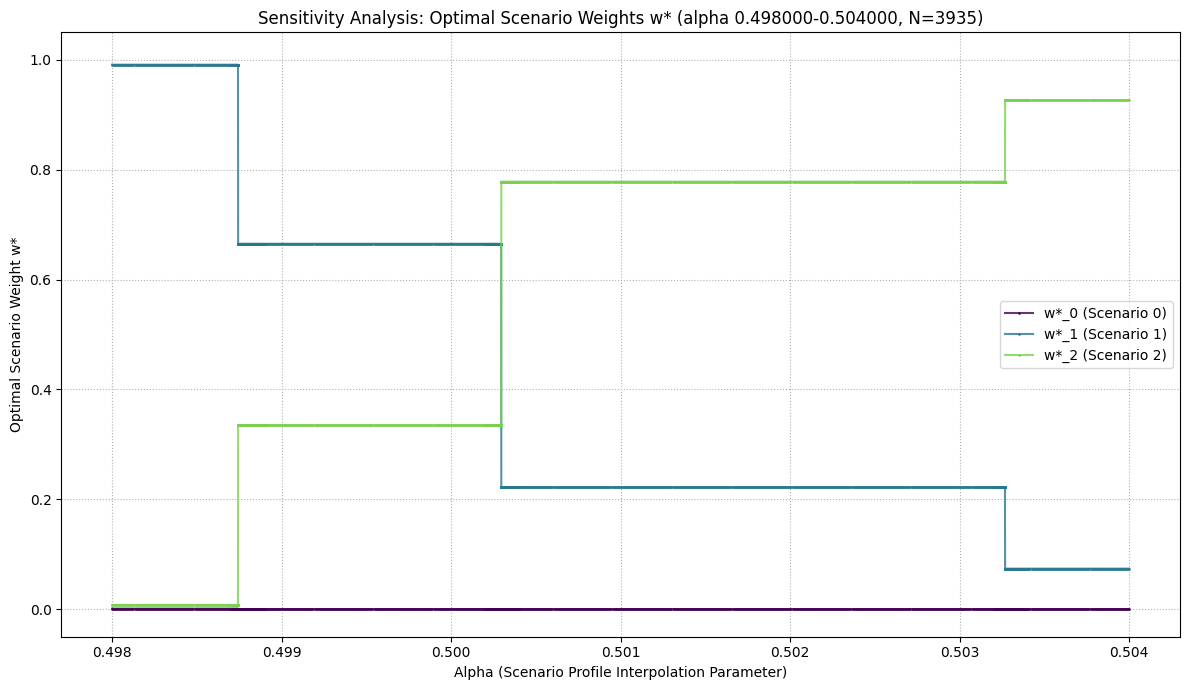

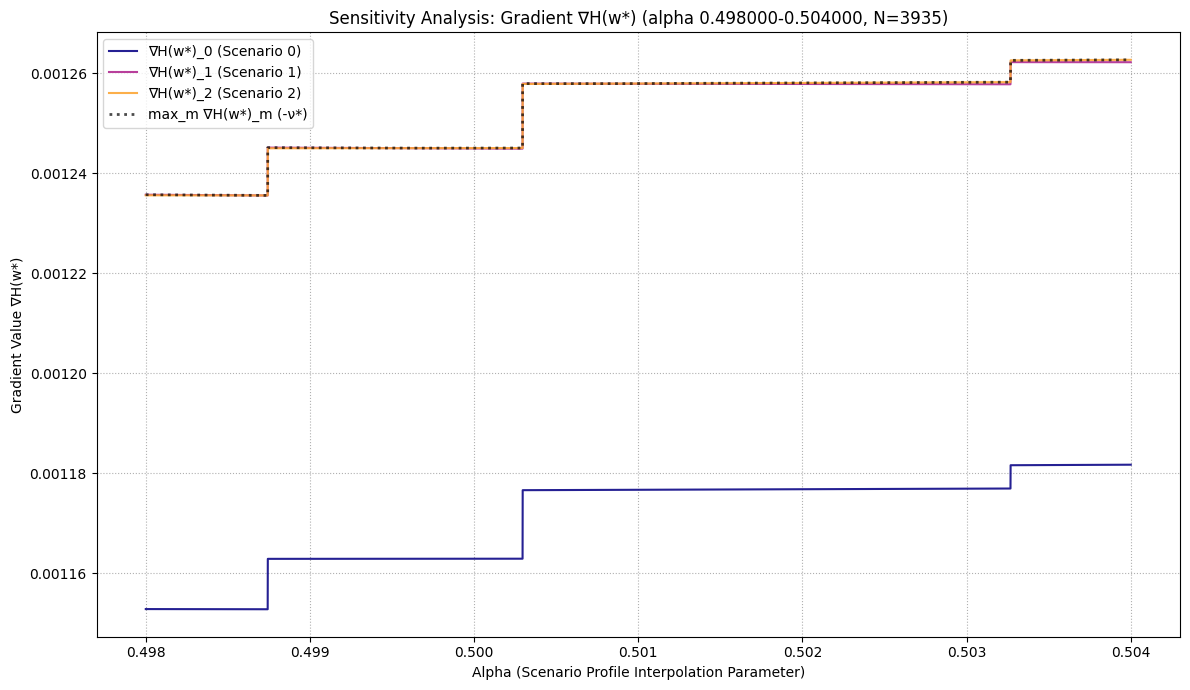

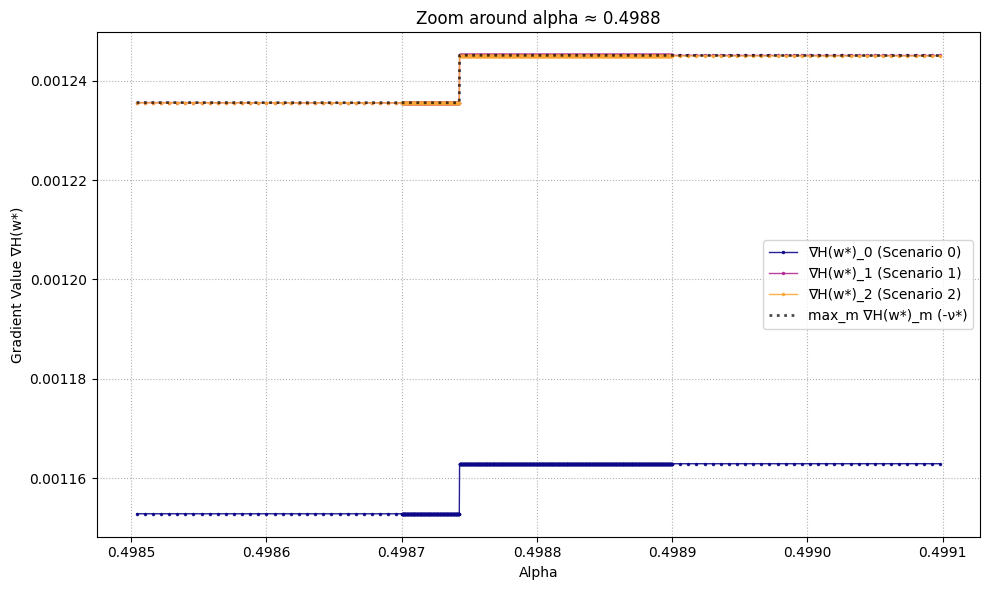

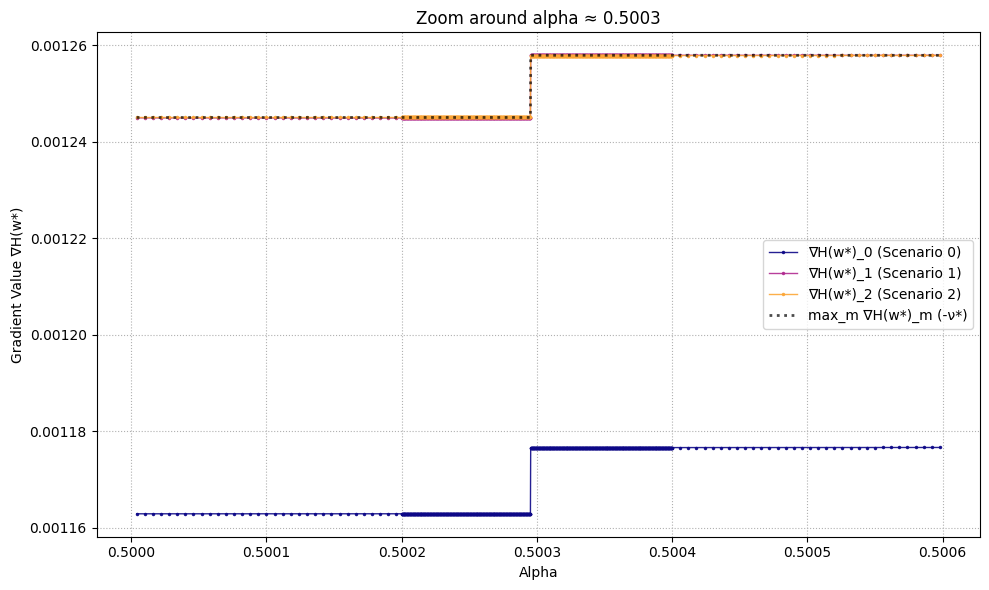

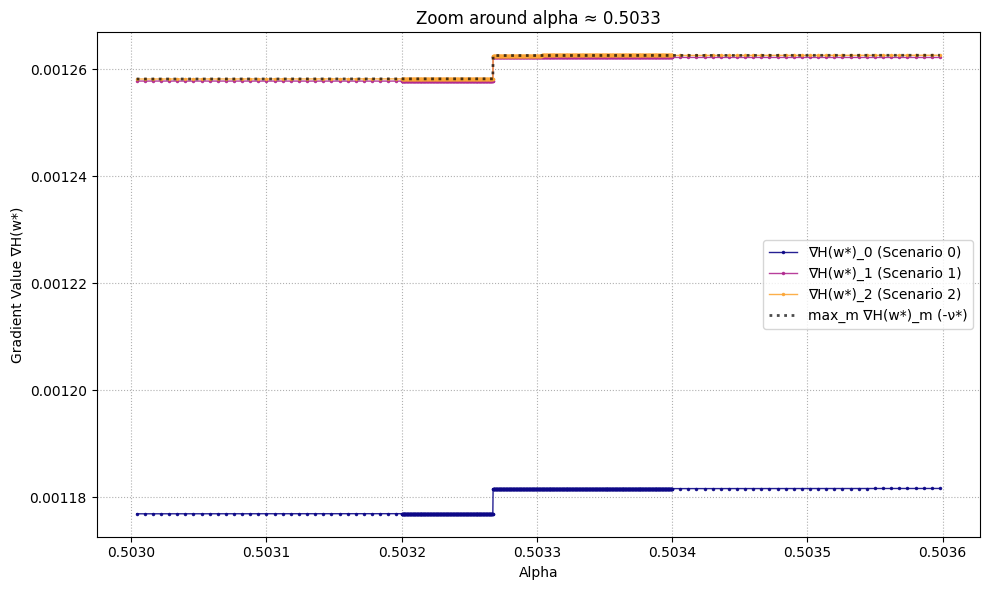

In [4]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy.linalg import solve, LinAlgError, lstsq
from scipy.optimize import linprog, OptimizeWarning
import traceback
import time

# 数値許容誤差のデフォルト値
DEFAULT_TOLERANCE = 1e-9

# --- OptimizationResult クラス ---
class OptimizationResult:
    def __init__(self, success, message, w_opt=None, pi_opt=None, lambda_opt=None, H_opt=None, grad_H_opt=None, iterations=None, fw_gap=None):
        self.success, self.message, self.w_opt, self.pi_opt, self.lambda_opt, self.H_opt = success, message, w_opt, pi_opt, lambda_opt, H_opt
        self.grad_H_opt = grad_H_opt
        self.iterations, self.fw_gap = iterations, fw_gap

# --- find_feasible_initial_pi 関数 ---
def find_feasible_initial_pi(R, mu_tilde, K, tolerance=1e-8):
    M = R.shape[1]; c = np.zeros(K + 1); c[K] = 1.0
    A_ub = np.hstack((-R.T, -np.ones((M, 1)))); b_ub = -mu_tilde * np.ones(M)
    bounds = [(None, None)] * K + [(0, None)]; opts = {'tol': tolerance, 'disp': False, 'presolve': True}
    result = None; methods_to_try = ['highs', 'highs-ipm', 'highs-ds', 'simplex']
    for method in methods_to_try:
        try:
            with warnings.catch_warnings(): warnings.filterwarnings("ignore", category=OptimizeWarning)
            result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method=method, options=opts)
            if result.success: break
        except ValueError: continue
        except Exception as e: return None, False, f"Phase 1 LP failed during {method}: {e}"
    if result is None or not result.success:
        msg = result.message if result else "No solver succeeded"; status = result.status if result else -1
        return None, False, f"Phase 1 LP solver failed after trying {methods_to_try}: {msg} (last status={status})"
    s = result.x[K]; pi = result.x[:K]
    if s <= tolerance * 100:
        G = -R.T; h = -mu_tilde * np.ones(M); violation = np.max(G @ pi - h)
        if violation <= tolerance * 1000: return pi, True, f"Phase 1 OK (s*={s:.1e}, max_vio={violation:.1e})"
        else: return pi, True, f"Phase 1 OK (s*={s:.1e}), but WARNING: Max violation {violation:.1e} > tol"
    else: return None, False, f"Phase 1 Infeasible (s* = {s:.1e} > 0)."

# --- solve_kkt_system 関数 ---
def solve_kkt_system(Q, G_W, g, tolerance=DEFAULT_TOLERANCE):
    K = Q.shape[0]; n_act = G_W.shape[0] if G_W is not None and G_W.ndim == 2 and G_W.shape[0] > 0 else 0
    if n_act == 0:
        try: p = solve(Q, -g, assume_a='sym'); l = []
        except LinAlgError: return None, None, False
        res_norm = np.linalg.norm(Q @ p + g); g_norm = np.linalg.norm(g); solved_ok = res_norm <= tolerance * 1e2 * (1 + g_norm)
        return p, l, solved_ok
    else:
        kkt_mat = None; rhs = None
        try:
          kkt_mat = np.block([[Q, G_W.T], [G_W, np.zeros((n_act, n_act))]])
          rhs = np.concatenate([-g, np.zeros(n_act)])
        except ValueError: return None, None, False
        try: sol = solve(kkt_mat, rhs, assume_a='sym'); p, l = sol[:K], sol[K:]
        except LinAlgError: return None, None, False
        res_norm = np.linalg.norm(kkt_mat @ sol - rhs); rhs_norm = np.linalg.norm(rhs); solved_ok = res_norm <= tolerance * 1e2 * (1 + rhs_norm)
        return p, l, solved_ok

# --- solve_inner_qp_active_set 関数 ---
def solve_inner_qp_active_set(Vw, R, mu_tilde, initial_pi, max_iter=350, tolerance=DEFAULT_TOLERANCE, regularization_epsilon=1e-10):
    K = Vw.shape[0]; M = R.shape[1]; Q = 2 * Vw + 2 * regularization_epsilon * np.eye(K); G = -R.T; h = -mu_tilde * np.ones(M)
    if initial_pi is None: return None, None, False, "No initial pi provided."
    pi_k = np.copy(initial_pi); lam_opt = np.zeros(M); W = set()
    infeasibility = np.max(G @ pi_k - h)
    if infeasibility > tolerance * 10: warnings.warn(f"Initial pi slightly infeasible (max violation: {infeasibility:.2e}). Proceeding.", UserWarning)
    for i in range(max_iter):
        g_k = Q @ pi_k; act = sorted(list(W)); n_act = len(act); G_Wk = G[act, :] if n_act > 0 else np.empty((0, K))
        p_k, lam_Wk, solved = solve_kkt_system(Q, G_Wk, g_k, tolerance)
        if not solved or p_k is None:
            cond_Q = np.linalg.cond(Q) if K > 0 else np.nan; kkt_mat_info = f"Q cond={cond_Q:.2e}"
            if n_act > 0 and G_Wk.size > 0:
                try: kkt_mat = np.block([[Q, G_Wk.T], [G_Wk, np.zeros((n_act, n_act))]]) ;cond_kkt = np.linalg.cond(kkt_mat)
                except (LinAlgError, ValueError): cond_kkt = float('inf')
                try: svd_vals = np.linalg.svd(G_Wk, compute_uv=False); rank_tol = tolerance * max(G_Wk.shape) * svd_vals[0] if svd_vals.size > 0 else tolerance; rank_G_Wk = np.linalg.matrix_rank(G_Wk, tol=rank_tol)
                except LinAlgError: rank_G_Wk = -1
                kkt_mat_info += f", KKT cond={cond_kkt:.2e}, rank(G_Wk)={rank_G_Wk}/{n_act}"
            fail_reason = "KKT solve failed" if p_k is None else "KKT residual too large"; return None, None, False, f"QP fail:Iter {i+1}: {fail_reason} (reg={regularization_epsilon:.1e}). {kkt_mat_info}. ActiveSet={act}"
        if np.linalg.norm(p_k) <= tolerance * (1 + np.linalg.norm(pi_k)):
            is_optimal_point = True; blocking_constraint_idx = -1; min_negative_lambda = float('inf'); lambda_map = {}
            if W:
                if lam_Wk is None: return None, None, False, f"QP fail:Iter {i+1}: p_k is small but lam_Wk is None? ActiveSet={act}"
                lambda_map = dict(zip(act, lam_Wk))
                for constraint_idx, lagrange_multiplier in lambda_map.items():
                    if lagrange_multiplier < -tolerance: is_optimal_point = False;
                    if lagrange_multiplier < min_negative_lambda: min_negative_lambda = lagrange_multiplier; blocking_constraint_idx = constraint_idx
            if is_optimal_point:
                if W and len(lam_Wk) == n_act: lam_opt[act] = lam_Wk
                final_infeas = np.max(G @ pi_k - h); msg = f"Optimal found at iter {i+1} (reg={regularization_epsilon:.1e})."
                if final_infeas > tolerance * 10: msg += f" (WARN: small final violation {final_infeas:.1e})"
                return pi_k, lam_opt, True, msg
            else:
                if blocking_constraint_idx in W: W.remove(blocking_constraint_idx); continue
                else: return None, None, False, f"QP fail:Iter {i+1}: Neg lambda {min_negative_lambda:.1e} for idx {blocking_constraint_idx}, not in W={act}?"
        else:
            alpha_k = 1.0; blocking_constraint_idx = -1
            direction_threshold = tolerance * (1 + np.linalg.norm(p_k)); blocking_candidates = []
            for j in range(M):
                if j not in W:
                    constraint_gradient_dot_p = G[j, :] @ p_k
                    if constraint_gradient_dot_p > direction_threshold:
                        distance_to_boundary = h[j] - (G[j, :] @ pi_k)
                        if distance_to_boundary >= -tolerance * 10:
                            if abs(constraint_gradient_dot_p) > 1e-15:
                                alpha_j = distance_to_boundary / constraint_gradient_dot_p
                                if alpha_j >= -tolerance: blocking_candidates.append((max(0.0, alpha_j), j))
            if blocking_candidates:
                min_alpha_candidate = min(blocking_candidates, key=lambda x: x[0])
                min_step_length, constraint_to_add = min_alpha_candidate
                if min_step_length < 1.0 - tolerance: alpha_k = min_step_length; blocking_constraint_idx = constraint_to_add
            pi_k += alpha_k * p_k
            if alpha_k < 1.0 - tolerance and blocking_constraint_idx != -1:
                if blocking_constraint_idx not in W: W.add(blocking_constraint_idx)
            continue
    # Max iter reached
    msg = f"Max iter ({max_iter}) reached."; final_infeas = np.max(G @ pi_k - h)
    if final_infeas > tolerance * 100: return None, None, False, f"{msg} Final solution potentially infeasible (max violation: {final_infeas:.1e}). ActiveSet={sorted(list(W))}"
    g_k = Q @ pi_k; act=sorted(list(W)); n_act=len(act); G_Wk=G[act,:] if n_act>0 else np.empty((0,K));
    p_f, lam_f, solved_f = solve_kkt_system(Q, G_Wk, g_k, tolerance)
    final_lambda_estimate = np.zeros(M); is_likely_optimal = False
    if solved_f and p_f is not None and np.linalg.norm(p_f) <= tolerance * (1 + np.linalg.norm(pi_k)):
        if n_act > 0 and lam_f is not None and len(lam_f) == n_act: final_lambda_estimate[act] = lam_f
        active_lambdas = final_lambda_estimate[act] if n_act > 0 else np.array([])
        if n_act == 0 or np.all(active_lambdas >= -tolerance): is_likely_optimal = True; msg += " Final check suggests KKT satisfied (likely optimal)."
        else: neg_lam_indices = [idx for idx in act if final_lambda_estimate[idx] < -tolerance]; msg += f" Final check: KKT stationarity ok, but dual feasibility fails (neg lambda for {neg_lam_indices})."
    elif solved_f and p_f is not None: msg += f" Final check: KKT stationarity likely not met (||p_k||={np.linalg.norm(p_f):.1e} > tol)."
    else: msg += " Final check: KKT system solve failed at the end."
    if n_act > 0 and lam_f is not None and final_lambda_estimate is not None and len(final_lambda_estimate) == M and len(lam_f) == n_act:
        try: final_lambda_estimate[act] = lam_f
        except IndexError: pass
    return pi_k, final_lambda_estimate, is_likely_optimal, msg

# --- make_psd 関数 ---
def make_psd(matrix, tolerance=1e-8):
    sym = (matrix + matrix.T) / 2;
    try: eigenvalues, eigenvectors = np.linalg.eigh(sym); min_eigenvalue = np.min(eigenvalues)
    except LinAlgError: warnings.warn("make_psd: eigenvalue decomposition failed.", RuntimeWarning); return sym
    if min_eigenvalue < tolerance: eigenvalues[eigenvalues < tolerance] = tolerance; psd_matrix = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T; return (psd_matrix + psd_matrix.T) / 2
    else: return sym

# --- calculate_Vw 関数 ---
def calculate_Vw(w, R, SecondMomentMatrices, tolerance=DEFAULT_TOLERANCE, psd_tolerance=1e-8):
    K, M = R.shape; w_sum = np.sum(w)
    if not np.isclose(w_sum, 1.0) and w_sum > 0: w_norm = w / w_sum
    elif w_sum <= 0: w_norm = np.ones(M) / M
    else: w_norm = w
    w_norm = np.maximum(w_norm, 0); w_sum_final = np.sum(w_norm)
    if w_sum_final > 0 and not np.isclose(w_sum_final, 1.0): w_norm = w_norm / w_sum_final
    elif w_sum_final <= 0: w_norm = np.ones(M) / M
    EwX = R @ w_norm; EwXXT = np.zeros((K, K));
    for m in range(M): EwXXT += w_norm[m] * SecondMomentMatrices[m]
    Vw = EwXXT - np.outer(EwX, EwX); return make_psd(Vw, psd_tolerance), EwX, EwXXT

# --- calculate_H_gradient 関数 ---
def calculate_H_gradient(pi_star, w, R, SecondMomentMatrices, EwX, EwXXT, tolerance=1e-9):
    M = w.shape[0]; grad = np.zeros(M)
    if pi_star is None or np.linalg.norm(pi_star) < tolerance or EwX is None: return grad
    pi_T_EwX = pi_star.T @ EwX
    for j in range(M): grad[j] = pi_star.T @ SecondMomentMatrices[j] @ pi_star - 2 * (pi_star.T @ R[:, j]) * pi_T_EwX
    if np.any(np.isnan(grad)) or np.any(np.isinf(grad)): warnings.warn("NaN or Inf in H gradient. Returning zero vector.", RuntimeWarning); return np.zeros(M)
    return grad

# --- project_to_simplex 関数 ---
def project_to_simplex(v, z=1):
    n_features = v.shape[0];
    if n_features == 0: return np.array([])
    if np.all(v >= -1e-9) and np.isclose(np.sum(v), z): return np.maximum(v, 0)
    u = np.sort(v)[::-1]; cssv = np.cumsum(u) - z; ind = np.arange(n_features) + 1; cond = u - cssv / ind > 0
    if np.any(cond): rho = ind[cond][-1]; theta = cssv[rho - 1] / float(rho); w = np.maximum(v - theta, 0)
    else: w = np.zeros(n_features); w[np.argmax(v)] = z
    w_sum = np.sum(w);
    if not np.isclose(w_sum, z):
        if w_sum > 1e-9: w = w * (z / w_sum)
        else: w = np.zeros(n_features) if z == 0 else np.array([z] + [0]*(n_features-1))
    return w

# --- frank_wolfe_optimizer 関数 ---
def frank_wolfe_optimizer(R_alpha, SecondMomentMatrices_alpha, mu_tilde, initial_w=None, max_outer_iter=250, fw_gap_tol=1e-7, inner_max_iter=350, tolerance=1e-9, psd_make_tolerance=1e-8, qp_regularization=1e-10):
    K, M = R_alpha.shape; w_k = np.ones(M) / M if initial_w is None else project_to_simplex(np.copy(initial_w)); fw_gap = float('inf')
    best_w = np.copy(w_k); best_pi = None; best_lam = np.zeros(M); best_H = -float('inf'); final_gHk = np.zeros(M)
    pi0, ok, p1msg = find_feasible_initial_pi(R_alpha, mu_tilde, K, tolerance)
    if not ok: return OptimizationResult(False, f"Phase 1 failed: {p1msg}", w_opt=initial_w)
    for k in range(max_outer_iter):
        try: Vk, Ex, ExxT = calculate_Vw(w_k, R_alpha, SecondMomentMatrices_alpha, tolerance, psd_tolerance=psd_make_tolerance)
        except Exception as e: return OptimizationResult(False, f"Outer iter {k+1}: calculate_Vw failed: {e}\n{traceback.format_exc()}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        pk, lk, inner_ok, inner_msg = solve_inner_qp_active_set(Vk, R_alpha, mu_tilde, pi0, inner_max_iter, tolerance=tolerance, regularization_epsilon=qp_regularization)
        if not inner_ok or pk is None: return OptimizationResult(False, f"Outer iter {k+1}: Inner QP failed: {inner_msg}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        Hk = pk.T @ Vk @ pk
        try: gHk = calculate_H_gradient(pk, w_k, R_alpha, SecondMomentMatrices_alpha, Ex, ExxT, tolerance)
        except Exception as e: return OptimizationResult(False, f"Outer iter {k+1}: Gradient calculation failed: {e}\n{traceback.format_exc()}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        final_gHk = gHk
        if Hk > best_H - tolerance: best_H = Hk; best_w = np.copy(w_k); best_pi = np.copy(pk); best_lam = np.copy(lk) if lk is not None else np.zeros(M)
        sk_idx = np.argmax(gHk); sk = np.zeros(M); sk[sk_idx] = 1.0; fw_gap = gHk.T @ (sk - w_k)
        if fw_gap <= fw_gap_tol: return OptimizationResult(True, f"Converged (FW Gap={fw_gap:.2e} <= {fw_gap_tol:.1e})", w_opt=best_w, pi_opt=best_pi, lambda_opt=best_lam, H_opt=best_H, grad_H_opt=final_gHk, iterations=k + 1, fw_gap=fw_gap)
        if np.abs(fw_gap) < tolerance: return OptimizationResult(True, f"Converged (FW Gap near zero: {fw_gap:.2e})", w_opt=best_w, pi_opt=best_pi, lambda_opt=best_lam, H_opt=best_H, grad_H_opt=final_gHk, iterations=k + 1, fw_gap=fw_gap)
        if fw_gap < -tolerance: warnings.warn(f"Outer iter {k+1}: Negative FW Gap ({fw_gap:.2e}).", RuntimeWarning)
        gamma = 2.0 / (k + 3.0); w_k = (1.0 - gamma) * w_k + gamma * sk; w_k = project_to_simplex(w_k); pi0 = pk
    return OptimizationResult(True, f"Max Outer Iterations ({max_outer_iter}) reached", w_opt=best_w, pi_opt=best_pi, lambda_opt=best_lam, H_opt=best_H, grad_H_opt=final_gHk, iterations=max_outer_iter, fw_gap=fw_gap)

# --- generate_params_profile_switching 関数 ---
def generate_params_profile_switching(alpha, alpha_max, K=5, M=3,
    R_base=np.array([0.08, 0.07, 0.06, 0.05, 0.04]),
    sigma_base=np.array([0.18, 0.15, 0.20, 0.12, 0.10]),
    Corr_base=np.array([[1.0, 0.4, 0.3, 0.2, 0.1], [0.4, 1.0, 0.5, 0.3, 0.2], [0.3, 0.5, 1.0, 0.6, 0.4], [0.2, 0.3, 0.6, 1.0, 0.5], [0.1, 0.2, 0.4, 0.5, 1.0]]),
    good_prof_r_factor=0.05, good_prof_r_offset=0.002, good_prof_s_factor=-0.02, good_prof_corr_factor=1.0,
    bad_prof_r_factor=-0.02, bad_prof_r_offset=-0.001, bad_prof_s_factor=0.02, bad_prof_corr_offset=0.0,
    sigma_min_epsilon=1e-4, psd_tolerance=1e-9
):
    assert alpha >= 0 and K == len(R_base) and K == len(sigma_base) and K == Corr_base.shape[0] and M == 3
    non_diag_indices = np.where(~np.eye(K, dtype=bool))
    R_neutral = R_base; sigma_neutral = np.maximum(sigma_min_epsilon, sigma_base); Corr_neutral = make_psd(Corr_base, psd_tolerance)
    R_good = R_base + (R_base * good_prof_r_factor + good_prof_r_offset); sigma_good = np.maximum(sigma_min_epsilon, sigma_base + (sigma_base * good_prof_s_factor)); Corr_good_target = np.copy(Corr_base); Corr_good_target[non_diag_indices] *= good_prof_corr_factor; Corr_good = make_psd(Corr_good_target, psd_tolerance)
    R_bad = R_base + (R_base * bad_prof_r_factor + bad_prof_r_offset); sigma_bad = np.maximum(sigma_min_epsilon, sigma_base + (sigma_base * bad_prof_s_factor)); Corr_bad_target = np.copy(Corr_base); Corr_bad_target[non_diag_indices] = np.clip(Corr_bad_target[non_diag_indices] + bad_prof_corr_offset, -1.0+psd_tolerance, 1.0-psd_tolerance); Corr_bad = make_psd(Corr_bad_target, psd_tolerance)
    beta = np.clip(alpha / alpha_max if alpha_max > 0 else (1.0 if alpha > 0 else 0.0), 0.0, 1.0)
    R_alpha = np.zeros((K, M)); sigma_alpha = np.zeros((K, M)); Corr_alpha = [np.eye(K) for _ in range(M)]; Cov_alpha = [np.eye(K) for _ in range(M)]; SecondMoments_alpha = [np.eye(K) for _ in range(M)]
    R_alpha[:, 0] = (1 - beta) * R_good + beta * R_neutral; sigma_alpha[:, 0] = np.maximum(sigma_min_epsilon, (1 - beta) * sigma_good + beta * sigma_neutral); Corr_alpha[0] = make_psd((1 - beta) * Corr_good + beta * Corr_neutral, psd_tolerance)
    R_alpha[:, 1] = (1 - beta) * R_bad + beta * R_good; sigma_alpha[:, 1] = np.maximum(sigma_min_epsilon, (1 - beta) * sigma_bad + beta * sigma_good); Corr_alpha[1] = make_psd((1 - beta) * Corr_bad + beta * Corr_good, psd_tolerance)
    R_alpha[:, 2] = (1 - beta) * R_neutral + beta * R_bad; sigma_alpha[:, 2] = np.maximum(sigma_min_epsilon, (1 - beta) * sigma_neutral + beta * sigma_bad); Corr_alpha[2] = make_psd((1 - beta) * Corr_neutral + beta * Corr_bad, psd_tolerance)
    for m in range(M): sigma_diag_m = np.diag(sigma_alpha[:, m]); Cov_alpha[m] = sigma_diag_m @ Corr_alpha[m] @ sigma_diag_m; SecondMoments_alpha[m] = Cov_alpha[m] + np.outer(R_alpha[:, m], R_alpha[:, m])
    return R_alpha, SecondMoments_alpha


# --- パラメトリックスタディ実行 ---
if __name__ == '__main__':
    start_time = time.time()
    warnings.filterwarnings('ignore', category=RuntimeWarning, message=".*invalid value encountered.*")
    warnings.filterwarnings('ignore', category=UserWarning, message=".*Initial pi is slightly infeasible.*")
    warnings.filterwarnings('ignore', category=UserWarning, message=".*Solver terminated early.*")
    warnings.filterwarnings('ignore', category=UserWarning, message=".*Phase 1:.*failed.*")
    warnings.filterwarnings('ignore', category=OptimizeWarning)

    K = 5; M = 3; mu_tilde = 0.03; scenario_names = ["Scenario 0", "Scenario 1", "Scenario 2"]

    # === Alpha 値の設定 (広範囲 + 遷移点近傍の高解像度スキャン) ===
    alpha_min_wide = 0.498
    alpha_max_wide = 0.504
    n_steps_wide = 1001 # 広範囲スキャンのステップ数 -> 1001 点

    transition_points = [0.4988, 0.5003, 0.5033] # 注目する遷移点
    zoom_radius = 0.0001 # 各遷移点の近傍半径
    n_steps_zoom = 1001 # 各近傍スキャンのステップ数 -> 1001点

    # 広範囲スキャンのalpha値
    alpha_values_wide = np.linspace(alpha_min_wide, alpha_max_wide, n_steps_wide)

    # 各遷移点近傍の高解像度スキャンのalpha値リスト
    alpha_values_zoom_list = []
    for center in transition_points:
        alpha_zoom = np.linspace(center - zoom_radius, center + zoom_radius, n_steps_zoom)
        alpha_values_zoom_list.append(alpha_zoom)

    # 全てのalpha値を結合し、重複を除去してソート
    all_alpha_values = np.concatenate([alpha_values_wide] + alpha_values_zoom_list)
    alpha_values = np.unique(all_alpha_values) # 重複除去とソート
    alpha_values.sort() # 念のためソート

    alpha_max = 1.5 # 元の範囲の最大値 (これは変更しない)

    # === プロファイル作成用パラメータ (試行案6) ===
    profile_adjustments = {
        'good_prof_r_factor': 0.05,   'good_prof_r_offset': 0.002,
        'good_prof_s_factor': -0.02, 'good_prof_corr_factor': 1.0,
        'bad_prof_r_factor': -0.02, 'bad_prof_r_offset': -0.001,
        'bad_prof_s_factor': 0.02,  'bad_prof_corr_offset': 0.0,
    }
    param_gen_kwargs = {'K': K, 'M': M, 'alpha_max': alpha_max, **profile_adjustments}

    optimizer_kwargs = {'max_outer_iter': 250, 'fw_gap_tol': 1e-7, 'inner_max_iter': 400, 'tolerance': DEFAULT_TOLERANCE, 'psd_make_tolerance': 1e-8, 'qp_regularization': 1e-8}
    results_w, results_pi, results_H, results_grad_H, results_success, results_msg = [], [], [], [], [], []
    initial_w_guess = None

    print(f"パラメトリックスタディ (M={M}, K={K}, mu_tilde={mu_tilde}, Profile Switching Trial 6 - High Resolution Scan)") # タイトル更新
    print(f"alpha 範囲: {alpha_values[0]:.6f} to {alpha_values[-1]:.6f}, N={len(alpha_values)}") # 表示精度変更
    print(f"広範囲: {alpha_min_wide:.3f}-{alpha_max_wide:.3f} ({n_steps_wide} points)") # points表記に変更
    print(f"遷移点近傍ズーム (半径 {zoom_radius:.4f}, {n_steps_zoom} points/point): {transition_points}") # points表記に変更
    print(f"プロファイル調整値 (試行6): {profile_adjustments}"); print(f"Optimizer Kwargs: {optimizer_kwargs}")

    for i, alpha in enumerate(alpha_values):
        # ループ内の進捗表示 (毎回表示)
        print(f"\n--- alpha = {alpha:.6f} ({i+1}/{len(alpha_values)}) ---") # 表示精度変更

        try: R_a, SecondMoments_a = generate_params_profile_switching(alpha, **param_gen_kwargs)
        except Exception as e:
            print(f"\n  ERROR: パラメータ生成エラー: {e}\n{traceback.format_exc()}"); results_success.append(False); results_msg.append(f"Param gen error: {e}"); results_w.append(None); results_pi.append(None); results_H.append(np.nan); results_grad_H.append(None); initial_w_guess = None; continue
        try: result = frank_wolfe_optimizer(R_a, SecondMoments_a, mu_tilde, initial_w=initial_w_guess, **optimizer_kwargs)
        except Exception as e:
             print(f"\n  ERROR: frank_wolfe_optimizer で予期せぬエラー: {e}\n{traceback.format_exc()}"); results_success.append(False); results_msg.append(f"Optimizer error: {e}"); results_w.append(None); results_pi.append(None); results_H.append(np.nan); results_grad_H.append(None); initial_w_guess = None; continue

        results_success.append(result.success); results_msg.append(result.message)
        if result.success and result.w_opt is not None:
            print(f"  SUCCESS. H(w*)={result.H_opt:.6e}, FW Gap={result.fw_gap:.4e}, OuterIters={result.iterations}")
            w_disp = ", ".join([f"{w:.10f}" for w in result.w_opt])
            print(f"  Optimal w*: [{w_disp}]")
            if result.grad_H_opt is not None: grad_disp = ", ".join([f"{g:.3e}" for g in result.grad_H_opt]); print(f"  Gradient∇H(w*): [{grad_disp}]")
            else: print("  Gradient∇H(w*): [N/A]")
            results_w.append(result.w_opt); results_pi.append(result.pi_opt); results_H.append(result.H_opt); results_grad_H.append(result.grad_H_opt); initial_w_guess = result.w_opt
        else:
            print(f"  FAILED/NO SOLUTION: {result.message}"); results_w.append(None); results_pi.append(None); results_H.append(np.nan); results_grad_H.append(None); initial_w_guess = None

    end_time = time.time()
    print(f"\n計算完了。所要時間: {end_time - start_time:.2f} 秒")

    # --- 結果の集計とプロット用データの準備 ---
    print("\n--- パラメトリックスタディ結果 (High Resolution Scan) ---")
    plot_alphas, valid_results_w, valid_results_H, valid_results_grad_H = [], [], [], []
    for idx, alpha in enumerate(alpha_values):
        success = results_success[idx] if idx < len(results_success) else False
        w_res = results_w[idx] if idx < len(results_w) else None
        pi_res = results_pi[idx] if idx < len(results_pi) else None
        h_res = results_H[idx] if idx < len(results_H) else np.nan
        grad_res = results_grad_H[idx] if idx < len(results_grad_H) else None

        # テーブル表示は省略

        if success and w_res is not None and h_res is not None and not np.isnan(h_res) and grad_res is not None:
             plot_alphas.append(alpha)
             valid_results_w.append(w_res)
             valid_results_H.append(h_res)
             # grad_res が None でないことを確認してから格納
             if grad_res is not None:
                 valid_results_grad_H.append(grad_res)
             else:
                 # 勾配が得られなかった場合 NaN で埋める
                 valid_results_grad_H.append([np.nan] * M)

    # --- w* のプロット ---
    if plot_alphas and valid_results_w:
        # === w* のプロット部分 (有効化) ===
        valid_results_w_array = np.array(valid_results_w)
        fig_w, ax_w = plt.subplots(figsize=(12, 7))
        colors_w = plt.cm.viridis(np.linspace(0, 0.8, M)) # 色を設定

        for m in range(M):
            ax_w.plot(plot_alphas, valid_results_w_array[:, m], marker='.', linestyle='-', markersize=2,
                      label=f'w*_{m} ({scenario_names[m]})', color=colors_w[m], alpha=0.8)

        ax_w.set_xlabel('Alpha (Scenario Profile Interpolation Parameter)')
        ax_w.set_ylabel('Optimal Scenario Weight w*')
        ax_w.set_title(f'Sensitivity Analysis: Optimal Scenario Weights w* (alpha {plot_alphas[0]:.6f}-{plot_alphas[-1]:.6f}, N={len(plot_alphas)})')
        ax_w.legend(loc='best')
        ax_w.grid(True, linestyle=':')
        ax_w.set_ylim(-0.05, 1.05) # y軸の範囲を0-1近辺に設定
        fig_w.tight_layout()
        # fig_w.show() # plt.show()でまとめて表示するためコメントアウトのまま
        # === ここまで有効化 ===

        # H(w*)のプロット (必要ならコメント解除)
        # fig_h, ax_h = plt.subplots(figsize=(12, 7))
        # ax_h.plot(plot_alphas, valid_results_H, marker='.', linestyle='-', markersize=2, color='red')
        # ax_h.set_xlabel('Alpha'); ax_h.set_ylabel('Optimal Value H(w*)')
        # ax_h.set_title('Optimal Value H(w*) vs Alpha')
        # ax_h.grid(True, linestyle=':')
        # fig_h.tight_layout()
        # fig_h.show() # コメントアウトのまま

    else: print("\nプロットする有効な結果(w*, H)がありませんでした。")

    # --- 勾配 ∇H(w*) の詳細プロット ---
    if plot_alphas and valid_results_grad_H:
        valid_results_grad_array = np.array(valid_results_grad_H)
        # NaNが含まれている可能性があるため、マスク処理を行うか、エラーが出ないように注意
        # ここでは NaN を含む可能性のあるデータをそのままプロット試行

        fig2, ax_grad = plt.subplots(figsize=(12, 7))
        colors_grad = plt.cm.plasma(np.linspace(0, 0.8, M)) # 勾配プロットの色

        # 各勾配成分をプロット
        for m in range(M):
            # NaN を含む可能性があるので、NaN を無視してプロットするか、繋がないようにする
            # ここでは単純にプロット（NaN部分は描画されない）
            ax_grad.plot(plot_alphas, valid_results_grad_array[:, m], marker=None, linestyle='-',
                         label=f'∇H(w*)_{m} ({scenario_names[m]})', color=colors_grad[m], alpha=0.9, linewidth=1.5)

        # 最大勾配値を計算してプロット
        # np.nanmax は NaN を無視して最大値を計算する
        try:
            max_grad_values = np.nanmax(valid_results_grad_array, axis=1)
            ax_grad.plot(plot_alphas, max_grad_values, marker=None, linestyle=':', color='black',
                         label='max_m ∇H(w*)_m (-ν*)', alpha=0.7, linewidth=2)
        except ValueError: # 全て NaN の場合など
            print("Warning: Could not compute max_grad_values, likely all NaNs.")


        ax_grad.set_xlabel('Alpha (Scenario Profile Interpolation Parameter)')
        ax_grad.set_ylabel('Gradient Value ∇H(w*)')
        ax_grad.set_title(f'Sensitivity Analysis: Gradient ∇H(w*) (alpha {plot_alphas[0]:.6f}-{plot_alphas[-1]:.6f}, N={len(plot_alphas)})')
        ax_grad.legend(loc='best')
        ax_grad.grid(True, linestyle=':')
        fig2.tight_layout()
        # fig2.show() # plt.show()でまとめて表示するためコメントアウトのまま

        # --- 遷移点近傍の拡大図 (例: alpha ≈ 0.4988) ---
        zoom_center_1 = 0.4988
        zoom_radius_plot = 0.0003 # プロット範囲を少し広めに
        zoom_indices_1 = (np.array(plot_alphas) >= zoom_center_1 - zoom_radius_plot) & (np.array(plot_alphas) <= zoom_center_1 + zoom_radius_plot)

        if np.any(zoom_indices_1):
            fig_zoom1, ax_zoom1 = plt.subplots(figsize=(10, 6))
            for m in range(M):
                ax_zoom1.plot(np.array(plot_alphas)[zoom_indices_1], valid_results_grad_array[zoom_indices_1, m], marker='.', markersize=3, linestyle='-',
                             label=f'∇H(w*)_{m} ({scenario_names[m]})', color=colors_grad[m], alpha=0.9, linewidth=1)
            try:
                ax_zoom1.plot(np.array(plot_alphas)[zoom_indices_1], max_grad_values[zoom_indices_1], marker=None, linestyle=':', color='black',
                             label='max_m ∇H(w*)_m (-ν*)', alpha=0.7, linewidth=2)
            except NameError: # max_grad_values が計算できなかった場合
                 pass
            ax_zoom1.set_title(f'Zoom around alpha ≈ {zoom_center_1}')
            ax_zoom1.set_xlabel('Alpha'); ax_zoom1.set_ylabel('Gradient Value ∇H(w*)')
            ax_zoom1.legend(loc='best'); ax_zoom1.grid(True, linestyle=':')
            fig_zoom1.tight_layout()
            # fig_zoom1.show() # コメントアウトのまま

        # --- 遷移点近傍の拡大図 (例: alpha ≈ 0.5003) ---
        zoom_center_2 = 0.5003
        zoom_indices_2 = (np.array(plot_alphas) >= zoom_center_2 - zoom_radius_plot) & (np.array(plot_alphas) <= zoom_center_2 + zoom_radius_plot)

        if np.any(zoom_indices_2):
            fig_zoom2, ax_zoom2 = plt.subplots(figsize=(10, 6))
            for m in range(M):
                ax_zoom2.plot(np.array(plot_alphas)[zoom_indices_2], valid_results_grad_array[zoom_indices_2, m], marker='.', markersize=3, linestyle='-',
                             label=f'∇H(w*)_{m} ({scenario_names[m]})', color=colors_grad[m], alpha=0.9, linewidth=1)
            try:
                ax_zoom2.plot(np.array(plot_alphas)[zoom_indices_2], max_grad_values[zoom_indices_2], marker=None, linestyle=':', color='black',
                             label='max_m ∇H(w*)_m (-ν*)', alpha=0.7, linewidth=2)
            except NameError:
                pass
            ax_zoom2.set_title(f'Zoom around alpha ≈ {zoom_center_2}')
            ax_zoom2.set_xlabel('Alpha'); ax_zoom2.set_ylabel('Gradient Value ∇H(w*)')
            ax_zoom2.legend(loc='best'); ax_zoom2.grid(True, linestyle=':')
            fig_zoom2.tight_layout()
            # fig_zoom2.show() # コメントアウトのまま

        # --- 遷移点近傍の拡大図 (例: alpha ≈ 0.5033) ---
        zoom_center_3 = 0.5033
        zoom_indices_3 = (np.array(plot_alphas) >= zoom_center_3 - zoom_radius_plot) & (np.array(plot_alphas) <= zoom_center_3 + zoom_radius_plot)

        if np.any(zoom_indices_3):
            fig_zoom3, ax_zoom3 = plt.subplots(figsize=(10, 6))
            for m in range(M):
                ax_zoom3.plot(np.array(plot_alphas)[zoom_indices_3], valid_results_grad_array[zoom_indices_3, m], marker='.', markersize=3, linestyle='-',
                             label=f'∇H(w*)_{m} ({scenario_names[m]})', color=colors_grad[m], alpha=0.9, linewidth=1)
            try:
                ax_zoom3.plot(np.array(plot_alphas)[zoom_indices_3], max_grad_values[zoom_indices_3], marker=None, linestyle=':', color='black',
                             label='max_m ∇H(w*)_m (-ν*)', alpha=0.7, linewidth=2)
            except NameError:
                pass
            ax_zoom3.set_title(f'Zoom around alpha ≈ {zoom_center_3}')
            ax_zoom3.set_xlabel('Alpha'); ax_zoom3.set_ylabel('Gradient Value ∇H(w*)')
            ax_zoom3.legend(loc='best'); ax_zoom3.grid(True, linestyle=':')
            fig_zoom3.tight_layout()
            # fig_zoom3.show() # コメントアウトのまま

        plt.show() # 全てのプロットをまとめて表示

    else: print("\nプロットする有効な結果(∇H)がありませんでした。")

ストリーミング出力は最後の 5000 行に切り捨てられました。

--- alpha = 0.500712 (2410/3935) ---
  Success (details omitted).

--- alpha = 0.500718 (2411/3935) ---
  Success (details omitted).

--- alpha = 0.500724 (2412/3935) ---
  Success (details omitted).

--- alpha = 0.500730 (2413/3935) ---
  Success (details omitted).

--- alpha = 0.500736 (2414/3935) ---
  Success (details omitted).

--- alpha = 0.500742 (2415/3935) ---
  Success (details omitted).

--- alpha = 0.500748 (2416/3935) ---
  Success (details omitted).

--- alpha = 0.500754 (2417/3935) ---
  Success (details omitted).

--- alpha = 0.500760 (2418/3935) ---
  Success (details omitted).

--- alpha = 0.500766 (2419/3935) ---
  Success (details omitted).

--- alpha = 0.500772 (2420/3935) ---
  Success (details omitted).

--- alpha = 0.500778 (2421/3935) ---
  Success (details omitted).

--- alpha = 0.500784 (2422/3935) ---
  Success (details omitted).

--- alpha = 0.500790 (2423/3935) ---
  Success (details omitted).

--- alpha = 0.500796 (2424/39

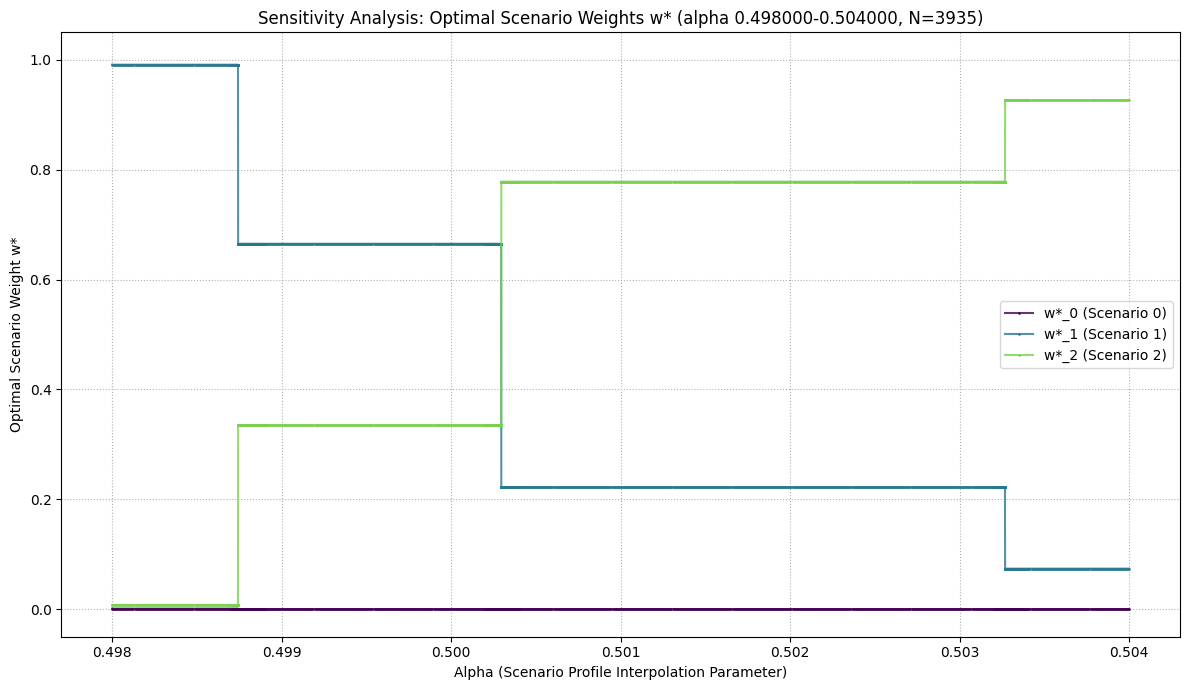

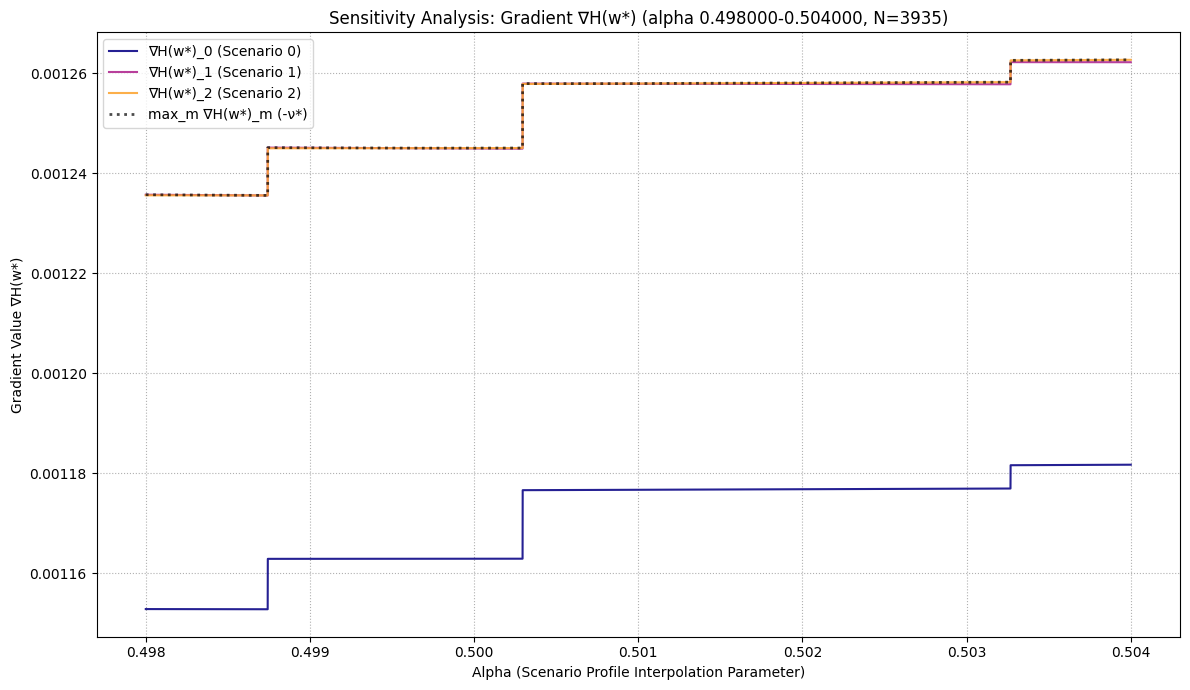

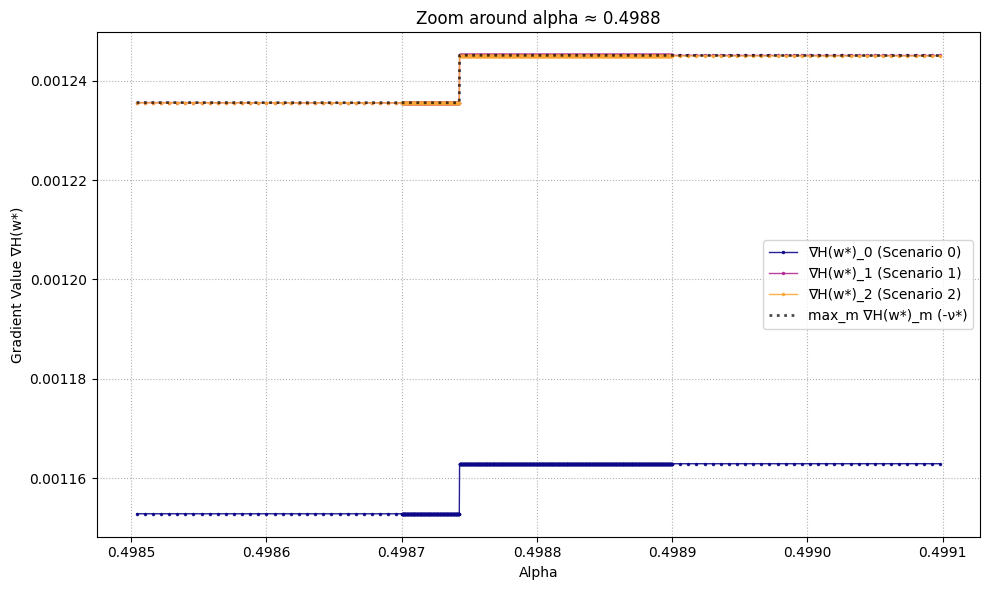

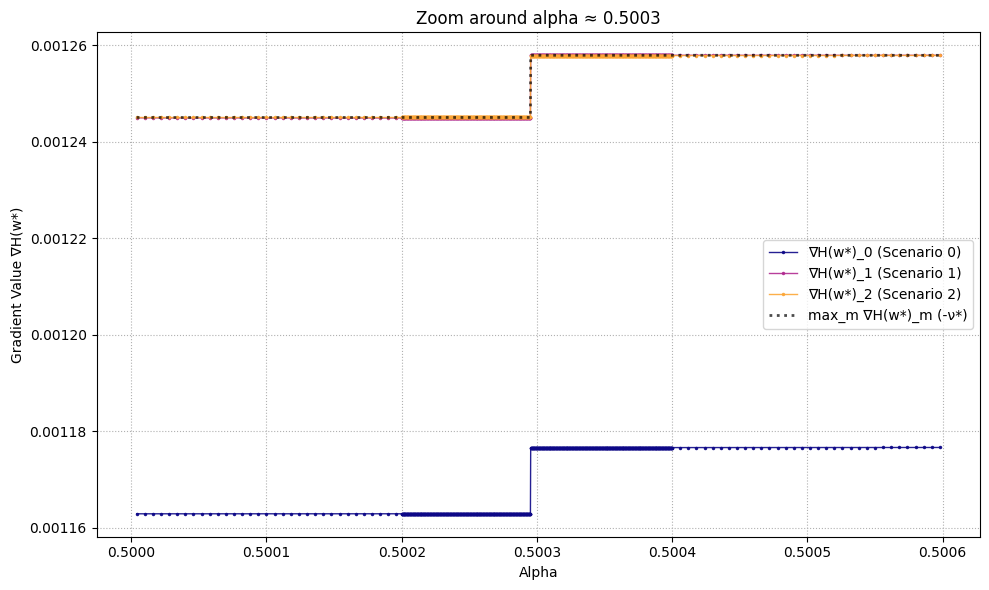

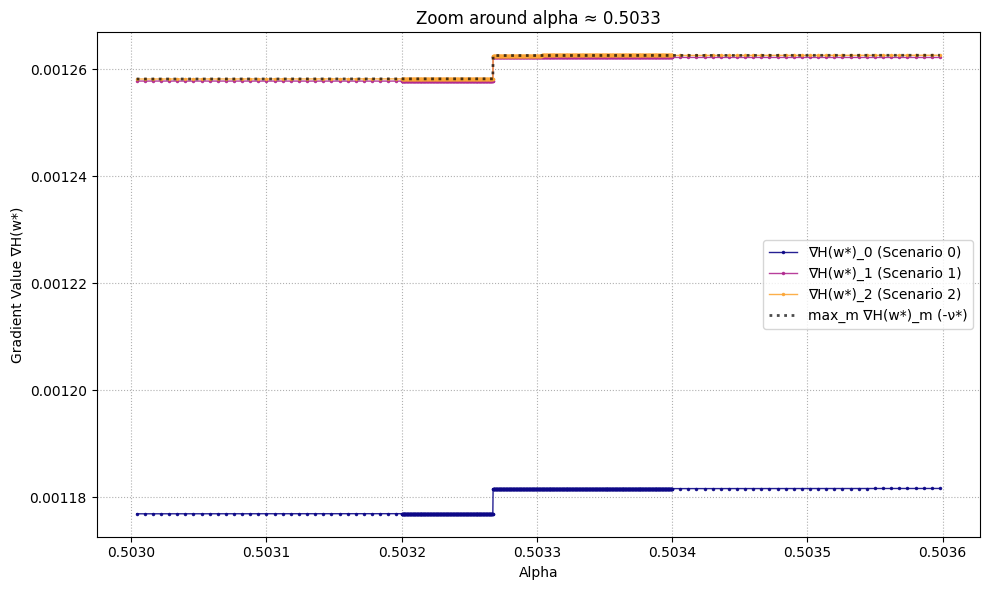

In [5]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy.linalg import solve, LinAlgError, lstsq
from scipy.optimize import linprog, OptimizeWarning
import traceback
import time

# 数値許容誤差のデフォルト値
DEFAULT_TOLERANCE = 1e-9

# --- OptimizationResult クラス (変更なし) ---
class OptimizationResult:
    def __init__(self, success, message, w_opt=None, pi_opt=None, lambda_opt=None, H_opt=None, grad_H_opt=None, iterations=None, fw_gap=None):
        self.success, self.message, self.w_opt, self.pi_opt, self.lambda_opt, self.H_opt = success, message, w_opt, pi_opt, lambda_opt, H_opt
        self.grad_H_opt = grad_H_opt
        self.iterations, self.fw_gap = iterations, fw_gap

# --- find_feasible_initial_pi 関数 (変更なし) ---
def find_feasible_initial_pi(R, mu_tilde, K, tolerance=1e-8):
    M = R.shape[1]; c = np.zeros(K + 1); c[K] = 1.0
    A_ub = np.hstack((-R.T, -np.ones((M, 1)))); b_ub = -mu_tilde * np.ones(M)
    bounds = [(None, None)] * K + [(0, None)]; opts = {'tol': tolerance, 'disp': False, 'presolve': True}
    result = None; methods_to_try = ['highs', 'highs-ipm', 'highs-ds', 'simplex']
    for method in methods_to_try:
        try:
            with warnings.catch_warnings(): warnings.filterwarnings("ignore", category=OptimizeWarning)
            result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method=method, options=opts)
            if result.success: break
        except ValueError: continue
        except Exception as e: return None, False, f"Phase 1 LP failed during {method}: {e}"
    if result is None or not result.success:
        msg = result.message if result else "No solver succeeded"; status = result.status if result else -1
        return None, False, f"Phase 1 LP solver failed after trying {methods_to_try}: {msg} (last status={status})"
    s = result.x[K]; pi = result.x[:K]
    if s <= tolerance * 100:
        G = -R.T; h = -mu_tilde * np.ones(M); violation = np.max(G @ pi - h)
        if violation <= tolerance * 1000: return pi, True, f"Phase 1 OK (s*={s:.1e}, max_vio={violation:.1e})"
        else: return pi, True, f"Phase 1 OK (s*={s:.1e}), but WARNING: Max violation {violation:.1e} > tol"
    else: return None, False, f"Phase 1 Infeasible (s* = {s:.1e} > 0)."

# --- solve_kkt_system 関数 (変更なし) ---
def solve_kkt_system(Q, G_W, g, tolerance=DEFAULT_TOLERANCE):
    K = Q.shape[0]; n_act = G_W.shape[0] if G_W is not None and G_W.ndim == 2 and G_W.shape[0] > 0 else 0
    if n_act == 0:
        try: p = solve(Q, -g, assume_a='sym'); l = []
        except LinAlgError: return None, None, False
        res_norm = np.linalg.norm(Q @ p + g); g_norm = np.linalg.norm(g); solved_ok = res_norm <= tolerance * 1e2 * (1 + g_norm)
        return p, l, solved_ok
    else:
        kkt_mat = None; rhs = None
        try:
          kkt_mat = np.block([[Q, G_W.T], [G_W, np.zeros((n_act, n_act))]])
          rhs = np.concatenate([-g, np.zeros(n_act)])
        except ValueError: return None, None, False
        try: sol = solve(kkt_mat, rhs, assume_a='sym'); p, l = sol[:K], sol[K:]
        except LinAlgError: return None, None, False
        res_norm = np.linalg.norm(kkt_mat @ sol - rhs); rhs_norm = np.linalg.norm(rhs); solved_ok = res_norm <= tolerance * 1e2 * (1 + rhs_norm)
        return p, l, solved_ok

# --- solve_inner_qp_active_set 関数 (変更なし) ---
def solve_inner_qp_active_set(Vw, R, mu_tilde, initial_pi, max_iter=350, tolerance=DEFAULT_TOLERANCE, regularization_epsilon=1e-10):
    K = Vw.shape[0]; M = R.shape[1]; Q = 2 * Vw + 2 * regularization_epsilon * np.eye(K); G = -R.T; h = -mu_tilde * np.ones(M)
    if initial_pi is None: return None, None, False, "No initial pi provided."
    pi_k = np.copy(initial_pi); lam_opt = np.zeros(M); W = set()
    infeasibility = np.max(G @ pi_k - h)
    if infeasibility > tolerance * 10: warnings.warn(f"Initial pi slightly infeasible (max violation: {infeasibility:.2e}). Proceeding.", UserWarning)
    for i in range(max_iter):
        g_k = Q @ pi_k; act = sorted(list(W)); n_act = len(act); G_Wk = G[act, :] if n_act > 0 else np.empty((0, K))
        p_k, lam_Wk, solved = solve_kkt_system(Q, G_Wk, g_k, tolerance)
        if not solved or p_k is None:
            cond_Q = np.linalg.cond(Q) if K > 0 else np.nan; kkt_mat_info = f"Q cond={cond_Q:.2e}"
            if n_act > 0 and G_Wk.size > 0:
                try: kkt_mat = np.block([[Q, G_Wk.T], [G_Wk, np.zeros((n_act, n_act))]]) ;cond_kkt = np.linalg.cond(kkt_mat)
                except (LinAlgError, ValueError): cond_kkt = float('inf')
                try: svd_vals = np.linalg.svd(G_Wk, compute_uv=False); rank_tol = tolerance * max(G_Wk.shape) * svd_vals[0] if svd_vals.size > 0 else tolerance; rank_G_Wk = np.linalg.matrix_rank(G_Wk, tol=rank_tol)
                except LinAlgError: rank_G_Wk = -1
                kkt_mat_info += f", KKT cond={cond_kkt:.2e}, rank(G_Wk)={rank_G_Wk}/{n_act}"
            fail_reason = "KKT solve failed" if p_k is None else "KKT residual too large"; return None, None, False, f"QP fail:Iter {i+1}: {fail_reason} (reg={regularization_epsilon:.1e}). {kkt_mat_info}. ActiveSet={act}"
        if np.linalg.norm(p_k) <= tolerance * (1 + np.linalg.norm(pi_k)):
            is_optimal_point = True; blocking_constraint_idx = -1; min_negative_lambda = float('inf'); lambda_map = {}
            if W:
                if lam_Wk is None: return None, None, False, f"QP fail:Iter {i+1}: p_k is small but lam_Wk is None? ActiveSet={act}"
                lambda_map = dict(zip(act, lam_Wk))
                for constraint_idx, lagrange_multiplier in lambda_map.items():
                    if lagrange_multiplier < -tolerance: is_optimal_point = False;
                    if lagrange_multiplier < min_negative_lambda: min_negative_lambda = lagrange_multiplier; blocking_constraint_idx = constraint_idx
            if is_optimal_point:
                if W and len(lam_Wk) == n_act: lam_opt[act] = lam_Wk
                final_infeas = np.max(G @ pi_k - h); msg = f"Optimal found at iter {i+1} (reg={regularization_epsilon:.1e})."
                if final_infeas > tolerance * 10: msg += f" (WARN: small final violation {final_infeas:.1e})"
                return pi_k, lam_opt, True, msg
            else:
                if blocking_constraint_idx in W: W.remove(blocking_constraint_idx); continue
                else: return None, None, False, f"QP fail:Iter {i+1}: Neg lambda {min_negative_lambda:.1e} for idx {blocking_constraint_idx}, not in W={act}?"
        else:
            alpha_k = 1.0; blocking_constraint_idx = -1
            direction_threshold = tolerance * (1 + np.linalg.norm(p_k)); blocking_candidates = []
            for j in range(M):
                if j not in W:
                    constraint_gradient_dot_p = G[j, :] @ p_k
                    if constraint_gradient_dot_p > direction_threshold:
                        distance_to_boundary = h[j] - (G[j, :] @ pi_k)
                        if distance_to_boundary >= -tolerance * 10:
                            if abs(constraint_gradient_dot_p) > 1e-15:
                                alpha_j = distance_to_boundary / constraint_gradient_dot_p
                                if alpha_j >= -tolerance: blocking_candidates.append((max(0.0, alpha_j), j))
            if blocking_candidates:
                min_alpha_candidate = min(blocking_candidates, key=lambda x: x[0])
                min_step_length, constraint_to_add = min_alpha_candidate
                if min_step_length < 1.0 - tolerance: alpha_k = min_step_length; blocking_constraint_idx = constraint_to_add
            pi_k += alpha_k * p_k
            if alpha_k < 1.0 - tolerance and blocking_constraint_idx != -1:
                if blocking_constraint_idx not in W: W.add(blocking_constraint_idx)
            continue
    # Max iter reached
    msg = f"Max iter ({max_iter}) reached."; final_infeas = np.max(G @ pi_k - h)
    if final_infeas > tolerance * 100: return None, None, False, f"{msg} Final solution potentially infeasible (max violation: {final_infeas:.1e}). ActiveSet={sorted(list(W))}"
    g_k = Q @ pi_k; act=sorted(list(W)); n_act=len(act); G_Wk=G[act,:] if n_act>0 else np.empty((0,K));
    p_f, lam_f, solved_f = solve_kkt_system(Q, G_Wk, g_k, tolerance)
    final_lambda_estimate = np.zeros(M); is_likely_optimal = False
    if solved_f and p_f is not None and np.linalg.norm(p_f) <= tolerance * (1 + np.linalg.norm(pi_k)):
        if n_act > 0 and lam_f is not None and len(lam_f) == n_act: final_lambda_estimate[act] = lam_f
        active_lambdas = final_lambda_estimate[act] if n_act > 0 else np.array([])
        if n_act == 0 or np.all(active_lambdas >= -tolerance): is_likely_optimal = True; msg += " Final check suggests KKT satisfied (likely optimal)."
        else: neg_lam_indices = [idx for idx in act if final_lambda_estimate[idx] < -tolerance]; msg += f" Final check: KKT stationarity ok, but dual feasibility fails (neg lambda for {neg_lam_indices})."
    elif solved_f and p_f is not None: msg += f" Final check: KKT stationarity likely not met (||p_k||={np.linalg.norm(p_f):.1e} > tol)."
    else: msg += " Final check: KKT system solve failed at the end."
    if n_act > 0 and lam_f is not None and final_lambda_estimate is not None and len(final_lambda_estimate) == M and len(lam_f) == n_act:
        try: final_lambda_estimate[act] = lam_f
        except IndexError: pass
    return pi_k, final_lambda_estimate, is_likely_optimal, msg

# --- make_psd 関数 (変更なし) ---
def make_psd(matrix, tolerance=1e-8):
    sym = (matrix + matrix.T) / 2;
    try: eigenvalues, eigenvectors = np.linalg.eigh(sym); min_eigenvalue = np.min(eigenvalues)
    except LinAlgError: warnings.warn("make_psd: eigenvalue decomposition failed.", RuntimeWarning); return sym
    if min_eigenvalue < tolerance: eigenvalues[eigenvalues < tolerance] = tolerance; psd_matrix = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T; return (psd_matrix + psd_matrix.T) / 2
    else: return sym

# --- calculate_Vw 関数 (変更なし) ---
def calculate_Vw(w, R, SecondMomentMatrices, tolerance=DEFAULT_TOLERANCE, psd_tolerance=1e-8):
    K, M = R.shape; w_sum = np.sum(w)
    if not np.isclose(w_sum, 1.0) and w_sum > 0: w_norm = w / w_sum
    elif w_sum <= 0: w_norm = np.ones(M) / M
    else: w_norm = w
    w_norm = np.maximum(w_norm, 0); w_sum_final = np.sum(w_norm)
    if w_sum_final > 0 and not np.isclose(w_sum_final, 1.0): w_norm = w_norm / w_sum_final
    elif w_sum_final <= 0: w_norm = np.ones(M) / M
    EwX = R @ w_norm; EwXXT = np.zeros((K, K));
    for m in range(M): EwXXT += w_norm[m] * SecondMomentMatrices[m]
    Vw = EwXXT - np.outer(EwX, EwX); return make_psd(Vw, psd_tolerance), EwX, EwXXT

# --- calculate_H_gradient 関数 (変更なし) ---
def calculate_H_gradient(pi_star, w, R, SecondMomentMatrices, EwX, EwXXT, tolerance=1e-9):
    M = w.shape[0]; grad = np.zeros(M)
    if pi_star is None or np.linalg.norm(pi_star) < tolerance or EwX is None: return grad
    pi_T_EwX = pi_star.T @ EwX
    for j in range(M): grad[j] = pi_star.T @ SecondMomentMatrices[j] @ pi_star - 2 * (pi_star.T @ R[:, j]) * pi_T_EwX
    if np.any(np.isnan(grad)) or np.any(np.isinf(grad)): warnings.warn("NaN or Inf in H gradient. Returning zero vector.", RuntimeWarning); return np.zeros(M)
    return grad

# --- project_to_simplex 関数 (変更なし) ---
def project_to_simplex(v, z=1):
    n_features = v.shape[0];
    if n_features == 0: return np.array([])
    if np.all(v >= -1e-9) and np.isclose(np.sum(v), z): return np.maximum(v, 0)
    u = np.sort(v)[::-1]; cssv = np.cumsum(u) - z; ind = np.arange(n_features) + 1; cond = u - cssv / ind > 0
    if np.any(cond): rho = ind[cond][-1]; theta = cssv[rho - 1] / float(rho); w = np.maximum(v - theta, 0)
    else: w = np.zeros(n_features); w[np.argmax(v)] = z
    w_sum = np.sum(w);
    if not np.isclose(w_sum, z):
        if w_sum > 1e-9: w = w * (z / w_sum)
        else: w = np.zeros(n_features) if z == 0 else np.array([z] + [0]*(n_features-1))
    return w

# --- frank_wolfe_optimizer 関数 (変更なし) ---
def frank_wolfe_optimizer(R_alpha, SecondMomentMatrices_alpha, mu_tilde, initial_w=None, max_outer_iter=250, fw_gap_tol=1e-7, inner_max_iter=350, tolerance=1e-9, psd_make_tolerance=1e-8, qp_regularization=1e-10):
    K, M = R_alpha.shape; w_k = np.ones(M) / M if initial_w is None else project_to_simplex(np.copy(initial_w)); fw_gap = float('inf')
    best_w = np.copy(w_k); best_pi = None; best_lam = np.zeros(M); best_H = -float('inf'); final_gHk = np.zeros(M)
    pi0, ok, p1msg = find_feasible_initial_pi(R_alpha, mu_tilde, K, tolerance)
    if not ok: return OptimizationResult(False, f"Phase 1 failed: {p1msg}", w_opt=initial_w)
    for k in range(max_outer_iter):
        try: Vk, Ex, ExxT = calculate_Vw(w_k, R_alpha, SecondMomentMatrices_alpha, tolerance, psd_tolerance=psd_make_tolerance)
        except Exception as e: return OptimizationResult(False, f"Outer iter {k+1}: calculate_Vw failed: {e}\n{traceback.format_exc()}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        pk, lk, inner_ok, inner_msg = solve_inner_qp_active_set(Vk, R_alpha, mu_tilde, pi0, inner_max_iter, tolerance=tolerance, regularization_epsilon=qp_regularization)
        if not inner_ok or pk is None: return OptimizationResult(False, f"Outer iter {k+1}: Inner QP failed: {inner_msg}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        Hk = pk.T @ Vk @ pk
        try: gHk = calculate_H_gradient(pk, w_k, R_alpha, SecondMomentMatrices_alpha, Ex, ExxT, tolerance)
        except Exception as e: return OptimizationResult(False, f"Outer iter {k+1}: Gradient calculation failed: {e}\n{traceback.format_exc()}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        final_gHk = gHk
        if Hk > best_H - tolerance: best_H = Hk; best_w = np.copy(w_k); best_pi = np.copy(pk); best_lam = np.copy(lk) if lk is not None else np.zeros(M)
        sk_idx = np.argmax(gHk); sk = np.zeros(M); sk[sk_idx] = 1.0; fw_gap = gHk.T @ (sk - w_k)
        if fw_gap <= fw_gap_tol: return OptimizationResult(True, f"Converged (FW Gap={fw_gap:.2e} <= {fw_gap_tol:.1e})", w_opt=best_w, pi_opt=best_pi, lambda_opt=best_lam, H_opt=best_H, grad_H_opt=final_gHk, iterations=k + 1, fw_gap=fw_gap)
        if np.abs(fw_gap) < tolerance: return OptimizationResult(True, f"Converged (FW Gap near zero: {fw_gap:.2e})", w_opt=best_w, pi_opt=best_pi, lambda_opt=best_lam, H_opt=best_H, grad_H_opt=final_gHk, iterations=k + 1, fw_gap=fw_gap)
        if fw_gap < -tolerance: warnings.warn(f"Outer iter {k+1}: Negative FW Gap ({fw_gap:.2e}).", RuntimeWarning)
        gamma = 2.0 / (k + 3.0); w_k = (1.0 - gamma) * w_k + gamma * sk; w_k = project_to_simplex(w_k); pi0 = pk
    return OptimizationResult(True, f"Max Outer Iterations ({max_outer_iter}) reached", w_opt=best_w, pi_opt=best_pi, lambda_opt=best_lam, H_opt=best_H, grad_H_opt=final_gHk, iterations=max_outer_iter, fw_gap=fw_gap)

# --- generate_params_profile_switching 関数 (変更なし) ---
def generate_params_profile_switching(alpha, alpha_max, K=5, M=3,
    R_base=np.array([0.08, 0.07, 0.06, 0.05, 0.04]),
    sigma_base=np.array([0.18, 0.15, 0.20, 0.12, 0.10]),
    Corr_base=np.array([[1.0, 0.4, 0.3, 0.2, 0.1], [0.4, 1.0, 0.5, 0.3, 0.2], [0.3, 0.5, 1.0, 0.6, 0.4], [0.2, 0.3, 0.6, 1.0, 0.5], [0.1, 0.2, 0.4, 0.5, 1.0]]),
    good_prof_r_factor=0.05, good_prof_r_offset=0.002, good_prof_s_factor=-0.02, good_prof_corr_factor=1.0,
    bad_prof_r_factor=-0.02, bad_prof_r_offset=-0.001, bad_prof_s_factor=0.02, bad_prof_corr_offset=0.0,
    sigma_min_epsilon=1e-4, psd_tolerance=1e-9
):
    assert alpha >= 0 and K == len(R_base) and K == len(sigma_base) and K == Corr_base.shape[0] and M == 3
    non_diag_indices = np.where(~np.eye(K, dtype=bool))
    R_neutral = R_base; sigma_neutral = np.maximum(sigma_min_epsilon, sigma_base); Corr_neutral = make_psd(Corr_base, psd_tolerance)
    R_good = R_base + (R_base * good_prof_r_factor + good_prof_r_offset); sigma_good = np.maximum(sigma_min_epsilon, sigma_base + (sigma_base * good_prof_s_factor)); Corr_good_target = np.copy(Corr_base); Corr_good_target[non_diag_indices] *= good_prof_corr_factor; Corr_good = make_psd(Corr_good_target, psd_tolerance)
    R_bad = R_base + (R_base * bad_prof_r_factor + bad_prof_r_offset); sigma_bad = np.maximum(sigma_min_epsilon, sigma_base + (sigma_base * bad_prof_s_factor)); Corr_bad_target = np.copy(Corr_base); Corr_bad_target[non_diag_indices] = np.clip(Corr_bad_target[non_diag_indices] + bad_prof_corr_offset, -1.0+psd_tolerance, 1.0-psd_tolerance); Corr_bad = make_psd(Corr_bad_target, psd_tolerance)
    beta = np.clip(alpha / alpha_max if alpha_max > 0 else (1.0 if alpha > 0 else 0.0), 0.0, 1.0)
    R_alpha = np.zeros((K, M)); sigma_alpha = np.zeros((K, M)); Corr_alpha = [np.eye(K) for _ in range(M)]; Cov_alpha = [np.eye(K) for _ in range(M)]; SecondMoments_alpha = [np.eye(K) for _ in range(M)]
    R_alpha[:, 0] = (1 - beta) * R_good + beta * R_neutral; sigma_alpha[:, 0] = np.maximum(sigma_min_epsilon, (1 - beta) * sigma_good + beta * sigma_neutral); Corr_alpha[0] = make_psd((1 - beta) * Corr_good + beta * Corr_neutral, psd_tolerance)
    R_alpha[:, 1] = (1 - beta) * R_bad + beta * R_good; sigma_alpha[:, 1] = np.maximum(sigma_min_epsilon, (1 - beta) * sigma_bad + beta * sigma_good); Corr_alpha[1] = make_psd((1 - beta) * Corr_bad + beta * Corr_good, psd_tolerance)
    R_alpha[:, 2] = (1 - beta) * R_neutral + beta * R_bad; sigma_alpha[:, 2] = np.maximum(sigma_min_epsilon, (1 - beta) * sigma_neutral + beta * sigma_bad); Corr_alpha[2] = make_psd((1 - beta) * Corr_neutral + beta * Corr_bad, psd_tolerance)
    for m in range(M): sigma_diag_m = np.diag(sigma_alpha[:, m]); Cov_alpha[m] = sigma_diag_m @ Corr_alpha[m] @ sigma_diag_m; SecondMoments_alpha[m] = Cov_alpha[m] + np.outer(R_alpha[:, m], R_alpha[:, m])
    return R_alpha, SecondMoments_alpha


# --- パラメトリックスタディ実行 ---
if __name__ == '__main__':
    start_time = time.time()
    warnings.filterwarnings('ignore', category=RuntimeWarning, message=".*invalid value encountered.*")
    warnings.filterwarnings('ignore', category=UserWarning, message=".*Initial pi is slightly infeasible.*")
    warnings.filterwarnings('ignore', category=UserWarning, message=".*Solver terminated early.*")
    warnings.filterwarnings('ignore', category=UserWarning, message=".*Phase 1:.*failed.*")
    warnings.filterwarnings('ignore', category=OptimizeWarning)

    K = 5; M = 3; mu_tilde = 0.03; scenario_names = ["Scenario 0", "Scenario 1", "Scenario 2"]

    # === Alpha 値の設定 (変更なし) ===
    alpha_min_wide = 0.498
    alpha_max_wide = 0.504
    n_steps_wide = 1001
    transition_points = [0.4988, 0.5003, 0.5033]
    zoom_radius = 0.0001
    n_steps_zoom = 1001
    alpha_values_wide = np.linspace(alpha_min_wide, alpha_max_wide, n_steps_wide)
    alpha_values_zoom_list = []
    for center in transition_points:
        alpha_zoom = np.linspace(center - zoom_radius, center + zoom_radius, n_steps_zoom)
        alpha_values_zoom_list.append(alpha_zoom)
    all_alpha_values = np.concatenate([alpha_values_wide] + alpha_values_zoom_list)
    alpha_values = np.unique(all_alpha_values)
    alpha_values.sort()

    alpha_max = 1.5

    # === プロファイル作成用パラメータ (変更なし) ===
    profile_adjustments = {
        'good_prof_r_factor': 0.05,   'good_prof_r_offset': 0.002,
        'good_prof_s_factor': -0.02, 'good_prof_corr_factor': 1.0,
        'bad_prof_r_factor': -0.02, 'bad_prof_r_offset': -0.001,
        'bad_prof_s_factor': 0.02,  'bad_prof_corr_offset': 0.0,
    }
    param_gen_kwargs = {'K': K, 'M': M, 'alpha_max': alpha_max, **profile_adjustments}

    optimizer_kwargs = {'max_outer_iter': 250, 'fw_gap_tol': 1e-7, 'inner_max_iter': 400, 'tolerance': DEFAULT_TOLERANCE, 'psd_make_tolerance': 1e-8, 'qp_regularization': 1e-8}
    results_w, results_pi, results_H, results_grad_H, results_success, results_msg = [], [], [], [], [], []
    initial_w_guess = None

    # === ★ 詳細を出力する Alpha 値のリスト ★ ===
    # 遷移点とその前後、中間点、最初と最後など
    # Note: np.linspaceで生成される値と完全に一致しない場合があるので、近傍で判定する
    target_alphas_for_details = [
        alpha_values[0],        # 最初のalpha値
        0.4987, 0.4988, 0.4989, # 遷移点1近傍
        0.5003,                 # 中間点
        0.5032, 0.5033, 0.5034, # 遷移点2近傍
        alpha_values[-1]       # 最後のalpha値
    ]
    # 比較用の許容誤差 (alpha値が完全に一致しなくても近ければOKとするため)
    print_detail_tolerance = 1e-5 # 0.00001

    print(f"パラメトリックスタディ (M={M}, K={K}, mu_tilde={mu_tilde}, Profile Switching Trial 6 - High Resolution Scan)")
    print(f"alpha 範囲: {alpha_values[0]:.6f} to {alpha_values[-1]:.6f}, N={len(alpha_values)}")
    print(f"広範囲: {alpha_min_wide:.3f}-{alpha_max_wide:.3f} ({n_steps_wide} points)")
    print(f"遷移点近傍ズーム (半径 {zoom_radius:.4f}, {n_steps_zoom} points/point): {transition_points}")
    print(f"プロファイル調整値 (試行6): {profile_adjustments}"); print(f"Optimizer Kwargs: {optimizer_kwargs}")
    print(f"詳細を出力するAlpha値 (近傍): {target_alphas_for_details}") # ★ 追加

    for i, alpha in enumerate(alpha_values):
        # ループ内の進捗表示 (毎回表示)
        print(f"\n--- alpha = {alpha:.6f} ({i+1}/{len(alpha_values)}) ---")

        try: R_a, SecondMoments_a = generate_params_profile_switching(alpha, **param_gen_kwargs)
        except Exception as e:
            print(f"\n  ERROR: パラメータ生成エラー: {e}\n{traceback.format_exc()}"); results_success.append(False); results_msg.append(f"Param gen error: {e}"); results_w.append(None); results_pi.append(None); results_H.append(np.nan); results_grad_H.append(None); initial_w_guess = None; continue
        try: result = frank_wolfe_optimizer(R_a, SecondMoments_a, mu_tilde, initial_w=initial_w_guess, **optimizer_kwargs)
        except Exception as e:
             print(f"\n  ERROR: frank_wolfe_optimizer で予期せぬエラー: {e}\n{traceback.format_exc()}"); results_success.append(False); results_msg.append(f"Optimizer error: {e}"); results_w.append(None); results_pi.append(None); results_H.append(np.nan); results_grad_H.append(None); initial_w_guess = None; continue

        # === ★ 出力制御 ★ ===
        should_print_details = False
        for target_alpha in target_alphas_for_details:
            if abs(alpha - target_alpha) < print_detail_tolerance:
                should_print_details = True
                break

        if should_print_details:
            # 詳細情報の出力 (有効桁数を増やす)
            if result.success and result.w_opt is not None:
                print(f"  SUCCESS. H(w*)={result.H_opt:.12e}, FW Gap={result.fw_gap:.4e}, OuterIters={result.iterations}") # Hの精度向上
                w_disp = ", ".join([f"{w:.12f}" for w in result.w_opt]) # wの精度向上
                print(f"  Optimal w*: [{w_disp}]")
                if result.grad_H_opt is not None:
                     grad_disp = ", ".join([f"{g:.12e}" for g in result.grad_H_opt]) # gradの精度向上
                     print(f"  Gradient∇H(w*): [{grad_disp}]")
                else: print("  Gradient∇H(w*): [N/A]")
            else:
                print(f"  FAILED/NO SOLUTION: {result.message}")
        else:
            # 簡単なメッセージのみ表示
            if result.success:
                print("  Success (details omitted).")
            else:
                print(f"  FAILED/NO SOLUTION (details omitted): {result.message}")
        # === ★ 出力制御ここまで ★ ===


        # 結果の格納 (これは全alphaで行う)
        results_success.append(result.success); results_msg.append(result.message)
        if result.success and result.w_opt is not None:
            results_w.append(result.w_opt); results_pi.append(result.pi_opt); results_H.append(result.H_opt); results_grad_H.append(result.grad_H_opt); initial_w_guess = result.w_opt
        else:
            results_w.append(None); results_pi.append(None); results_H.append(np.nan); results_grad_H.append(None); initial_w_guess = None # 失敗したら初期値リセット


    end_time = time.time()
    print(f"\n計算完了。所要時間: {end_time - start_time:.2f} 秒")

    # --- 結果の集計とプロット用データの準備 (変更なし) ---
    print("\n--- パラメトリックスタディ結果 (High Resolution Scan, Details Omitted for Table) ---") # テーブル表示は省略
    plot_alphas, valid_results_w, valid_results_H, valid_results_grad_H = [], [], [], []
    for idx, alpha in enumerate(alpha_values):
        success = results_success[idx] if idx < len(results_success) else False
        w_res = results_w[idx] if idx < len(results_w) else None
        pi_res = results_pi[idx] if idx < len(results_pi) else None
        h_res = results_H[idx] if idx < len(results_H) else np.nan
        grad_res = results_grad_H[idx] if idx < len(results_grad_H) else None

        if success and w_res is not None and h_res is not None and not np.isnan(h_res) and grad_res is not None:
             plot_alphas.append(alpha)
             valid_results_w.append(w_res)
             valid_results_H.append(h_res)
             if grad_res is not None:
                 valid_results_grad_H.append(grad_res)
             else:
                 valid_results_grad_H.append([np.nan] * M)

    # --- w* のプロット (変更なし) ---
    if plot_alphas and valid_results_w:
        valid_results_w_array = np.array(valid_results_w)
        fig_w, ax_w = plt.subplots(figsize=(12, 7))
        colors_w = plt.cm.viridis(np.linspace(0, 0.8, M))

        for m in range(M):
            ax_w.plot(plot_alphas, valid_results_w_array[:, m], marker='.', linestyle='-', markersize=2,
                      label=f'w*_{m} ({scenario_names[m]})', color=colors_w[m], alpha=0.8)

        ax_w.set_xlabel('Alpha (Scenario Profile Interpolation Parameter)')
        ax_w.set_ylabel('Optimal Scenario Weight w*')
        ax_w.set_title(f'Sensitivity Analysis: Optimal Scenario Weights w* (alpha {plot_alphas[0]:.6f}-{plot_alphas[-1]:.6f}, N={len(plot_alphas)})')
        ax_w.legend(loc='best')
        ax_w.grid(True, linestyle=':')
        ax_w.set_ylim(-0.05, 1.05)
        fig_w.tight_layout()

    else: print("\nプロットする有効な結果(w*, H)がありませんでした。")

    # --- 勾配 ∇H(w*) の詳細プロット (変更なし) ---
    if plot_alphas and valid_results_grad_H:
        valid_results_grad_array = np.array(valid_results_grad_H)
        fig2, ax_grad = plt.subplots(figsize=(12, 7))
        colors_grad = plt.cm.plasma(np.linspace(0, 0.8, M))

        for m in range(M):
             ax_grad.plot(plot_alphas, valid_results_grad_array[:, m], marker=None, linestyle='-',
                          label=f'∇H(w*)_{m} ({scenario_names[m]})', color=colors_grad[m], alpha=0.9, linewidth=1.5)

        try:
            max_grad_values = np.nanmax(valid_results_grad_array, axis=1)
            ax_grad.plot(plot_alphas, max_grad_values, marker=None, linestyle=':', color='black',
                         label='max_m ∇H(w*)_m (-ν*)', alpha=0.7, linewidth=2)
        except ValueError:
            print("Warning: Could not compute max_grad_values, likely all NaNs.")

        ax_grad.set_xlabel('Alpha (Scenario Profile Interpolation Parameter)')
        ax_grad.set_ylabel('Gradient Value ∇H(w*)')
        ax_grad.set_title(f'Sensitivity Analysis: Gradient ∇H(w*) (alpha {plot_alphas[0]:.6f}-{plot_alphas[-1]:.6f}, N={len(plot_alphas)})')
        ax_grad.legend(loc='best')
        ax_grad.grid(True, linestyle=':')
        fig2.tight_layout()

        # --- 遷移点近傍の拡大図 (変更なし) ---
        zoom_center_1 = 0.4988
        zoom_radius_plot = 0.0003
        zoom_indices_1 = (np.array(plot_alphas) >= zoom_center_1 - zoom_radius_plot) & (np.array(plot_alphas) <= zoom_center_1 + zoom_radius_plot)

        if np.any(zoom_indices_1):
            fig_zoom1, ax_zoom1 = plt.subplots(figsize=(10, 6))
            for m in range(M):
                ax_zoom1.plot(np.array(plot_alphas)[zoom_indices_1], valid_results_grad_array[zoom_indices_1, m], marker='.', markersize=3, linestyle='-',
                             label=f'∇H(w*)_{m} ({scenario_names[m]})', color=colors_grad[m], alpha=0.9, linewidth=1)
            try:
                ax_zoom1.plot(np.array(plot_alphas)[zoom_indices_1], max_grad_values[zoom_indices_1], marker=None, linestyle=':', color='black',
                             label='max_m ∇H(w*)_m (-ν*)', alpha=0.7, linewidth=2)
            except NameError: pass
            ax_zoom1.set_title(f'Zoom around alpha ≈ {zoom_center_1}')
            ax_zoom1.set_xlabel('Alpha'); ax_zoom1.set_ylabel('Gradient Value ∇H(w*)')
            ax_zoom1.legend(loc='best'); ax_zoom1.grid(True, linestyle=':')
            fig_zoom1.tight_layout()

        zoom_center_2 = 0.5003
        zoom_indices_2 = (np.array(plot_alphas) >= zoom_center_2 - zoom_radius_plot) & (np.array(plot_alphas) <= zoom_center_2 + zoom_radius_plot)

        if np.any(zoom_indices_2):
             fig_zoom2, ax_zoom2 = plt.subplots(figsize=(10, 6))
             for m in range(M):
                 ax_zoom2.plot(np.array(plot_alphas)[zoom_indices_2], valid_results_grad_array[zoom_indices_2, m], marker='.', markersize=3, linestyle='-',
                              label=f'∇H(w*)_{m} ({scenario_names[m]})', color=colors_grad[m], alpha=0.9, linewidth=1)
             try:
                 ax_zoom2.plot(np.array(plot_alphas)[zoom_indices_2], max_grad_values[zoom_indices_2], marker=None, linestyle=':', color='black',
                              label='max_m ∇H(w*)_m (-ν*)', alpha=0.7, linewidth=2)
             except NameError: pass
             ax_zoom2.set_title(f'Zoom around alpha ≈ {zoom_center_2}')
             ax_zoom2.set_xlabel('Alpha'); ax_zoom2.set_ylabel('Gradient Value ∇H(w*)')
             ax_zoom2.legend(loc='best'); ax_zoom2.grid(True, linestyle=':')
             fig_zoom2.tight_layout()

        zoom_center_3 = 0.5033
        zoom_indices_3 = (np.array(plot_alphas) >= zoom_center_3 - zoom_radius_plot) & (np.array(plot_alphas) <= zoom_center_3 + zoom_radius_plot)

        if np.any(zoom_indices_3):
             fig_zoom3, ax_zoom3 = plt.subplots(figsize=(10, 6))
             for m in range(M):
                 ax_zoom3.plot(np.array(plot_alphas)[zoom_indices_3], valid_results_grad_array[zoom_indices_3, m], marker='.', markersize=3, linestyle='-',
                              label=f'∇H(w*)_{m} ({scenario_names[m]})', color=colors_grad[m], alpha=0.9, linewidth=1)
             try:
                 ax_zoom3.plot(np.array(plot_alphas)[zoom_indices_3], max_grad_values[zoom_indices_3], marker=None, linestyle=':', color='black',
                              label='max_m ∇H(w*)_m (-ν*)', alpha=0.7, linewidth=2)
             except NameError: pass
             ax_zoom3.set_title(f'Zoom around alpha ≈ {zoom_center_3}')
             ax_zoom3.set_xlabel('Alpha'); ax_zoom3.set_ylabel('Gradient Value ∇H(w*)')
             ax_zoom3.legend(loc='best'); ax_zoom3.grid(True, linestyle=':')
             fig_zoom3.tight_layout()


        plt.show() # 全てのプロットをまとめて表示

    else: print("\nプロットする有効な結果(∇H)がありませんでした。")

パラメトリックスタディ (M=3, K=5, mu_tilde=0.03, Profile Switching Trial 6 - High Resolution Scan)
alpha 範囲: 0.498000 to 0.504000, N=3935
プロファイル調整値 (試行6): {'good_prof_r_factor': 0.05, 'good_prof_r_offset': 0.002, 'good_prof_s_factor': -0.02, 'good_prof_corr_factor': 1.0, 'bad_prof_r_factor': -0.02, 'bad_prof_r_offset': -0.001, 'bad_prof_s_factor': 0.02, 'bad_prof_corr_offset': 0.0}
Optimizer Kwargs: {'max_outer_iter': 250, 'fw_gap_tol': 1e-07, 'inner_max_iter': 400, 'tolerance': 1e-09, 'psd_make_tolerance': 1e-08, 'qp_regularization': 1e-08}
詳細を出力するAlpha値 (近傍): [np.float64(0.498), 0.4987, 0.4988, 0.4989, 0.5003, 0.5032, 0.50325, 0.50329, 0.5033, 0.50331, 0.5034, np.float64(0.504)]

--- alpha = 0.498000 (1/3935) ---
  SUCCESS. H(w*)=2.164104061420e-03, FW Gap=9.2983e-08, OuterIters=24
  Optimal w*: [0.001111111111, 0.991111111111, 0.007777777778]
  Gradient∇H(w*): [1.152863370329e-03, 1.235695276796e-03, 1.235573475940e-03]

--- alpha = 0.498006 (2/3935) ---
  SUCCESS. H(w*)=2.164104037845e-03, FW

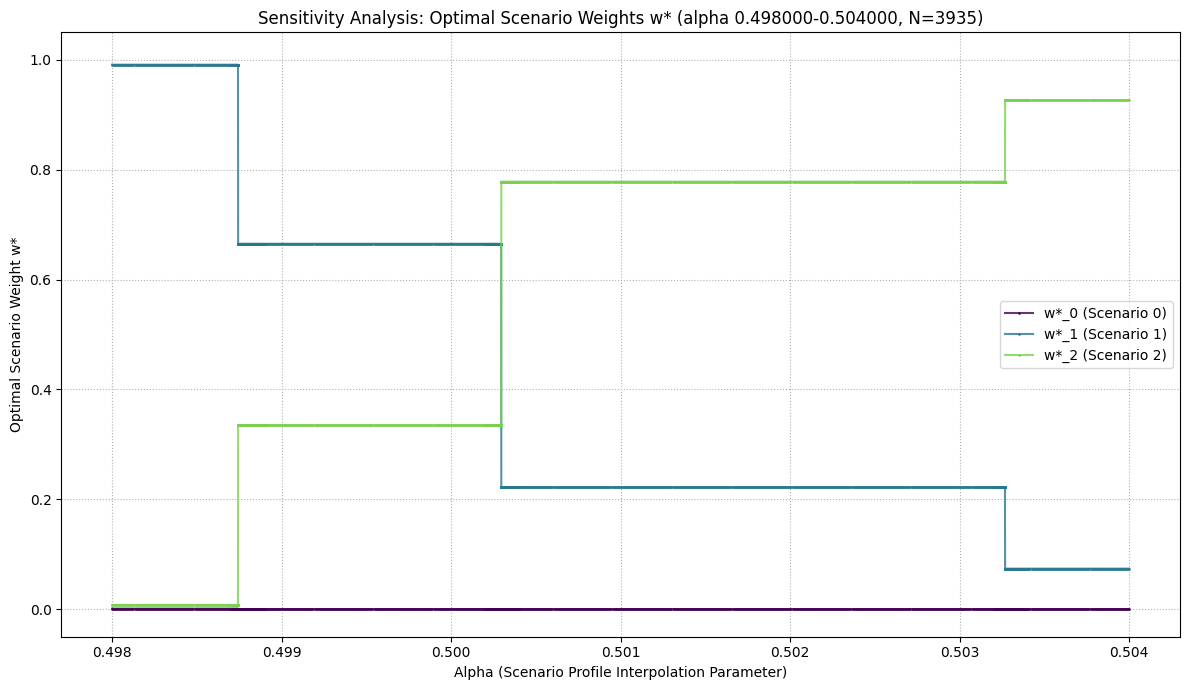

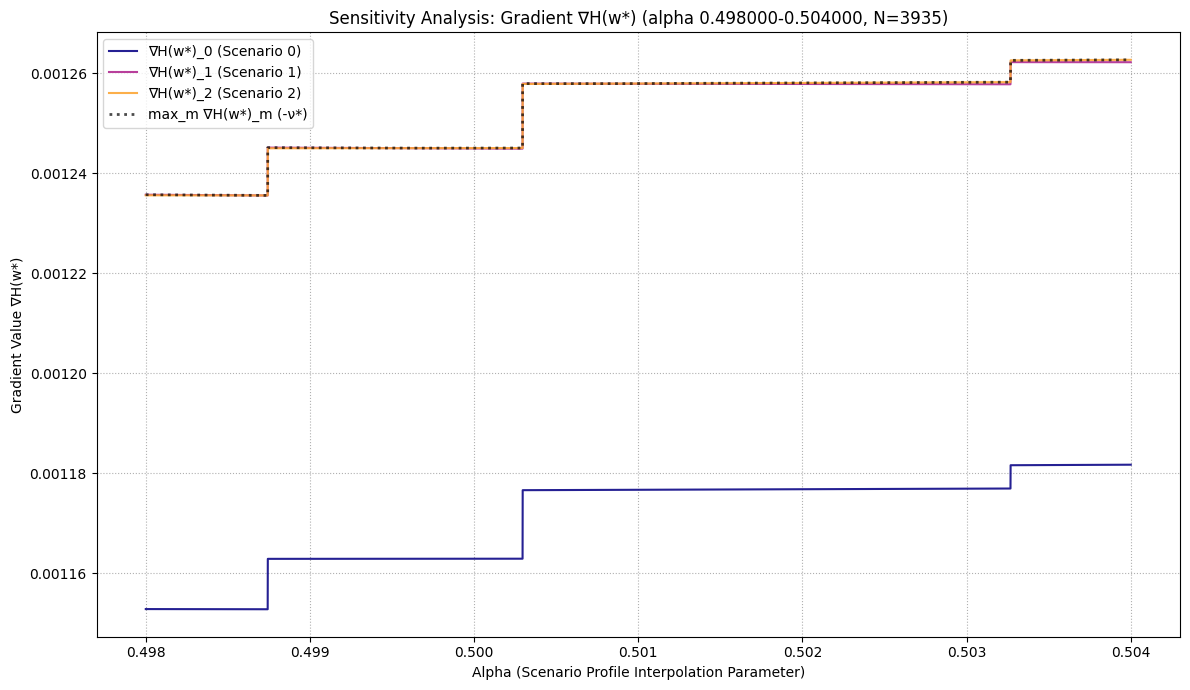

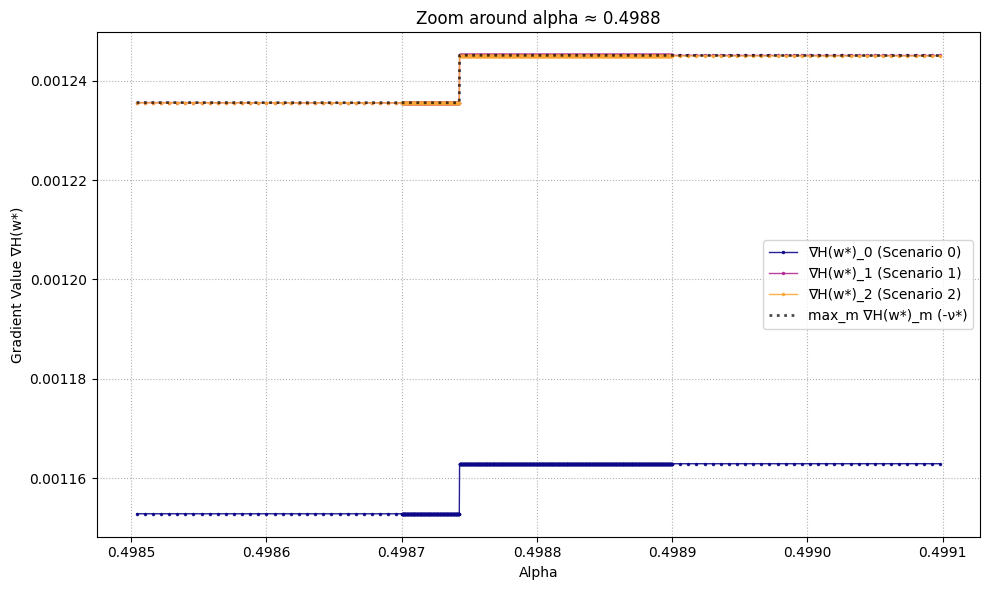

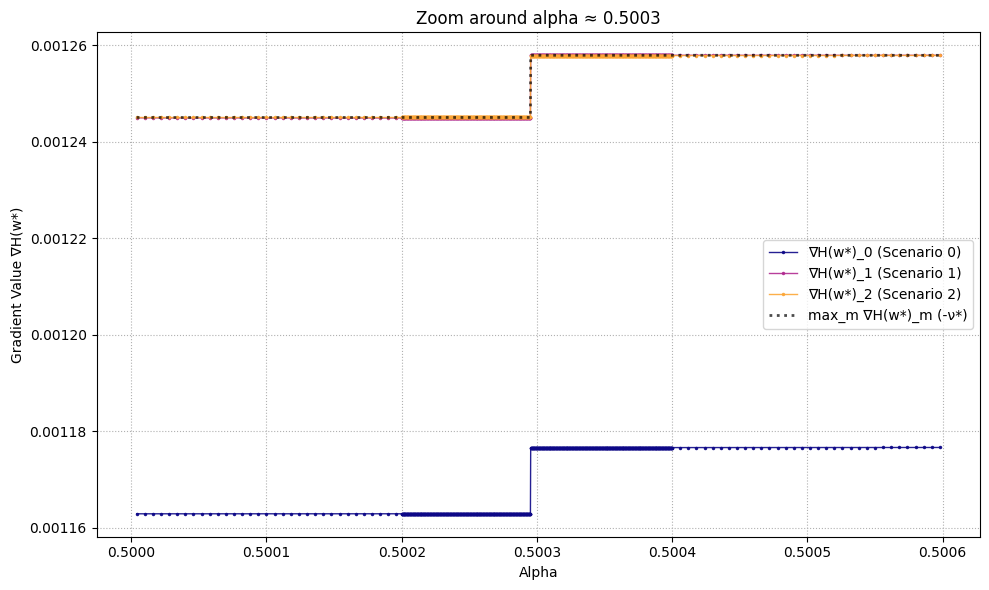

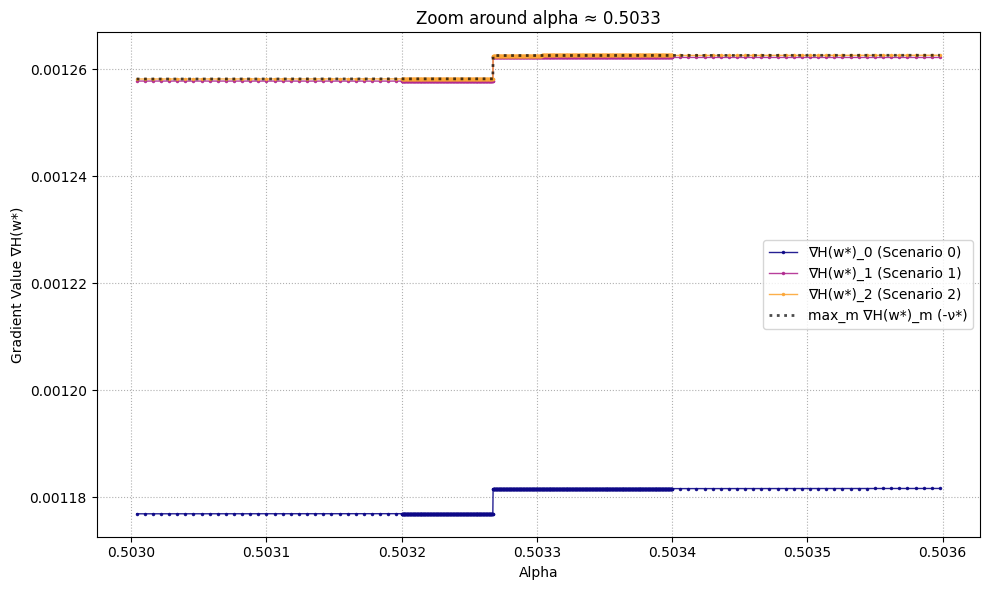

In [8]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy.linalg import solve, LinAlgError, lstsq
from scipy.optimize import linprog, OptimizeWarning
import traceback
import time

# 数値許容誤差のデフォルト値
DEFAULT_TOLERANCE = 1e-9

# --- OptimizationResult クラス (変更なし) ---
class OptimizationResult:
    def __init__(self, success, message, w_opt=None, pi_opt=None, lambda_opt=None, H_opt=None, grad_H_opt=None, iterations=None, fw_gap=None):
        self.success, self.message, self.w_opt, self.pi_opt, self.lambda_opt, self.H_opt = success, message, w_opt, pi_opt, lambda_opt, H_opt
        self.grad_H_opt = grad_H_opt
        self.iterations, self.fw_gap = iterations, fw_gap

# --- find_feasible_initial_pi 関数 (変更なし) ---
def find_feasible_initial_pi(R, mu_tilde, K, tolerance=1e-8):
    M = R.shape[1]; c = np.zeros(K + 1); c[K] = 1.0
    A_ub = np.hstack((-R.T, -np.ones((M, 1)))); b_ub = -mu_tilde * np.ones(M)
    bounds = [(None, None)] * K + [(0, None)]; opts = {'tol': tolerance, 'disp': False, 'presolve': True}
    result = None; methods_to_try = ['highs', 'highs-ipm', 'highs-ds', 'simplex']
    for method in methods_to_try:
        try:
            with warnings.catch_warnings(): warnings.filterwarnings("ignore", category=OptimizeWarning)
            result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method=method, options=opts)
            if result.success: break
        except ValueError: continue
        except Exception as e: return None, False, f"Phase 1 LP failed during {method}: {e}"
    if result is None or not result.success:
        msg = result.message if result else "No solver succeeded"; status = result.status if result else -1
        return None, False, f"Phase 1 LP solver failed after trying {methods_to_try}: {msg} (last status={status})"
    s = result.x[K]; pi = result.x[:K]
    if s <= tolerance * 100:
        G = -R.T; h = -mu_tilde * np.ones(M); violation = np.max(G @ pi - h)
        if violation <= tolerance * 1000: return pi, True, f"Phase 1 OK (s*={s:.1e}, max_vio={violation:.1e})"
        else: return pi, True, f"Phase 1 OK (s*={s:.1e}), but WARNING: Max violation {violation:.1e} > tol"
    else: return None, False, f"Phase 1 Infeasible (s* = {s:.1e} > 0)."

# --- solve_kkt_system 関数 (変更なし) ---
def solve_kkt_system(Q, G_W, g, tolerance=DEFAULT_TOLERANCE):
    K = Q.shape[0]; n_act = G_W.shape[0] if G_W is not None and G_W.ndim == 2 and G_W.shape[0] > 0 else 0
    if n_act == 0:
        try: p = solve(Q, -g, assume_a='sym'); l = []
        except LinAlgError: return None, None, False
        res_norm = np.linalg.norm(Q @ p + g); g_norm = np.linalg.norm(g); solved_ok = res_norm <= tolerance * 1e2 * (1 + g_norm)
        return p, l, solved_ok
    else:
        kkt_mat = None; rhs = None
        try:
          kkt_mat = np.block([[Q, G_W.T], [G_W, np.zeros((n_act, n_act))]])
          rhs = np.concatenate([-g, np.zeros(n_act)])
        except ValueError: return None, None, False
        try: sol = solve(kkt_mat, rhs, assume_a='sym'); p, l = sol[:K], sol[K:]
        except LinAlgError: return None, None, False
        res_norm = np.linalg.norm(kkt_mat @ sol - rhs); rhs_norm = np.linalg.norm(rhs); solved_ok = res_norm <= tolerance * 1e2 * (1 + rhs_norm)
        return p, l, solved_ok

# --- solve_inner_qp_active_set 関数 (変更なし) ---
def solve_inner_qp_active_set(Vw, R, mu_tilde, initial_pi, max_iter=350, tolerance=DEFAULT_TOLERANCE, regularization_epsilon=1e-10):
    K = Vw.shape[0]; M = R.shape[1]; Q = 2 * Vw + 2 * regularization_epsilon * np.eye(K); G = -R.T; h = -mu_tilde * np.ones(M)
    if initial_pi is None: return None, None, False, "No initial pi provided."
    pi_k = np.copy(initial_pi); lam_opt = np.zeros(M); W = set()
    infeasibility = np.max(G @ pi_k - h)
    if infeasibility > tolerance * 10: warnings.warn(f"Initial pi slightly infeasible (max violation: {infeasibility:.2e}). Proceeding.", UserWarning)
    for i in range(max_iter):
        g_k = Q @ pi_k; act = sorted(list(W)); n_act = len(act); G_Wk = G[act, :] if n_act > 0 else np.empty((0, K))
        p_k, lam_Wk, solved = solve_kkt_system(Q, G_Wk, g_k, tolerance)
        if not solved or p_k is None:
            cond_Q = np.linalg.cond(Q) if K > 0 else np.nan; kkt_mat_info = f"Q cond={cond_Q:.2e}"
            if n_act > 0 and G_Wk.size > 0:
                try: kkt_mat = np.block([[Q, G_Wk.T], [G_Wk, np.zeros((n_act, n_act))]]) ;cond_kkt = np.linalg.cond(kkt_mat)
                except (LinAlgError, ValueError): cond_kkt = float('inf')
                try: svd_vals = np.linalg.svd(G_Wk, compute_uv=False); rank_tol = tolerance * max(G_Wk.shape) * svd_vals[0] if svd_vals.size > 0 else tolerance; rank_G_Wk = np.linalg.matrix_rank(G_Wk, tol=rank_tol)
                except LinAlgError: rank_G_Wk = -1
                kkt_mat_info += f", KKT cond={cond_kkt:.2e}, rank(G_Wk)={rank_G_Wk}/{n_act}"
            fail_reason = "KKT solve failed" if p_k is None else "KKT residual too large"; return None, None, False, f"QP fail:Iter {i+1}: {fail_reason} (reg={regularization_epsilon:.1e}). {kkt_mat_info}. ActiveSet={act}"
        if np.linalg.norm(p_k) <= tolerance * (1 + np.linalg.norm(pi_k)):
            is_optimal_point = True; blocking_constraint_idx = -1; min_negative_lambda = float('inf'); lambda_map = {}
            if W:
                if lam_Wk is None: return None, None, False, f"QP fail:Iter {i+1}: p_k is small but lam_Wk is None? ActiveSet={act}"
                lambda_map = dict(zip(act, lam_Wk))
                for constraint_idx, lagrange_multiplier in lambda_map.items():
                    if lagrange_multiplier < -tolerance: is_optimal_point = False;
                    if lagrange_multiplier < min_negative_lambda: min_negative_lambda = lagrange_multiplier; blocking_constraint_idx = constraint_idx
            if is_optimal_point:
                if W and len(lam_Wk) == n_act: lam_opt[act] = lam_Wk
                final_infeas = np.max(G @ pi_k - h); msg = f"Optimal found at iter {i+1} (reg={regularization_epsilon:.1e})."
                if final_infeas > tolerance * 10: msg += f" (WARN: small final violation {final_infeas:.1e})"
                return pi_k, lam_opt, True, msg
            else:
                if blocking_constraint_idx in W: W.remove(blocking_constraint_idx); continue
                else: return None, None, False, f"QP fail:Iter {i+1}: Neg lambda {min_negative_lambda:.1e} for idx {blocking_constraint_idx}, not in W={act}?"
        else:
            alpha_k = 1.0; blocking_constraint_idx = -1
            direction_threshold = tolerance * (1 + np.linalg.norm(p_k)); blocking_candidates = []
            for j in range(M):
                if j not in W:
                    constraint_gradient_dot_p = G[j, :] @ p_k
                    if constraint_gradient_dot_p > direction_threshold:
                        distance_to_boundary = h[j] - (G[j, :] @ pi_k)
                        if distance_to_boundary >= -tolerance * 10:
                            if abs(constraint_gradient_dot_p) > 1e-15:
                                alpha_j = distance_to_boundary / constraint_gradient_dot_p
                                if alpha_j >= -tolerance: blocking_candidates.append((max(0.0, alpha_j), j))
            if blocking_candidates:
                min_alpha_candidate = min(blocking_candidates, key=lambda x: x[0])
                min_step_length, constraint_to_add = min_alpha_candidate
                if min_step_length < 1.0 - tolerance: alpha_k = min_step_length; blocking_constraint_idx = constraint_to_add
            pi_k += alpha_k * p_k
            if alpha_k < 1.0 - tolerance and blocking_constraint_idx != -1:
                if blocking_constraint_idx not in W: W.add(blocking_constraint_idx)
            continue
    # Max iter reached
    msg = f"Max iter ({max_iter}) reached."; final_infeas = np.max(G @ pi_k - h)
    if final_infeas > tolerance * 100: return None, None, False, f"{msg} Final solution potentially infeasible (max violation: {final_infeas:.1e}). ActiveSet={sorted(list(W))}"
    g_k = Q @ pi_k; act=sorted(list(W)); n_act=len(act); G_Wk=G[act,:] if n_act>0 else np.empty((0,K));
    p_f, lam_f, solved_f = solve_kkt_system(Q, G_Wk, g_k, tolerance)
    final_lambda_estimate = np.zeros(M); is_likely_optimal = False
    if solved_f and p_f is not None and np.linalg.norm(p_f) <= tolerance * (1 + np.linalg.norm(pi_k)):
        if n_act > 0 and lam_f is not None and len(lam_f) == n_act: final_lambda_estimate[act] = lam_f
        active_lambdas = final_lambda_estimate[act] if n_act > 0 else np.array([])
        if n_act == 0 or np.all(active_lambdas >= -tolerance): is_likely_optimal = True; msg += " Final check suggests KKT satisfied (likely optimal)."
        else: neg_lam_indices = [idx for idx in act if final_lambda_estimate[idx] < -tolerance]; msg += f" Final check: KKT stationarity ok, but dual feasibility fails (neg lambda for {neg_lam_indices})."
    elif solved_f and p_f is not None: msg += f" Final check: KKT stationarity likely not met (||p_k||={np.linalg.norm(p_f):.1e} > tol)."
    else: msg += " Final check: KKT system solve failed at the end."
    if n_act > 0 and lam_f is not None and final_lambda_estimate is not None and len(final_lambda_estimate) == M and len(lam_f) == n_act:
        try: final_lambda_estimate[act] = lam_f
        except IndexError: pass
    return pi_k, final_lambda_estimate, is_likely_optimal, msg

# --- make_psd 関数 (変更なし) ---
def make_psd(matrix, tolerance=1e-8):
    sym = (matrix + matrix.T) / 2;
    try: eigenvalues, eigenvectors = np.linalg.eigh(sym); min_eigenvalue = np.min(eigenvalues)
    except LinAlgError: warnings.warn("make_psd: eigenvalue decomposition failed.", RuntimeWarning); return sym
    if min_eigenvalue < tolerance: eigenvalues[eigenvalues < tolerance] = tolerance; psd_matrix = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T; return (psd_matrix + psd_matrix.T) / 2
    else: return sym

# --- calculate_Vw 関数 (変更なし) ---
def calculate_Vw(w, R, SecondMomentMatrices, tolerance=DEFAULT_TOLERANCE, psd_tolerance=1e-8):
    K, M = R.shape; w_sum = np.sum(w)
    if not np.isclose(w_sum, 1.0) and w_sum > 0: w_norm = w / w_sum
    elif w_sum <= 0: w_norm = np.ones(M) / M
    else: w_norm = w
    w_norm = np.maximum(w_norm, 0); w_sum_final = np.sum(w_norm)
    if w_sum_final > 0 and not np.isclose(w_sum_final, 1.0): w_norm = w_norm / w_sum_final
    elif w_sum_final <= 0: w_norm = np.ones(M) / M
    EwX = R @ w_norm; EwXXT = np.zeros((K, K));
    for m in range(M): EwXXT += w_norm[m] * SecondMomentMatrices[m]
    Vw = EwXXT - np.outer(EwX, EwX); return make_psd(Vw, psd_tolerance), EwX, EwXXT

# --- calculate_H_gradient 関数 (変更なし) ---
def calculate_H_gradient(pi_star, w, R, SecondMomentMatrices, EwX, EwXXT, tolerance=1e-9):
    M = w.shape[0]; grad = np.zeros(M)
    if pi_star is None or np.linalg.norm(pi_star) < tolerance or EwX is None: return grad
    pi_T_EwX = pi_star.T @ EwX
    for j in range(M): grad[j] = pi_star.T @ SecondMomentMatrices[j] @ pi_star - 2 * (pi_star.T @ R[:, j]) * pi_T_EwX
    if np.any(np.isnan(grad)) or np.any(np.isinf(grad)): warnings.warn("NaN or Inf in H gradient. Returning zero vector.", RuntimeWarning); return np.zeros(M)
    return grad

# --- project_to_simplex 関数 (変更なし) ---
def project_to_simplex(v, z=1):
    n_features = v.shape[0];
    if n_features == 0: return np.array([])
    if np.all(v >= -1e-9) and np.isclose(np.sum(v), z): return np.maximum(v, 0)
    u = np.sort(v)[::-1]; cssv = np.cumsum(u) - z; ind = np.arange(n_features) + 1; cond = u - cssv / ind > 0
    if np.any(cond): rho = ind[cond][-1]; theta = cssv[rho - 1] / float(rho); w = np.maximum(v - theta, 0)
    else: w = np.zeros(n_features); w[np.argmax(v)] = z
    w_sum = np.sum(w);
    if not np.isclose(w_sum, z):
        if w_sum > 1e-9: w = w * (z / w_sum)
        else: w = np.zeros(n_features) if z == 0 else np.array([z] + [0]*(n_features-1))
    return w

# --- frank_wolfe_optimizer 関数 (変更なし) ---
def frank_wolfe_optimizer(R_alpha, SecondMomentMatrices_alpha, mu_tilde, initial_w=None, max_outer_iter=250, fw_gap_tol=1e-7, inner_max_iter=350, tolerance=1e-9, psd_make_tolerance=1e-8, qp_regularization=1e-10):
    K, M = R_alpha.shape; w_k = np.ones(M) / M if initial_w is None else project_to_simplex(np.copy(initial_w)); fw_gap = float('inf')
    best_w = np.copy(w_k); best_pi = None; best_lam = np.zeros(M); best_H = -float('inf'); final_gHk = np.zeros(M)
    pi0, ok, p1msg = find_feasible_initial_pi(R_alpha, mu_tilde, K, tolerance)
    if not ok: return OptimizationResult(False, f"Phase 1 failed: {p1msg}", w_opt=initial_w)
    for k in range(max_outer_iter):
        try: Vk, Ex, ExxT = calculate_Vw(w_k, R_alpha, SecondMomentMatrices_alpha, tolerance, psd_tolerance=psd_make_tolerance)
        except Exception as e: return OptimizationResult(False, f"Outer iter {k+1}: calculate_Vw failed: {e}\n{traceback.format_exc()}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        pk, lk, inner_ok, inner_msg = solve_inner_qp_active_set(Vk, R_alpha, mu_tilde, pi0, inner_max_iter, tolerance=tolerance, regularization_epsilon=qp_regularization)
        if not inner_ok or pk is None: return OptimizationResult(False, f"Outer iter {k+1}: Inner QP failed: {inner_msg}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        Hk = pk.T @ Vk @ pk
        try: gHk = calculate_H_gradient(pk, w_k, R_alpha, SecondMomentMatrices_alpha, Ex, ExxT, tolerance)
        except Exception as e: return OptimizationResult(False, f"Outer iter {k+1}: Gradient calculation failed: {e}\n{traceback.format_exc()}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        final_gHk = gHk
        if Hk > best_H - tolerance: best_H = Hk; best_w = np.copy(w_k); best_pi = np.copy(pk); best_lam = np.copy(lk) if lk is not None else np.zeros(M)
        sk_idx = np.argmax(gHk); sk = np.zeros(M); sk[sk_idx] = 1.0; fw_gap = gHk.T @ (sk - w_k)
        if fw_gap <= fw_gap_tol: return OptimizationResult(True, f"Converged (FW Gap={fw_gap:.2e} <= {fw_gap_tol:.1e})", w_opt=best_w, pi_opt=best_pi, lambda_opt=best_lam, H_opt=best_H, grad_H_opt=final_gHk, iterations=k + 1, fw_gap=fw_gap)
        if np.abs(fw_gap) < tolerance: return OptimizationResult(True, f"Converged (FW Gap near zero: {fw_gap:.2e})", w_opt=best_w, pi_opt=best_pi, lambda_opt=best_lam, H_opt=best_H, grad_H_opt=final_gHk, iterations=k + 1, fw_gap=fw_gap)
        if fw_gap < -tolerance: warnings.warn(f"Outer iter {k+1}: Negative FW Gap ({fw_gap:.2e}).", RuntimeWarning)
        gamma = 2.0 / (k + 3.0); w_k = (1.0 - gamma) * w_k + gamma * sk; w_k = project_to_simplex(w_k); pi0 = pk
    return OptimizationResult(True, f"Max Outer Iterations ({max_outer_iter}) reached", w_opt=best_w, pi_opt=best_pi, lambda_opt=best_lam, H_opt=best_H, grad_H_opt=final_gHk, iterations=max_outer_iter, fw_gap=fw_gap)

# --- generate_params_profile_switching 関数 (変更なし) ---
def generate_params_profile_switching(alpha, alpha_max, K=5, M=3,
    R_base=np.array([0.08, 0.07, 0.06, 0.05, 0.04]),
    sigma_base=np.array([0.18, 0.15, 0.20, 0.12, 0.10]),
    Corr_base=np.array([[1.0, 0.4, 0.3, 0.2, 0.1], [0.4, 1.0, 0.5, 0.3, 0.2], [0.3, 0.5, 1.0, 0.6, 0.4], [0.2, 0.3, 0.6, 1.0, 0.5], [0.1, 0.2, 0.4, 0.5, 1.0]]),
    good_prof_r_factor=0.05, good_prof_r_offset=0.002, good_prof_s_factor=-0.02, good_prof_corr_factor=1.0,
    bad_prof_r_factor=-0.02, bad_prof_r_offset=-0.001, bad_prof_s_factor=0.02, bad_prof_corr_offset=0.0,
    sigma_min_epsilon=1e-4, psd_tolerance=1e-9
):
    assert alpha >= 0 and K == len(R_base) and K == len(sigma_base) and K == Corr_base.shape[0] and M == 3
    non_diag_indices = np.where(~np.eye(K, dtype=bool))
    R_neutral = R_base; sigma_neutral = np.maximum(sigma_min_epsilon, sigma_base); Corr_neutral = make_psd(Corr_base, psd_tolerance)
    R_good = R_base + (R_base * good_prof_r_factor + good_prof_r_offset); sigma_good = np.maximum(sigma_min_epsilon, sigma_base + (sigma_base * good_prof_s_factor)); Corr_good_target = np.copy(Corr_base); Corr_good_target[non_diag_indices] *= good_prof_corr_factor; Corr_good = make_psd(Corr_good_target, psd_tolerance)
    R_bad = R_base + (R_base * bad_prof_r_factor + bad_prof_r_offset); sigma_bad = np.maximum(sigma_min_epsilon, sigma_base + (sigma_base * bad_prof_s_factor)); Corr_bad_target = np.copy(Corr_base); Corr_bad_target[non_diag_indices] = np.clip(Corr_bad_target[non_diag_indices] + bad_prof_corr_offset, -1.0+psd_tolerance, 1.0-psd_tolerance); Corr_bad = make_psd(Corr_bad_target, psd_tolerance)
    beta = np.clip(alpha / alpha_max if alpha_max > 0 else (1.0 if alpha > 0 else 0.0), 0.0, 1.0)
    R_alpha = np.zeros((K, M)); sigma_alpha = np.zeros((K, M)); Corr_alpha = [np.eye(K) for _ in range(M)]; Cov_alpha = [np.eye(K) for _ in range(M)]; SecondMoments_alpha = [np.eye(K) for _ in range(M)]
    R_alpha[:, 0] = (1 - beta) * R_good + beta * R_neutral; sigma_alpha[:, 0] = np.maximum(sigma_min_epsilon, (1 - beta) * sigma_good + beta * sigma_neutral); Corr_alpha[0] = make_psd((1 - beta) * Corr_good + beta * Corr_neutral, psd_tolerance)
    R_alpha[:, 1] = (1 - beta) * R_bad + beta * R_good; sigma_alpha[:, 1] = np.maximum(sigma_min_epsilon, (1 - beta) * sigma_bad + beta * sigma_good); Corr_alpha[1] = make_psd((1 - beta) * Corr_bad + beta * Corr_good, psd_tolerance)
    R_alpha[:, 2] = (1 - beta) * R_neutral + beta * R_bad; sigma_alpha[:, 2] = np.maximum(sigma_min_epsilon, (1 - beta) * sigma_neutral + beta * sigma_bad); Corr_alpha[2] = make_psd((1 - beta) * Corr_neutral + beta * Corr_bad, psd_tolerance)
    for m in range(M): sigma_diag_m = np.diag(sigma_alpha[:, m]); Cov_alpha[m] = sigma_diag_m @ Corr_alpha[m] @ sigma_diag_m; SecondMoments_alpha[m] = Cov_alpha[m] + np.outer(R_alpha[:, m], R_alpha[:, m])
    return R_alpha, SecondMoments_alpha


# --- パラメトリックスタディ実行 ---
if __name__ == '__main__':
    start_time = time.time()
    # warningsフィルタは変更なし
    warnings.filterwarnings('ignore', category=RuntimeWarning, message=".*invalid value encountered.*")
    warnings.filterwarnings('ignore', category=UserWarning, message=".*Initial pi is slightly infeasible.*")
    warnings.filterwarnings('ignore', category=UserWarning, message=".*Solver terminated early.*")
    warnings.filterwarnings('ignore', category=UserWarning, message=".*Phase 1:.*failed.*")
    warnings.filterwarnings('ignore', category=OptimizeWarning)

    K = 5; M = 3; mu_tilde = 0.03; scenario_names = ["Scenario 0", "Scenario 1", "Scenario 2"]

    # === Alpha 値の設定 (変更なし) ===
    alpha_min_wide = 0.498
    alpha_max_wide = 0.504
    n_steps_wide = 1001
    transition_points = [0.4988, 0.5003, 0.5033]
    zoom_radius = 0.0001
    n_steps_zoom = 1001
    alpha_values_wide = np.linspace(alpha_min_wide, alpha_max_wide, n_steps_wide)
    alpha_values_zoom_list = []
    for center in transition_points:
        alpha_zoom = np.linspace(center - zoom_radius, center + zoom_radius, n_steps_zoom)
        alpha_values_zoom_list.append(alpha_zoom)
    all_alpha_values = np.concatenate([alpha_values_wide] + alpha_values_zoom_list)
    alpha_values = np.unique(all_alpha_values)
    alpha_values.sort()

    alpha_max = 1.5

    # === プロファイル作成用パラメータ (変更なし) ===
    profile_adjustments = {
        'good_prof_r_factor': 0.05,   'good_prof_r_offset': 0.002,
        'good_prof_s_factor': -0.02, 'good_prof_corr_factor': 1.0,
        'bad_prof_r_factor': -0.02, 'bad_prof_r_offset': -0.001,
        'bad_prof_s_factor': 0.02,  'bad_prof_corr_offset': 0.0,
    }
    param_gen_kwargs = {'K': K, 'M': M, 'alpha_max': alpha_max, **profile_adjustments}

    optimizer_kwargs = {'max_outer_iter': 250, 'fw_gap_tol': 1e-7, 'inner_max_iter': 400, 'tolerance': DEFAULT_TOLERANCE, 'psd_make_tolerance': 1e-8, 'qp_regularization': 1e-8}
    results_w, results_pi, results_H, results_grad_H, results_success, results_msg = [], [], [], [], [], []
    initial_w_guess = None

    # === ★ 詳細を出力する Alpha 値のリスト (更新) ★ ===
    target_alphas_for_details = [
        alpha_values[0],        # 最初のalpha値
        0.4987, 0.4988, 0.4989, # 遷移点1近傍
        0.5003,                 # 中間点
        0.5032, 0.50325, 0.50329, 0.5033, 0.50331, 0.5034, # 遷移点2近傍
        alpha_values[-1]       # 最後のalpha値
    ]
    # 重複を除去してソート
    target_alphas_for_details = sorted(list(set(target_alphas_for_details)))

    print_detail_tolerance = 1e-5 # 比較用の許容誤差

    print(f"パラメトリックスタディ (M={M}, K={K}, mu_tilde={mu_tilde}, Profile Switching Trial 6 - High Resolution Scan)")
    print(f"alpha 範囲: {alpha_values[0]:.6f} to {alpha_values[-1]:.6f}, N={len(alpha_values)}")
    print(f"プロファイル調整値 (試行6): {profile_adjustments}"); print(f"Optimizer Kwargs: {optimizer_kwargs}")
    print(f"詳細を出力するAlpha値 (近傍): {target_alphas_for_details}")

    for i, alpha in enumerate(alpha_values):
        # === 出力制御のための判定 ===
        should_print_details = False
        for target_alpha in target_alphas_for_details:
            if abs(alpha - target_alpha) < print_detail_tolerance:
                should_print_details = True
                break

        # --- 計算は毎回実行 ---
        try: R_a, SecondMoments_a = generate_params_profile_switching(alpha, **param_gen_kwargs)
        except Exception as e:
            if should_print_details: # エラー時も詳細表示対象なら表示
                print(f"\n--- alpha = {alpha:.6f} ({i+1}/{len(alpha_values)}) ---")
                print(f"\n  ERROR: パラメータ生成エラー: {e}\n{traceback.format_exc()}")
            results_success.append(False); results_msg.append(f"Param gen error: {e}"); results_w.append(None); results_pi.append(None); results_H.append(np.nan); results_grad_H.append(None); initial_w_guess = None
            continue

        try: result = frank_wolfe_optimizer(R_a, SecondMoments_a, mu_tilde, initial_w=initial_w_guess, **optimizer_kwargs)
        except Exception as e:
            if should_print_details: # エラー時も詳細表示対象なら表示
                print(f"\n--- alpha = {alpha:.6f} ({i+1}/{len(alpha_values)}) ---")
                print(f"\n  ERROR: frank_wolfe_optimizer で予期せぬエラー: {e}\n{traceback.format_exc()}")
            results_success.append(False); results_msg.append(f"Optimizer error: {e}"); results_w.append(None); results_pi.append(None); results_H.append(np.nan); results_grad_H.append(None); initial_w_guess = None
            continue

        # --- コンソール出力は should_print_details が True の場合のみ ---
        if should_print_details:
            print(f"\n--- alpha = {alpha:.6f} ({i+1}/{len(alpha_values)}) ---")
            if result.success and result.w_opt is not None:
                print(f"  SUCCESS. H(w*)={result.H_opt:.12e}, FW Gap={result.fw_gap:.4e}, OuterIters={result.iterations}")
                w_disp = ", ".join([f"{w:.12f}" for w in result.w_opt])
                print(f"  Optimal w*: [{w_disp}]")
                if result.grad_H_opt is not None:
                     grad_disp = ", ".join([f"{g:.12e}" for g in result.grad_H_opt])
                     print(f"  Gradient∇H(w*): [{grad_disp}]")
                else: print("  Gradient∇H(w*): [N/A]")
            else:
                print(f"  FAILED/NO SOLUTION: {result.message}")

        # --- 結果の格納は毎回行う (変更なし) ---
        results_success.append(result.success); results_msg.append(result.message)
        if result.success and result.w_opt is not None:
            results_w.append(result.w_opt); results_pi.append(result.pi_opt); results_H.append(result.H_opt); results_grad_H.append(result.grad_H_opt); initial_w_guess = result.w_opt
        else:
            results_w.append(None); results_pi.append(None); results_H.append(np.nan); results_grad_H.append(None); initial_w_guess = None

    end_time = time.time()
    print(f"\n計算完了。所要時間: {end_time - start_time:.2f} 秒")

    # --- 結果の集計とプロット用データの準備 (変更なし) ---
    print("\n--- パラメトリックスタディ結果 (High Resolution Scan, Details Omitted for Table) ---")
    plot_alphas, valid_results_w, valid_results_H, valid_results_grad_H = [], [], [], []
    for idx, alpha in enumerate(alpha_values):
        if idx >= len(results_success):
            print(f"Warning: Missing results for alpha index {idx}. Skipping.")
            continue
        success = results_success[idx]
        w_res = results_w[idx] if idx < len(results_w) else None
        pi_res = results_pi[idx] if idx < len(results_pi) else None
        h_res = results_H[idx] if idx < len(results_H) else np.nan
        grad_res = results_grad_H[idx] if idx < len(results_grad_H) else None

        if success and w_res is not None and h_res is not None and not np.isnan(h_res) and grad_res is not None:
             plot_alphas.append(alpha)
             valid_results_w.append(w_res)
             valid_results_H.append(h_res)
             if grad_res is not None:
                 valid_results_grad_H.append(grad_res)
             else:
                 valid_results_grad_H.append([np.nan] * M)

    # --- w* のプロット (変更なし) ---
    if plot_alphas and valid_results_w:
        valid_results_w_array = np.array(valid_results_w)
        fig_w, ax_w = plt.subplots(figsize=(12, 7))
        colors_w = plt.cm.viridis(np.linspace(0, 0.8, M))

        for m in range(M):
            ax_w.plot(plot_alphas, valid_results_w_array[:, m], marker='.', linestyle='-', markersize=2,
                      label=f'w*_{m} ({scenario_names[m]})', color=colors_w[m], alpha=0.8)

        ax_w.set_xlabel('Alpha (Scenario Profile Interpolation Parameter)')
        ax_w.set_ylabel('Optimal Scenario Weight w*')
        if plot_alphas:
             ax_w.set_title(f'Sensitivity Analysis: Optimal Scenario Weights w* (alpha {plot_alphas[0]:.6f}-{plot_alphas[-1]:.6f}, N={len(plot_alphas)})')
        else:
             ax_w.set_title('Sensitivity Analysis: Optimal Scenario Weights w*')
        ax_w.legend(loc='best')
        ax_w.grid(True, linestyle=':')
        ax_w.set_ylim(-0.05, 1.05)
        fig_w.tight_layout()

    else: print("\nプロットする有効な結果(w*, H)がありませんでした。")

    # --- 勾配 ∇H(w*) の詳細プロット (変更なし) ---
    if plot_alphas and valid_results_grad_H:
        valid_results_grad_array = np.array(valid_results_grad_H)
        fig2, ax_grad = plt.subplots(figsize=(12, 7))
        colors_grad = plt.cm.plasma(np.linspace(0, 0.8, M))

        for m in range(M):
             ax_grad.plot(plot_alphas, valid_results_grad_array[:, m], marker=None, linestyle='-',
                          label=f'∇H(w*)_{m} ({scenario_names[m]})', color=colors_grad[m], alpha=0.9, linewidth=1.5)

        try:
            if not np.all(np.isnan(valid_results_grad_array)):
                max_grad_values = np.nanmax(valid_results_grad_array, axis=1)
                if len(plot_alphas) == len(max_grad_values):
                    ax_grad.plot(plot_alphas, max_grad_values, marker=None, linestyle=':', color='black',
                                label='max_m ∇H(w*)_m (-ν*)', alpha=0.7, linewidth=2)
                else:
                    print(f"Warning: Length mismatch between plot_alphas ({len(plot_alphas)}) and max_grad_values ({len(max_grad_values)}). Skipping max gradient plot.")
            else:
                print("Warning: All gradient values are NaN. Skipping max gradient plot.")
        except Exception as e:
            print(f"Warning: Could not compute or plot max_grad_values. Error: {e}")


        ax_grad.set_xlabel('Alpha (Scenario Profile Interpolation Parameter)')
        ax_grad.set_ylabel('Gradient Value ∇H(w*)')
        if plot_alphas:
             ax_grad.set_title(f'Sensitivity Analysis: Gradient ∇H(w*) (alpha {plot_alphas[0]:.6f}-{plot_alphas[-1]:.6f}, N={len(plot_alphas)})')
        else:
             ax_grad.set_title(f'Sensitivity Analysis: Gradient ∇H(w*)')
        ax_grad.legend(loc='best')
        ax_grad.grid(True, linestyle=':')
        fig2.tight_layout()

        # --- 遷移点近傍の拡大図 (Zoom 1, 変更なし) ---
        zoom_center_1 = 0.4988
        zoom_radius_plot = 0.0003
        plot_alphas_array = np.array(plot_alphas) # zoom plot前にarray化
        zoom_indices_1 = (plot_alphas_array >= zoom_center_1 - zoom_radius_plot) & (plot_alphas_array <= zoom_center_1 + zoom_radius_plot)

        if np.any(zoom_indices_1):
            fig_zoom1, ax_zoom1 = plt.subplots(figsize=(10, 6))
            for m in range(M):
                 if zoom_indices_1.shape[0] == valid_results_grad_array.shape[0]:
                     y_data = valid_results_grad_array[zoom_indices_1, m]
                     x_data = plot_alphas_array[zoom_indices_1]
                     if x_data.shape[0] == y_data.shape[0] and not np.isnan(y_data).all():
                         ax_zoom1.plot(x_data, y_data, marker='.', markersize=3, linestyle='-',
                                       label=f'∇H(w*)_{m} ({scenario_names[m]})', color=colors_grad[m], alpha=0.9, linewidth=1)
                     elif x_data.shape[0] != y_data.shape[0]: print(f"Warning Zoom1: Length mismatch m={m}")
                     elif np.isnan(y_data).all(): print(f"Warning Zoom1: All y NaN m={m}")
                 else: print(f"Error Zoom1: Shape mismatch indices vs grad_array")
            try:
                if ('max_grad_values' in locals() and
                    zoom_indices_1.shape[0] == max_grad_values.shape[0]):
                    max_grad_zoom = max_grad_values[zoom_indices_1]
                    if not np.isnan(max_grad_zoom).all():
                         ax_zoom1.plot(plot_alphas_array[zoom_indices_1], max_grad_zoom, marker=None, linestyle=':', color='black',
                                       label='max_m ∇H(w*)_m (-ν*)', alpha=0.7, linewidth=2)
                    else: print(f"Warning Zoom1: All max_grad NaN")
                elif 'max_grad_values' not in locals(): pass
                else: print(f"Warning Zoom1: Length mismatch max_grad")
            except Exception as e: print(f"Warning Zoom1: Plotting max_grad error: {e}")
            ax_zoom1.set_title(f'Zoom around alpha ≈ {zoom_center_1}')
            ax_zoom1.set_xlabel('Alpha'); ax_zoom1.set_ylabel('Gradient Value ∇H(w*)')
            handles, labels = ax_zoom1.get_legend_handles_labels()
            if handles: ax_zoom1.legend(loc='best')
            ax_zoom1.grid(True, linestyle=':')
            fig_zoom1.tight_layout()
        else:
             print(f"Skipping empty plot for Zoom around alpha ≈ {zoom_center_1}")

        # --- 遷移点近傍の拡大図 (Zoom 2, デバッグコード付き) ---
        zoom_center_2 = 0.5003
        # zoom_radius_plot は同じ
        zoom_indices_2 = (plot_alphas_array >= zoom_center_2 - zoom_radius_plot) & (plot_alphas_array <= zoom_center_2 + zoom_radius_plot)

        # === デバッグ出力 ===
        print(f"\n--- Debugging Zoom Plot for alpha ≈ {zoom_center_2} ---")
        print(f"Number of points selected by zoom_indices_2: {np.sum(zoom_indices_2)}")
        if np.any(zoom_indices_2):
            selected_alphas = plot_alphas_array[zoom_indices_2]
            # valid_results_grad_array の形状と zoom_indices_2 の形状が合うか確認
            if zoom_indices_2.shape[0] == valid_results_grad_array.shape[0]:
                 selected_grads = valid_results_grad_array[zoom_indices_2, :]
                 print(f"Selected alphas (first 5): {selected_alphas[:5]}")
                 print(f"Selected gradients (first 5 rows):\n{selected_grads[:5, :]}")
                 print(f"Shape of selected gradients: {selected_grads.shape}")
                 print(f"Any NaNs in selected gradients? {np.isnan(selected_grads).any()}")
                 print(f"All NaNs in selected gradients? {np.isnan(selected_grads).all()}")
            else:
                 print("Error: Shape mismatch between zoom_indices_2 and valid_results_grad_array during debug print.")
        else:
            print("No data points found for this zoom range.")
        # === デバッグ出力ここまで ===

        if np.any(zoom_indices_2):
            fig_zoom2, ax_zoom2 = plt.subplots(figsize=(10, 6))
            for m in range(M):
                 if zoom_indices_2.shape[0] == valid_results_grad_array.shape[0]:
                     y_data = valid_results_grad_array[zoom_indices_2, m]
                     x_data = plot_alphas_array[zoom_indices_2]
                     print(f"  Plotting m={m}: x_data shape={x_data.shape}, y_data shape={y_data.shape}, All NaNs={np.isnan(y_data).all()}")
                     if x_data.shape[0] == y_data.shape[0] and not np.isnan(y_data).all():
                         ax_zoom2.plot(x_data, y_data, marker='.', markersize=3, linestyle='-',
                                      label=f'∇H(w*)_{m} ({scenario_names[m]})', color=colors_grad[m], alpha=0.9, linewidth=1)
                     elif x_data.shape[0] != y_data.shape[0]: print(f"  Warning Zoom2: Length mismatch m={m}")
                     elif np.isnan(y_data).all(): print(f"  Warning Zoom2: All y NaN m={m}")
                 else: print(f"  Error Zoom2: Shape mismatch indices vs grad_array")
            try:
                if ('max_grad_values' in locals() and
                    zoom_indices_2.shape[0] == max_grad_values.shape[0]):
                    max_grad_zoom = max_grad_values[zoom_indices_2]
                    print(f"  Plotting max_grad: shape={max_grad_zoom.shape}, All NaNs={np.isnan(max_grad_zoom).all()}")
                    if not np.isnan(max_grad_zoom).all():
                         ax_zoom2.plot(plot_alphas_array[zoom_indices_2], max_grad_zoom, marker=None, linestyle=':', color='black',
                                       label='max_m ∇H(w*)_m (-ν*)', alpha=0.7, linewidth=2)
                    else: print(f"  Warning Zoom2: All max_grad NaN")
                elif 'max_grad_values' not in locals(): print("  Warning Zoom2: max_grad_values not defined.")
                else: print(f"  Warning Zoom2: Length mismatch max_grad")
            except Exception as e: print(f"  Warning Zoom2: Plotting max_grad error: {e}")
            ax_zoom2.set_title(f'Zoom around alpha ≈ {zoom_center_2}')
            ax_zoom2.set_xlabel('Alpha'); ax_zoom2.set_ylabel('Gradient Value ∇H(w*)')
            handles, labels = ax_zoom2.get_legend_handles_labels()
            if handles: ax_zoom2.legend(loc='best')
            ax_zoom2.grid(True, linestyle=':')
            fig_zoom2.tight_layout()
        else:
             print(f"Skipping empty plot for Zoom around alpha ≈ {zoom_center_2}")
        print("--- End Debugging Zoom Plot ---")


        # --- 遷移点近傍の拡大図 (Zoom 3, 同様に修正推奨) ---
        zoom_center_3 = 0.5033
        # zoom_radius_plot は同じ
        zoom_indices_3 = (plot_alphas_array >= zoom_center_3 - zoom_radius_plot) & (plot_alphas_array <= zoom_center_3 + zoom_radius_plot)

        # === デバッグ出力 (Zoom 3 用) ===
        print(f"\n--- Debugging Zoom Plot for alpha ≈ {zoom_center_3} ---")
        print(f"Number of points selected by zoom_indices_3: {np.sum(zoom_indices_3)}")
        if np.any(zoom_indices_3):
            selected_alphas = plot_alphas_array[zoom_indices_3]
            if zoom_indices_3.shape[0] == valid_results_grad_array.shape[0]:
                 selected_grads = valid_results_grad_array[zoom_indices_3, :]
                 print(f"Selected alphas (first 5): {selected_alphas[:5]}")
                 print(f"Selected gradients (first 5 rows):\n{selected_grads[:5, :]}")
                 print(f"Shape of selected gradients: {selected_grads.shape}")
                 print(f"Any NaNs in selected gradients? {np.isnan(selected_grads).any()}")
                 print(f"All NaNs in selected gradients? {np.isnan(selected_grads).all()}")
            else:
                 print("Error: Shape mismatch between zoom_indices_3 and valid_results_grad_array during debug print.")
        else:
            print("No data points found for this zoom range.")
        # === デバッグ出力ここまで ===

        if np.any(zoom_indices_3):
             fig_zoom3, ax_zoom3 = plt.subplots(figsize=(10, 6))
             for m in range(M):
                 if zoom_indices_3.shape[0] == valid_results_grad_array.shape[0]:
                     y_data = valid_results_grad_array[zoom_indices_3, m]
                     x_data = plot_alphas_array[zoom_indices_3]
                     print(f"  Plotting m={m}: x_data shape={x_data.shape}, y_data shape={y_data.shape}, All NaNs={np.isnan(y_data).all()}")
                     if x_data.shape[0] == y_data.shape[0] and not np.isnan(y_data).all():
                          ax_zoom3.plot(x_data, y_data, marker='.', markersize=3, linestyle='-',
                                        label=f'∇H(w*)_{m} ({scenario_names[m]})', color=colors_grad[m], alpha=0.9, linewidth=1)
                     elif x_data.shape[0] != y_data.shape[0]: print(f"  Warning Zoom3: Length mismatch m={m}")
                     elif np.isnan(y_data).all(): print(f"  Warning Zoom3: All y NaN m={m}")
                 else: print(f"  Error Zoom3: Shape mismatch indices vs grad_array")
             try:
                 if ('max_grad_values' in locals() and
                     zoom_indices_3.shape[0] == max_grad_values.shape[0]):
                     max_grad_zoom = max_grad_values[zoom_indices_3]
                     print(f"  Plotting max_grad: shape={max_grad_zoom.shape}, All NaNs={np.isnan(max_grad_zoom).all()}")
                     if not np.isnan(max_grad_zoom).all():
                          ax_zoom3.plot(plot_alphas_array[zoom_indices_3], max_grad_zoom, marker=None, linestyle=':', color='black',
                                        label='max_m ∇H(w*)_m (-ν*)', alpha=0.7, linewidth=2)
                     else: print(f"  Warning Zoom3: All max_grad NaN")
                 elif 'max_grad_values' not in locals(): print("  Warning Zoom3: max_grad_values not defined.")
                 else: print(f"  Warning Zoom3: Length mismatch max_grad")
             except Exception as e: print(f"  Warning Zoom3: Plotting max_grad error: {e}")
             ax_zoom3.set_title(f'Zoom around alpha ≈ {zoom_center_3}')
             ax_zoom3.set_xlabel('Alpha'); ax_zoom3.set_ylabel('Gradient Value ∇H(w*)')
             handles, labels = ax_zoom3.get_legend_handles_labels()
             if handles: ax_zoom3.legend(loc='best')
             ax_zoom3.grid(True, linestyle=':')
             fig_zoom3.tight_layout()
        else:
             print(f"Skipping empty plot for Zoom around alpha ≈ {zoom_center_3}")
        print("--- End Debugging Zoom Plot ---")

        plt.show() # 全てのプロットをまとめて表示

    else: print("\nプロットする有効な結果(∇H)がありませんでした。")

パラメトリックスタディ (M=3, K=5, mu_tilde=0.03, Profile Switching Trial 6 - High Resolution Scan)
alpha 範囲: 0.498000 to 0.504000, N=3935
プロファイル調整値 (試行6): {'good_prof_r_factor': 0.05, 'good_prof_r_offset': 0.002, 'good_prof_s_factor': -0.02, 'good_prof_corr_factor': 1.0, 'bad_prof_r_factor': -0.02, 'bad_prof_r_offset': -0.001, 'bad_prof_s_factor': 0.02, 'bad_prof_corr_offset': 0.0}
Optimizer Kwargs: {'max_outer_iter': 250, 'fw_gap_tol': 1e-07, 'inner_max_iter': 400, 'tolerance': 1e-09, 'psd_make_tolerance': 1e-08, 'qp_regularization': 1e-08}
詳細を出力するAlpha値 (近傍): [np.float64(0.498), 0.4987, 0.4988, 0.4989, 0.5003, 0.5032, 0.50325, 0.50329, 0.5033, 0.50331, 0.5034, np.float64(0.504)]

--- alpha = 0.498000 (1/3935) ---
  SUCCESS. H(w*)=2.164104061420e-03, FW Gap=9.2983e-08, OuterIters=24
  Optimal w*: [0.001111111111, 0.991111111111, 0.007777777778]
  Gradient∇H(w*): [1.152863370329e-03, 1.235695276796e-03, 1.235573475940e-03]

--- alpha = 0.498006 (2/3935) ---
  SUCCESS. H(w*)=2.164104037845e-03, FW

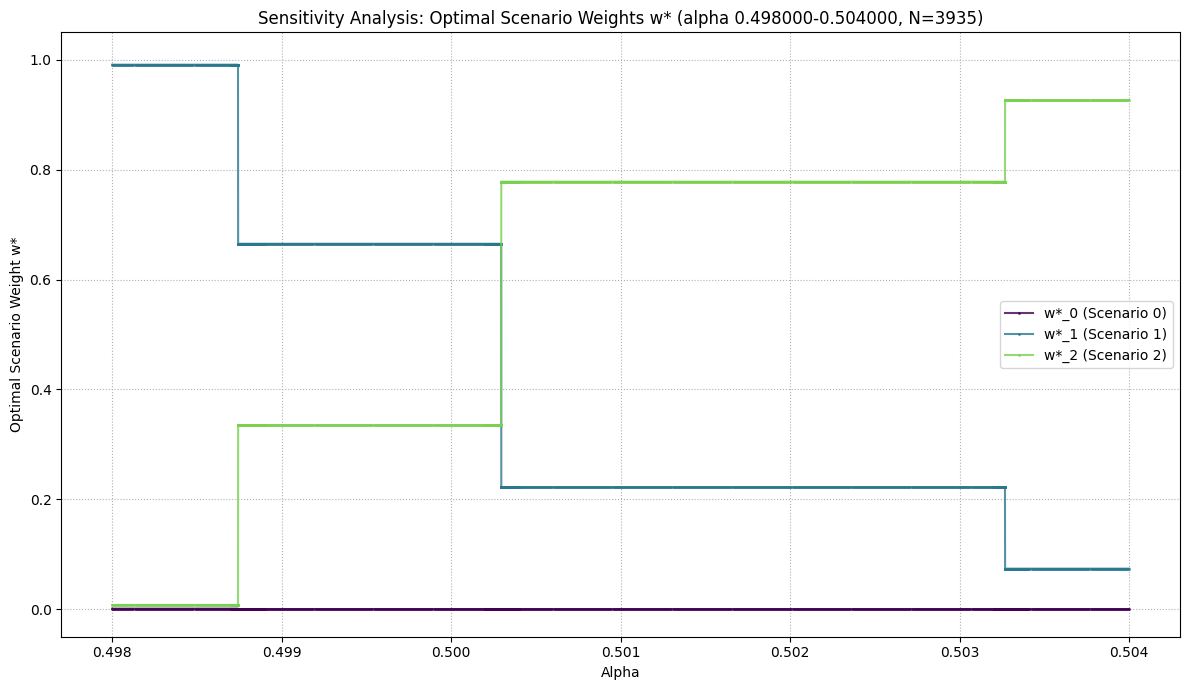

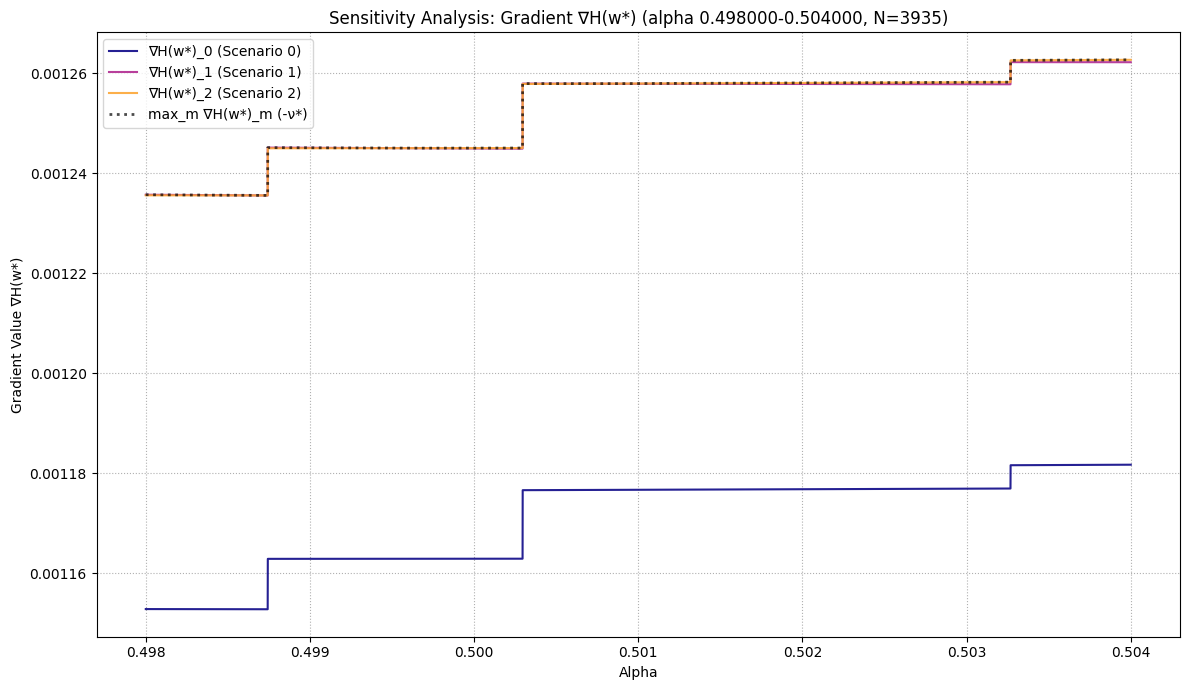

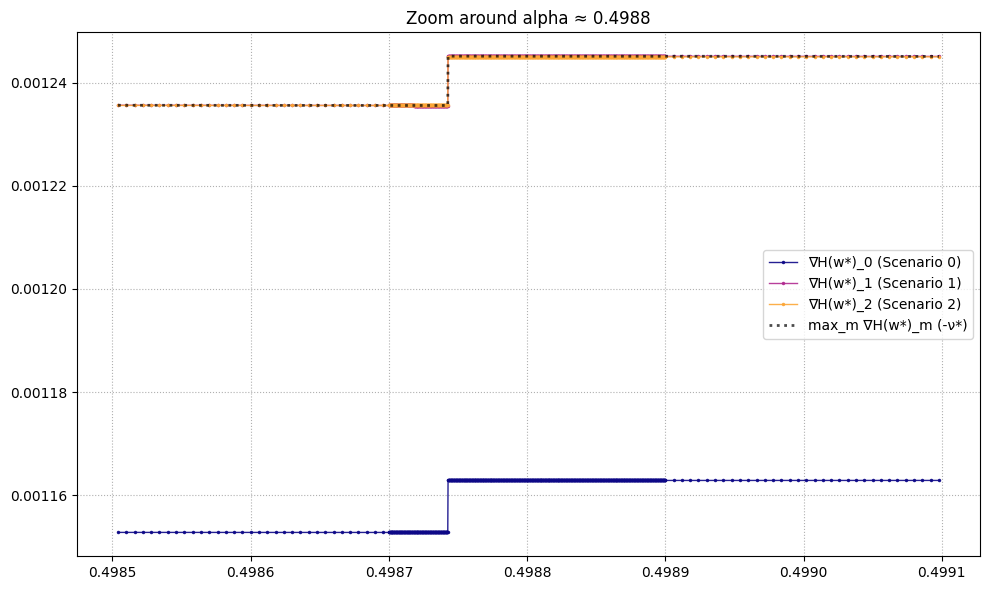

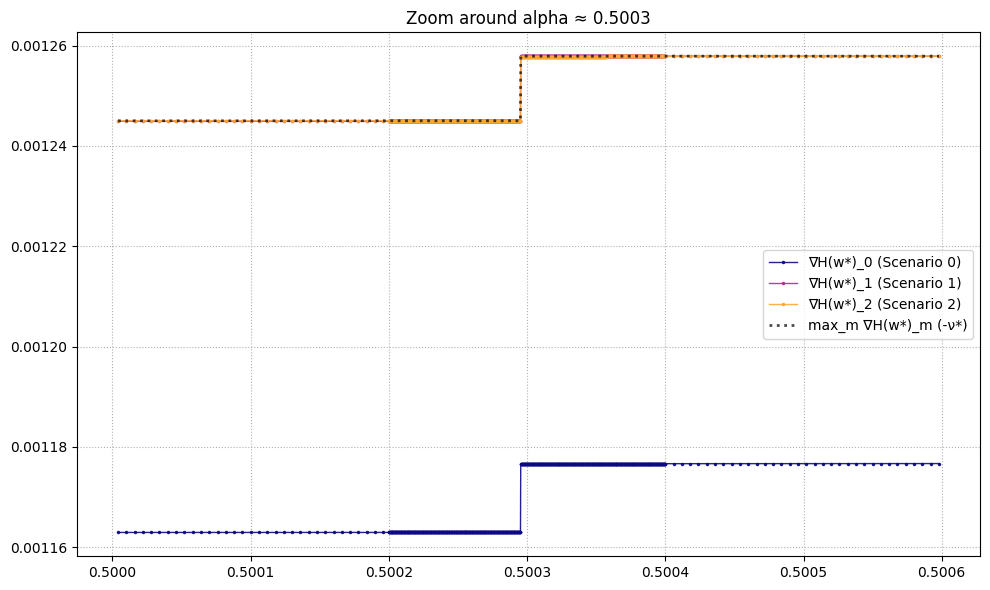

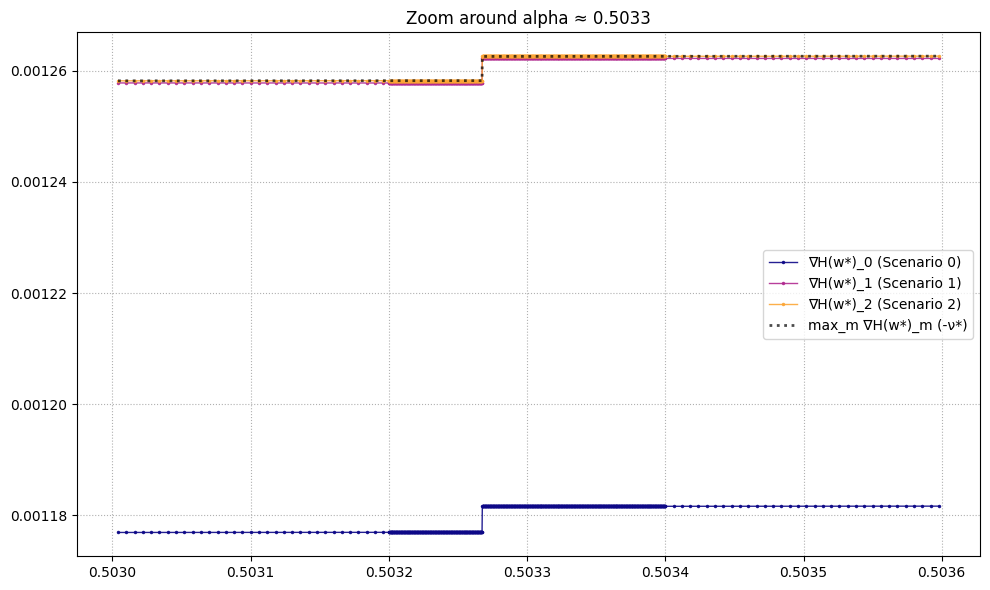

In [10]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy.linalg import solve, LinAlgError, lstsq
from scipy.optimize import linprog, OptimizeWarning
import traceback
import time

# 数値許容誤差のデフォルト値
DEFAULT_TOLERANCE = 1e-9

# --- OptimizationResult クラス ---
class OptimizationResult:
    def __init__(self, success, message, w_opt=None, pi_opt=None, lambda_opt=None, H_opt=None, grad_H_opt=None, iterations=None, fw_gap=None):
        self.success, self.message, self.w_opt, self.pi_opt, self.lambda_opt, self.H_opt = success, message, w_opt, pi_opt, lambda_opt, H_opt
        self.grad_H_opt = grad_H_opt
        self.iterations, self.fw_gap = iterations, fw_gap

# --- find_feasible_initial_pi 関数 ---
def find_feasible_initial_pi(R, mu_tilde, K, tolerance=1e-8):
    M = R.shape[1]; c = np.zeros(K + 1); c[K] = 1.0
    A_ub = np.hstack((-R.T, -np.ones((M, 1)))); b_ub = -mu_tilde * np.ones(M)
    bounds = [(None, None)] * K + [(0, None)]; opts = {'tol': tolerance, 'disp': False, 'presolve': True}
    result = None; methods_to_try = ['highs', 'highs-ipm', 'highs-ds', 'simplex']
    for method in methods_to_try:
        try:
            with warnings.catch_warnings(): warnings.filterwarnings("ignore", category=OptimizeWarning)
            result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method=method, options=opts)
            if result.success: break
        except ValueError: continue
        except Exception as e: return None, False, f"Phase 1 LP failed during {method}: {e}"
    if result is None or not result.success:
        msg = result.message if result else "No solver succeeded"; status = result.status if result else -1
        return None, False, f"Phase 1 LP solver failed after trying {methods_to_try}: {msg} (last status={status})"
    s = result.x[K]; pi = result.x[:K]
    if s <= tolerance * 100:
        G = -R.T; h = -mu_tilde * np.ones(M); violation = np.max(G @ pi - h)
        if violation <= tolerance * 1000: return pi, True, f"Phase 1 OK (s*={s:.1e}, max_vio={violation:.1e})"
        else: return pi, True, f"Phase 1 OK (s*={s:.1e}), but WARNING: Max violation {violation:.1e} > tol"
    else: return None, False, f"Phase 1 Infeasible (s* = {s:.1e} > 0)."

# --- solve_kkt_system 関数 ---
def solve_kkt_system(Q, G_W, g, tolerance=DEFAULT_TOLERANCE):
    K = Q.shape[0]; n_act = G_W.shape[0] if G_W is not None and G_W.ndim == 2 and G_W.shape[0] > 0 else 0
    if n_act == 0:
        try: p = solve(Q, -g, assume_a='sym'); l = []
        except LinAlgError: return None, None, False
        res_norm = np.linalg.norm(Q @ p + g); g_norm = np.linalg.norm(g); solved_ok = res_norm <= tolerance * 1e2 * (1 + g_norm)
        return p, l, solved_ok
    else:
        kkt_mat = None; rhs = None
        try:
          kkt_mat = np.block([[Q, G_W.T], [G_W, np.zeros((n_act, n_act))]])
          rhs = np.concatenate([-g, np.zeros(n_act)])
        except ValueError: return None, None, False
        try: sol = solve(kkt_mat, rhs, assume_a='sym'); p, l = sol[:K], sol[K:]
        except LinAlgError: return None, None, False
        res_norm = np.linalg.norm(kkt_mat @ sol - rhs); rhs_norm = np.linalg.norm(rhs); solved_ok = res_norm <= tolerance * 1e2 * (1 + rhs_norm)
        return p, l, solved_ok

# --- solve_inner_qp_active_set 関数 ---
# 引数名を max_iter, regularization_epsilon に修正
def solve_inner_qp_active_set(Vw, R, mu_tilde, initial_pi, max_iter=350, tolerance=DEFAULT_TOLERANCE, regularization_epsilon=1e-10):
    K = Vw.shape[0]; M = R.shape[1]; Q = 2 * Vw + 2 * regularization_epsilon * np.eye(K); G = -R.T; h = -mu_tilde * np.ones(M)
    if initial_pi is None: return None, None, False, "No initial pi provided."
    pi_k = np.copy(initial_pi); lam_opt = np.zeros(M); W = set()
    initial_violations = G @ pi_k - h
    W = set(j for j, viol in enumerate(initial_violations) if viol > -tolerance * 10)

    for i in range(max_iter):
        g_k = Q @ pi_k; act = sorted(list(W)); n_act = len(act); G_Wk = G[act, :] if n_act > 0 else np.empty((0, K))
        p_k, lam_Wk, solved = solve_kkt_system(Q, G_Wk, g_k, tolerance)
        if not solved or p_k is None:
            cond_Q = np.linalg.cond(Q) if K > 0 else np.nan; kkt_mat_info = f"Q cond={cond_Q:.2e}"
            if n_act > 0 and G_Wk.size > 0:
                try: kkt_mat = np.block([[Q, G_Wk.T], [G_Wk, np.zeros((n_act, n_act))]]) ;cond_kkt = np.linalg.cond(kkt_mat)
                except (LinAlgError, ValueError): cond_kkt = float('inf')
                try: svd_vals = np.linalg.svd(G_Wk, compute_uv=False); rank_tol = tolerance * max(G_Wk.shape) * svd_vals[0] if svd_vals.size > 0 else tolerance; rank_G_Wk = np.linalg.matrix_rank(G_Wk, tol=rank_tol)
                except LinAlgError: rank_G_Wk = -1
                kkt_mat_info += f", KKT cond={cond_kkt:.2e}, rank(G_Wk)={rank_G_Wk}/{n_act}"
            fail_reason = "KKT solve failed" if p_k is None else "KKT residual too large"; return None, None, False, f"QP fail:Iter {i+1}: {fail_reason} (reg={regularization_epsilon:.1e}). {kkt_mat_info}. ActiveSet={act}"
        if np.linalg.norm(p_k) <= tolerance * (1 + np.linalg.norm(pi_k)):
            is_optimal_point = True; blocking_constraint_idx = -1; min_negative_lambda = float('inf'); lambda_map = {}
            if W:
                if lam_Wk is None or len(lam_Wk) != n_act: return None, None, False, f"QP fail:Iter {i+1}: p_k small but lam_Wk inconsistent? ActiveSet={act}"
                lambda_map = dict(zip(act, lam_Wk))
                for constraint_idx, lagrange_multiplier in lambda_map.items():
                    if lagrange_multiplier < -tolerance: is_optimal_point = False;
                    if lagrange_multiplier < min_negative_lambda: min_negative_lambda = lagrange_multiplier; blocking_constraint_idx = constraint_idx
            if is_optimal_point:
                if W and len(lam_Wk) == n_act: lam_opt[act] = lam_Wk
                final_infeas = np.max(G @ pi_k - h); msg = f"Optimal found at iter {i+1} (reg={regularization_epsilon:.1e})."
                if final_infeas > tolerance * 10: msg += f" (WARN: small final violation {final_infeas:.1e})"
                return pi_k, lam_opt, True, msg
            else:
                if blocking_constraint_idx in W: W.remove(blocking_constraint_idx); continue
                else: return None, None, False, f"QP fail:Iter {i+1}: Neg lambda {min_negative_lambda:.1e} for idx {blocking_constraint_idx}, not in W={act}?"
        else:
            alpha_k = 1.0; blocking_constraint_idx = -1; min_step_length = float('inf')
            for j in range(M):
                if j not in W:
                    constraint_gradient_dot_p = G[j, :] @ p_k
                    if constraint_gradient_dot_p > tolerance:
                        distance_to_boundary = h[j] - (G[j, :] @ pi_k)
                        if distance_to_boundary >= -tolerance*10:
                            if abs(constraint_gradient_dot_p) > 1e-15:
                                alpha_j = distance_to_boundary / constraint_gradient_dot_p
                                if alpha_j >= -tolerance:
                                    step_j = max(0.0, alpha_j)
                                    if step_j < min_step_length:
                                        min_step_length = step_j
                                        blocking_constraint_idx = j
            alpha_k = min(1.0, min_step_length)
            pi_k += alpha_k * p_k
            if alpha_k < 1.0 - tolerance and blocking_constraint_idx != -1:
                if blocking_constraint_idx not in W: W.add(blocking_constraint_idx)
            continue
    # Max iterations reached
    msg = f"Max iter ({max_iter}) reached."; final_infeas = np.max(G @ pi_k - h)
    if final_infeas > tolerance * 100: return None, None, False, f"{msg} Final solution potentially infeasible (max violation: {final_infeas:.1e}). ActiveSet={sorted(list(W))}"
    g_k = Q @ pi_k; act=sorted(list(W)); n_act=len(act); G_Wk=G[act,:] if n_act>0 else np.empty((0,K));
    p_f, lam_f, solved_f = solve_kkt_system(Q, G_Wk, g_k, tolerance)
    final_lambda_estimate = np.zeros(M); is_likely_optimal = False
    if solved_f and p_f is not None and np.linalg.norm(p_f) <= tolerance * (1 + np.linalg.norm(pi_k)):
        if n_act > 0 and lam_f is not None and len(lam_f) == n_act:
             try: final_lambda_estimate[act] = lam_f
             except IndexError: pass
        active_lambdas = final_lambda_estimate[act] if n_act > 0 else np.array([])
        if n_act == 0 or np.all(active_lambdas >= -tolerance): is_likely_optimal = True; msg += " Final check suggests KKT satisfied (likely optimal)."
        else: neg_lam_indices = [idx for idx in act if final_lambda_estimate[idx] < -tolerance]; msg += f" Final check: KKT stationarity ok, but dual feasibility fails (neg lambda for {neg_lam_indices})."
    elif solved_f and p_f is not None: msg += f" Final check: KKT stationarity likely not met (||p_k||={np.linalg.norm(p_f):.1e} > tol)."
    else: msg += " Final check: KKT system solve failed at the end."
    if n_act > 0 and lam_f is not None and final_lambda_estimate is not None and len(final_lambda_estimate) == M and len(lam_f) == n_act:
        try: final_lambda_estimate[act] = lam_f
        except IndexError: pass
    return pi_k, final_lambda_estimate, is_likely_optimal, msg

# --- make_psd 関数 (変更なし) ---
def make_psd(matrix, tolerance=1e-8):
    sym = (matrix + matrix.T) / 2;
    try: eigenvalues, eigenvectors = np.linalg.eigh(sym); min_eigenvalue = np.min(eigenvalues)
    except LinAlgError: warnings.warn("make_psd: eigenvalue decomposition failed.", RuntimeWarning); return sym
    if min_eigenvalue < tolerance: eigenvalues[eigenvalues < tolerance] = tolerance; psd_matrix = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T; return (psd_matrix + psd_matrix.T) / 2
    else: return sym

# --- calculate_Vw 関数 (変更なし) ---
def calculate_Vw(w, R, SecondMomentMatrices, tolerance=DEFAULT_TOLERANCE, psd_tolerance=1e-8):
    K, M = R.shape; w_sum = np.sum(w)
    if not np.isclose(w_sum, 1.0) and w_sum > 0: w_norm = w / w_sum
    elif w_sum <= 0: w_norm = np.ones(M) / M
    else: w_norm = w
    w_norm = np.maximum(w_norm, 0); w_sum_final = np.sum(w_norm)
    if w_sum_final > 0 and not np.isclose(w_sum_final, 1.0): w_norm = w_norm / w_sum_final
    elif w_sum_final <= 0: w_norm = np.ones(M) / M
    EwX = R @ w_norm; EwXXT = np.zeros((K, K));
    for m in range(M): EwXXT += w_norm[m] * SecondMomentMatrices[m]
    Vw = EwXXT - np.outer(EwX, EwX); return make_psd(Vw, psd_tolerance), EwX, EwXXT

# --- calculate_H_gradient 関数 (変更なし) ---
def calculate_H_gradient(pi_star, w, R, SecondMomentMatrices, EwX, EwXXT, tolerance=1e-9):
    M = w.shape[0]; grad = np.zeros(M)
    if pi_star is None or np.linalg.norm(pi_star) < tolerance or EwX is None: return grad
    pi_T_EwX = pi_star.T @ EwX
    for j in range(M): grad[j] = pi_star.T @ SecondMomentMatrices[j] @ pi_star - 2 * (pi_star.T @ R[:, j]) * pi_T_EwX
    if np.any(np.isnan(grad)) or np.any(np.isinf(grad)): warnings.warn("NaN or Inf in H gradient. Returning zero vector.", RuntimeWarning); return np.zeros(M)
    return grad

# --- project_to_simplex 関数 (変更なし) ---
def project_to_simplex(v, z=1):
    n_features = v.shape[0];
    if n_features == 0: return np.array([])
    if np.all(v >= -1e-9) and np.isclose(np.sum(v), z): return np.maximum(v, 0)
    u = np.sort(v)[::-1]; cssv = np.cumsum(u) - z; ind = np.arange(n_features) + 1; cond = u - cssv / ind > 0
    if np.any(cond): rho = ind[cond][-1]; theta = cssv[rho - 1] / float(rho); w = np.maximum(v - theta, 0)
    else: w = np.zeros(n_features); w[np.argmax(v)] = z
    w_sum = np.sum(w);
    if not np.isclose(w_sum, z):
        if w_sum > 1e-9: w = w * (z / w_sum)
        else: w = np.zeros(n_features) if z == 0 else np.array([z] + [0]*(n_features-1))
    return w

# --- frank_wolfe_optimizer 関数 (変更なし) ---
def frank_wolfe_optimizer(R_alpha, SecondMomentMatrices_alpha, mu_tilde, initial_w=None, max_outer_iter=250, fw_gap_tol=1e-7, inner_max_iter=350, tolerance=1e-9, psd_make_tolerance=1e-8, qp_regularization=1e-10):
    K, M = R_alpha.shape; w_k = np.ones(M) / M if initial_w is None else project_to_simplex(np.copy(initial_w)); fw_gap = float('inf')
    best_w = np.copy(w_k); best_pi = None; best_lam = np.zeros(M); best_H = -float('inf'); final_gHk = np.zeros(M)
    pi0, ok, p1msg = find_feasible_initial_pi(R_alpha, mu_tilde, K, tolerance)
    if not ok: return OptimizationResult(False, f"Phase 1 failed: {p1msg}", w_opt=initial_w)
    for k in range(max_outer_iter):
        try: Vk, Ex, ExxT = calculate_Vw(w_k, R_alpha, SecondMomentMatrices_alpha, tolerance, psd_tolerance=psd_make_tolerance)
        except Exception as e: return OptimizationResult(False, f"Outer iter {k+1}: calculate_Vw failed: {e}\n{traceback.format_exc()}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        # ★ FW内の内側ソルバー呼び出し時の引数名も修正 ★
        pk, lk, inner_ok, inner_msg = solve_inner_qp_active_set(Vk, R_alpha, mu_tilde, pi0,
                                                                 max_iter=inner_max_iter, # inner_max_iter -> max_iter
                                                                 tolerance=tolerance,
                                                                 regularization_epsilon=qp_regularization) # qp_regularization -> regularization_epsilon
        if not inner_ok or pk is None: return OptimizationResult(False, f"Outer iter {k+1}: Inner QP failed: {inner_msg}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        Hk = pk.T @ Vk @ pk
        try: gHk = calculate_H_gradient(pk, w_k, R_alpha, SecondMomentMatrices_alpha, Ex, ExxT, tolerance)
        except Exception as e: return OptimizationResult(False, f"Outer iter {k+1}: Gradient calculation failed: {e}\n{traceback.format_exc()}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        final_gHk = gHk
        # Update best solution found so far
        # Use slightly larger tolerance for comparison to avoid numerical issues near optimum
        if Hk > best_H - tolerance*10:
             best_H = Hk; best_w = np.copy(w_k); best_pi = np.copy(pk)
             best_lam = np.copy(lk) if lk is not None else np.zeros(M)

        # Calculate the Frank-Wolfe gap
        sk_idx = np.argmax(gHk); sk = np.zeros(M); sk[sk_idx] = 1.0; fw_gap = gHk.T @ (sk - w_k)

        # Check convergence
        if fw_gap <= fw_gap_tol: return OptimizationResult(True, f"Converged (FW Gap={fw_gap:.2e} <= {fw_gap_tol:.1e})", w_opt=best_w, pi_opt=best_pi, lambda_opt=best_lam, H_opt=best_H, grad_H_opt=final_gHk, iterations=k + 1, fw_gap=fw_gap)
        if np.abs(fw_gap) < tolerance*10: # Use a slightly larger tolerance for near-zero check
            return OptimizationResult(True, f"Converged (FW Gap near zero: {fw_gap:.2e})", w_opt=best_w, pi_opt=best_pi, lambda_opt=best_lam, H_opt=best_H, grad_H_opt=final_gHk, iterations=k + 1, fw_gap=fw_gap)
        if fw_gap < -tolerance: warnings.warn(f"Outer iter {k+1}: Negative FW Gap ({fw_gap:.2e}).", RuntimeWarning)

        # Update step size and weights
        gamma = 2.0 / (k + 3.0); w_k = (1.0 - gamma) * w_k + gamma * sk; w_k = project_to_simplex(w_k);
        # Use the current QP solution as the warm start for the next iteration
        pi0 = pk
    # Max iter reached
    return OptimizationResult(True, f"Max Outer Iterations ({max_outer_iter}) reached", w_opt=best_w, pi_opt=best_pi, lambda_opt=best_lam, H_opt=best_H, grad_H_opt=final_gHk, iterations=max_outer_iter, fw_gap=fw_gap)

# --- generate_params_profile_switching 関数 (変更なし) ---
def generate_params_profile_switching(alpha, alpha_max, K=5, M=3,
    R_base=np.array([0.08, 0.07, 0.06, 0.05, 0.04]),
    sigma_base=np.array([0.18, 0.15, 0.20, 0.12, 0.10]),
    Corr_base=np.array([[1.0, 0.4, 0.3, 0.2, 0.1], [0.4, 1.0, 0.5, 0.3, 0.2], [0.3, 0.5, 1.0, 0.6, 0.4], [0.2, 0.3, 0.6, 1.0, 0.5], [0.1, 0.2, 0.4, 0.5, 1.0]]),
    good_prof_r_factor=0.05, good_prof_r_offset=0.002, good_prof_s_factor=-0.02, good_prof_corr_factor=1.0,
    bad_prof_r_factor=-0.02, bad_prof_r_offset=-0.001, bad_prof_s_factor=0.02, bad_prof_corr_offset=0.0,
    sigma_min_epsilon=1e-4, psd_tolerance=1e-9
):
    assert alpha >= 0 and K == len(R_base) and K == len(sigma_base) and K == Corr_base.shape[0] and M == 3
    non_diag_indices = np.where(~np.eye(K, dtype=bool))
    R_neutral = R_base; sigma_neutral = np.maximum(sigma_min_epsilon, sigma_base); Corr_neutral = make_psd(Corr_base, psd_tolerance)
    R_good = R_base + (R_base * good_prof_r_factor + good_prof_r_offset); sigma_good = np.maximum(sigma_min_epsilon, sigma_base + (sigma_base * good_prof_s_factor)); Corr_good_target = np.copy(Corr_base); Corr_good_target[non_diag_indices] *= good_prof_corr_factor; Corr_good = make_psd(Corr_good_target, psd_tolerance)
    R_bad = R_base + (R_base * bad_prof_r_factor + bad_prof_r_offset); sigma_bad = np.maximum(sigma_min_epsilon, sigma_base + (sigma_base * bad_prof_s_factor)); Corr_bad_target = np.copy(Corr_base); Corr_bad_target[non_diag_indices] = np.clip(Corr_bad_target[non_diag_indices] + bad_prof_corr_offset, -1.0+psd_tolerance, 1.0-psd_tolerance); Corr_bad = make_psd(Corr_bad_target, psd_tolerance)
    beta = np.clip(alpha / alpha_max if alpha_max > 0 else (1.0 if alpha > 0 else 0.0), 0.0, 1.0)
    R_alpha = np.zeros((K, M)); sigma_alpha = np.zeros((K, M)); Corr_alpha = [np.eye(K) for _ in range(M)]; Cov_alpha = [np.eye(K) for _ in range(M)]; SecondMoments_alpha = [np.eye(K) for _ in range(M)]
    R_alpha[:, 0] = (1 - beta) * R_good + beta * R_neutral; sigma_alpha[:, 0] = np.maximum(sigma_min_epsilon, (1 - beta) * sigma_good + beta * sigma_neutral); Corr_alpha[0] = make_psd((1 - beta) * Corr_good + beta * Corr_neutral, psd_tolerance)
    R_alpha[:, 1] = (1 - beta) * R_bad + beta * R_good; sigma_alpha[:, 1] = np.maximum(sigma_min_epsilon, (1 - beta) * sigma_bad + beta * sigma_good); Corr_alpha[1] = make_psd((1 - beta) * Corr_bad + beta * Corr_good, psd_tolerance)
    R_alpha[:, 2] = (1 - beta) * R_neutral + beta * R_bad; sigma_alpha[:, 2] = np.maximum(sigma_min_epsilon, (1 - beta) * sigma_neutral + beta * sigma_bad); Corr_alpha[2] = make_psd((1 - beta) * Corr_neutral + beta * Corr_bad, psd_tolerance)
    for m in range(M): sigma_diag_m = np.diag(sigma_alpha[:, m]); Cov_alpha[m] = sigma_diag_m @ Corr_alpha[m] @ sigma_diag_m; SecondMoments_alpha[m] = Cov_alpha[m] + np.outer(R_alpha[:, m], R_alpha[:, m])
    return R_alpha, SecondMoments_alpha

# === 数値微分計算関数 ===
def calculate_gradient_difference(w, alpha, R_a, SecondMoments_a, mu_tilde, initial_pi_inner, idx1=1, idx2=2, **inner_solver_kwargs):
    """ 指定された w における ∇H_idx1 - ∇H_idx2 を計算する """
    try:
        Vw_calc, EwX_calc, EwXXT_calc = calculate_Vw(w, R_a, SecondMoments_a)
        # ★ 引数名を修正: max_iter, regularization_epsilon ★
        pi_star_inner, _, inner_ok, inner_msg = solve_inner_qp_active_set(
            Vw_calc, R_a, mu_tilde, initial_pi_inner,
            max_iter=inner_solver_kwargs.get('max_iter', 350), # デフォルト値設定
            tolerance=inner_solver_kwargs.get('tolerance', DEFAULT_TOLERANCE),
            regularization_epsilon=inner_solver_kwargs.get('regularization_epsilon', 1e-10)
        )
        if not inner_ok or pi_star_inner is None:
            print(f"  Warning: Inner QP failed for w={w}. Msg: {inner_msg}")
            return np.nan
        grad_H_calc = calculate_H_gradient(pi_star_inner, w, R_a, SecondMoments_a, EwX_calc, EwXXT_calc)
        if grad_H_calc is not None and len(grad_H_calc) > max(idx1, idx2):
            return grad_H_calc[idx1] - grad_H_calc[idx2]
        else:
            print(f"  Warning: Gradient calculation failed or index out of bounds for w={w}")
            return np.nan
    except Exception as e:
        print(f"  Error during gradient difference calculation for w={w}: {e}\n{traceback.format_exc()}")
        return np.nan

# === 数値微分実行セクション ===
def run_numerical_differentiation(alpha_target=0.5003, delta_w=1e-6, **kwargs):
    """ 特定のalphaで数値微分を実行 """
    print(f"\n--- Running Numerical Differentiation for alpha = {alpha_target:.6f} ---")
    K = kwargs.get('K', 5); M = kwargs.get('M', 3); mu_tilde = kwargs.get('mu_tilde', 0.03)
    alpha_max = kwargs.get('alpha_max', 1.5)
    param_gen_kwargs = kwargs.get('param_gen_kwargs')
    optimizer_kwargs = kwargs.get('optimizer_kwargs')
    # ★ 内側ソルバー用のkwargsを正しく抽出 ★
    inner_solver_kwargs = {
        'max_iter': optimizer_kwargs.get('inner_max_iter', 400), # キー名を修正
        'tolerance': optimizer_kwargs.get('tolerance', DEFAULT_TOLERANCE),
        'regularization_epsilon': optimizer_kwargs.get('qp_regularization', 1e-8) # キー名を修正
    }

    try: R_target, SecondMoments_target = generate_params_profile_switching(alpha_target, **param_gen_kwargs)
    except Exception as e: print(f"  ERROR: Param gen failed: {e}"); return

    print("  Calculating base optimal solution w*...")
    result_base = frank_wolfe_optimizer(R_target, SecondMoments_target, mu_tilde, **optimizer_kwargs)
    if not result_base.success or result_base.w_opt is None or result_base.pi_opt is None or result_base.grad_H_opt is None:
        print(f"  ERROR: Base solution failed: {result_base.message}"); return

    w_star = result_base.w_opt; pi_star_base = result_base.pi_opt; grad_H_star = result_base.grad_H_opt
    G_base = grad_H_star[1] - grad_H_star[2]

    print(f"  Base w*: {w_star}"); print(f"  Base ∇H(w*): {grad_H_star}")
    print(f"  Base G = ∇H_1 - ∇H_2: {G_base:.12e}")

    # w1方向に摂動
    print(f"\n  Perturbing w1 by delta_w = {delta_w:.1e}")
    w_prime_w1 = np.copy(w_star); w_prime_w1[1] += delta_w; w_prime_w1[2] -= delta_w
    w_prime_w1 = project_to_simplex(w_prime_w1) # Simplexに射影
    print(f"  Perturbed w' (wrt w1): {w_prime_w1}")
    G_prime_w1 = calculate_gradient_difference(w_prime_w1, alpha_target, R_target, SecondMoments_target, mu_tilde, pi_star_base, idx1=1, idx2=2, **inner_solver_kwargs)
    if np.isnan(G_prime_w1): print("  Failed G'_w1 calc."); approx_deriv_w1 = np.nan
    else:
        print(f"  Perturbed G'_w1 = ∇H_1 - ∇H_2: {G_prime_w1:.12e}")
        approx_deriv_w1 = (G_prime_w1 - G_base) / delta_w
        print(f"  Approx ∂G/∂w_1 ≈ (G'_w1 - G_base) / delta_w = {approx_deriv_w1:.6e}")

    # w2方向に摂動
    print(f"\n  Perturbing w2 by delta_w = {delta_w:.1e}")
    w_prime_w2 = np.copy(w_star); w_prime_w2[2] += delta_w; w_prime_w2[1] -= delta_w
    w_prime_w2 = project_to_simplex(w_prime_w2)
    print(f"  Perturbed w' (wrt w2): {w_prime_w2}")
    G_prime_w2 = calculate_gradient_difference(w_prime_w2, alpha_target, R_target, SecondMoments_target, mu_tilde, pi_star_base, idx1=1, idx2=2, **inner_solver_kwargs)
    if np.isnan(G_prime_w2): print("  Failed G'_w2 calc."); approx_deriv_w2 = np.nan
    else:
        print(f"  Perturbed G'_w2 = ∇H_1 - ∇H_2: {G_prime_w2:.12e}")
        approx_deriv_w2 = (G_prime_w2 - G_base) / delta_w
        print(f"  Approx ∂G/∂w_2 ≈ (G'_w2 - G_base) / delta_w = {approx_deriv_w2:.6e}")

    print("--- Numerical Differentiation Finished ---")


# --- パラメトリックスタディ実行 ---
if __name__ == '__main__':
    start_time = time.time()
    # warningsフィルタ (変更なし)
    warnings.filterwarnings('ignore', category=RuntimeWarning, message=".*invalid value encountered.*")
    warnings.filterwarnings('ignore', category=UserWarning, message=".*Initial pi is slightly infeasible.*")
    warnings.filterwarnings('ignore', category=UserWarning, message=".*Solver terminated early.*")
    warnings.filterwarnings('ignore', category=UserWarning, message=".*Phase 1:.*failed.*")
    warnings.filterwarnings('ignore', category=OptimizeWarning)

    K = 5; M = 3; mu_tilde = 0.03; scenario_names = ["Scenario 0", "Scenario 1", "Scenario 2"]

    # === Alpha 値の設定 (変更なし) ===
    alpha_min_wide = 0.498; alpha_max_wide = 0.504; n_steps_wide = 1001
    transition_points = [0.4988, 0.5003, 0.5033]; zoom_radius = 0.0001; n_steps_zoom = 1001
    alpha_values_wide = np.linspace(alpha_min_wide, alpha_max_wide, n_steps_wide)
    alpha_values_zoom_list = []
    for center in transition_points:
        alpha_zoom = np.linspace(center - zoom_radius, center + zoom_radius, n_steps_zoom)
        alpha_values_zoom_list.append(alpha_zoom)
    all_alpha_values = np.concatenate([alpha_values_wide] + alpha_values_zoom_list)
    alpha_values = np.unique(all_alpha_values); alpha_values.sort()
    alpha_max = 1.5

    # === プロファイル作成用パラメータ (変更なし) ===
    profile_adjustments = {
        'good_prof_r_factor': 0.05,   'good_prof_r_offset': 0.002,
        'good_prof_s_factor': -0.02, 'good_prof_corr_factor': 1.0,
        'bad_prof_r_factor': -0.02, 'bad_prof_r_offset': -0.001,
        'bad_prof_s_factor': 0.02,  'bad_prof_corr_offset': 0.0,
    }
    param_gen_kwargs = {'K': K, 'M': M, 'alpha_max': alpha_max, **profile_adjustments}

    optimizer_kwargs = {'max_outer_iter': 250, 'fw_gap_tol': 1e-7, 'inner_max_iter': 400, 'tolerance': DEFAULT_TOLERANCE, 'psd_make_tolerance': 1e-8, 'qp_regularization': 1e-8}
    results_w, results_pi, results_H, results_grad_H, results_success, results_msg = [], [], [], [], [], []
    initial_w_guess = None

    # === 詳細を出力する Alpha 値のリスト (変更なし) ===
    target_alphas_for_details = [
        alpha_values[0], 0.4987, 0.4988, 0.4989, 0.5003,
        0.5032, 0.50325, 0.50329, 0.5033, 0.50331, 0.5034, alpha_values[-1]
    ]
    target_alphas_for_details = sorted(list(set(target_alphas_for_details)))
    print_detail_tolerance = 1e-5

    print(f"パラメトリックスタディ (M={M}, K={K}, mu_tilde={mu_tilde}, Profile Switching Trial 6 - High Resolution Scan)")
    print(f"alpha 範囲: {alpha_values[0]:.6f} to {alpha_values[-1]:.6f}, N={len(alpha_values)}")
    print(f"プロファイル調整値 (試行6): {profile_adjustments}"); print(f"Optimizer Kwargs: {optimizer_kwargs}")
    print(f"詳細を出力するAlpha値 (近傍): {target_alphas_for_details}")

    # === パラメトリックスタディループ (出力制御のみ) ===
    for i, alpha in enumerate(alpha_values):
        should_print_details = False
        for target_alpha in target_alphas_for_details:
            if abs(alpha - target_alpha) < print_detail_tolerance: should_print_details = True; break

        try: R_a, SecondMoments_a = generate_params_profile_switching(alpha, **param_gen_kwargs)
        except Exception as e:
            if should_print_details: print(f"\n--- alpha = {alpha:.6f} ({i+1}/{len(alpha_values)}) ---\n  ERROR: Param gen: {e}\n{traceback.format_exc()}")
            results_success.append(False); results_msg.append(f"Param gen error: {e}"); results_w.append(None); results_pi.append(None); results_H.append(np.nan); results_grad_H.append(None); initial_w_guess = None; continue

        try: result = frank_wolfe_optimizer(R_a, SecondMoments_a, mu_tilde, initial_w=initial_w_guess, **optimizer_kwargs)
        except Exception as e:
            if should_print_details: print(f"\n--- alpha = {alpha:.6f} ({i+1}/{len(alpha_values)}) ---\n  ERROR: Optimizer: {e}\n{traceback.format_exc()}")
            results_success.append(False); results_msg.append(f"Optimizer error: {e}"); results_w.append(None); results_pi.append(None); results_H.append(np.nan); results_grad_H.append(None); initial_w_guess = None; continue

        if should_print_details: # 詳細表示対象の場合のみ出力
            print(f"\n--- alpha = {alpha:.6f} ({i+1}/{len(alpha_values)}) ---")
            if result.success and result.w_opt is not None:
                print(f"  SUCCESS. H(w*)={result.H_opt:.12e}, FW Gap={result.fw_gap:.4e}, OuterIters={result.iterations}")
                w_disp = ", ".join([f"{w:.12f}" for w in result.w_opt])
                print(f"  Optimal w*: [{w_disp}]")
                if result.grad_H_opt is not None:
                     grad_disp = ", ".join([f"{g:.12e}" for g in result.grad_H_opt])
                     print(f"  Gradient∇H(w*): [{grad_disp}]")
                else: print("  Gradient∇H(w*): [N/A]")
            else: print(f"  FAILED/NO SOLUTION: {result.message}")

        # 結果格納は常に行う
        results_success.append(result.success); results_msg.append(result.message)
        if result.success and result.w_opt is not None:
            results_w.append(result.w_opt); results_pi.append(result.pi_opt); results_H.append(result.H_opt); results_grad_H.append(result.grad_H_opt); initial_w_guess = result.w_opt
        else:
            results_w.append(None); results_pi.append(None); results_H.append(np.nan); results_grad_H.append(None); initial_w_guess = None

    end_time = time.time()
    print(f"\nパラメトリックスタディ完了。所要時間: {end_time - start_time:.2f} 秒")

    # === 数値微分を実行 ===
    run_numerical_differentiation(
        alpha_target=0.5003, delta_w=1e-6, K=K, M=M, mu_tilde=mu_tilde, alpha_max=alpha_max,
        param_gen_kwargs=param_gen_kwargs, optimizer_kwargs=optimizer_kwargs
    )

    # === 結果の集計とプロット (変更なし) ===
    print("\n--- 結果の集計とプロット準備 ---")
    plot_alphas, valid_results_w, valid_results_H, valid_results_grad_H = [], [], [], []
    for idx, alpha in enumerate(alpha_values):
        if idx >= len(results_success): print(f"Warning: Missing results index {idx}"); continue
        success = results_success[idx]; w_res = results_w[idx] if idx < len(results_w) else None
        h_res = results_H[idx] if idx < len(results_H) else np.nan; grad_res = results_grad_H[idx] if idx < len(results_grad_H) else None
        if success and w_res is not None and h_res is not None and not np.isnan(h_res) and grad_res is not None:
             plot_alphas.append(alpha); valid_results_w.append(w_res); valid_results_H.append(h_res)
             if grad_res is not None: valid_results_grad_H.append(grad_res)
             else: valid_results_grad_H.append([np.nan] * M)

    # --- w* のプロット (変更なし) ---
    if plot_alphas and valid_results_w:
        valid_results_w_array = np.array(valid_results_w)
        fig_w, ax_w = plt.subplots(figsize=(12, 7)); colors_w = plt.cm.viridis(np.linspace(0, 0.8, M))
        for m in range(M): ax_w.plot(plot_alphas, valid_results_w_array[:, m], marker='.', linestyle='-', markersize=2, label=f'w*_{m} ({scenario_names[m]})', color=colors_w[m], alpha=0.8)
        ax_w.set_xlabel('Alpha'); ax_w.set_ylabel('Optimal Scenario Weight w*')
        if plot_alphas: ax_w.set_title(f'Sensitivity Analysis: Optimal Scenario Weights w* (alpha {plot_alphas[0]:.6f}-{plot_alphas[-1]:.6f}, N={len(plot_alphas)})')
        else: ax_w.set_title('Sensitivity Analysis: Optimal Scenario Weights w*')
        ax_w.legend(loc='best'); ax_w.grid(True, linestyle=':'); ax_w.set_ylim(-0.05, 1.05); fig_w.tight_layout()
    else: print("\nプロットする有効な結果(w*, H)がありませんでした。")

    # --- 勾配プロット (変更なし) ---
    if plot_alphas and valid_results_grad_H:
        valid_results_grad_array = np.array(valid_results_grad_H)
        fig2, ax_grad = plt.subplots(figsize=(12, 7)); colors_grad = plt.cm.plasma(np.linspace(0, 0.8, M))
        for m in range(M): ax_grad.plot(plot_alphas, valid_results_grad_array[:, m], marker=None, linestyle='-', label=f'∇H(w*)_{m} ({scenario_names[m]})', color=colors_grad[m], alpha=0.9, linewidth=1.5)
        try:
            if not np.all(np.isnan(valid_results_grad_array)):
                max_grad_values = np.nanmax(valid_results_grad_array, axis=1)
                if len(plot_alphas) == len(max_grad_values): ax_grad.plot(plot_alphas, max_grad_values, marker=None, linestyle=':', color='black', label='max_m ∇H(w*)_m (-ν*)', alpha=0.7, linewidth=2)
                else: print(f"Warning: Length mismatch plot_alphas/max_grad. Skipping max grad plot.")
            else: print("Warning: All grad values NaN. Skipping max grad plot.")
        except Exception as e: print(f"Warning: Plotting max_grad error: {e}")
        ax_grad.set_xlabel('Alpha'); ax_grad.set_ylabel('Gradient Value ∇H(w*)')
        if plot_alphas: ax_grad.set_title(f'Sensitivity Analysis: Gradient ∇H(w*) (alpha {plot_alphas[0]:.6f}-{plot_alphas[-1]:.6f}, N={len(plot_alphas)})')
        else: ax_grad.set_title(f'Sensitivity Analysis: Gradient ∇H(w*)')
        ax_grad.legend(loc='best'); ax_grad.grid(True, linestyle=':'); fig2.tight_layout()

        # --- Zoom プロット (デバッグコード含む) ---
        plot_alphas_array = np.array(plot_alphas) # Ensure it's an array for boolean indexing

        # Zoom 1
        zoom_center_1 = 0.4988; zoom_radius_plot = 0.0003
        zoom_indices_1 = (plot_alphas_array >= zoom_center_1 - zoom_radius_plot) & (plot_alphas_array <= zoom_center_1 + zoom_radius_plot)
        print(f"\n--- Debugging Zoom Plot for alpha ≈ {zoom_center_1} ---"); print(f"Num points: {np.sum(zoom_indices_1)}")
        if np.any(zoom_indices_1):
            fig_zoom1, ax_zoom1 = plt.subplots(figsize=(10, 6))
            # ... (プロットコードとエラーチェック, 前回答参照) ...
            for m in range(M):
                if zoom_indices_1.shape[0] == valid_results_grad_array.shape[0]:
                    y_data=valid_results_grad_array[zoom_indices_1, m]; x_data=plot_alphas_array[zoom_indices_1]
                    if x_data.shape[0]==y_data.shape[0] and not np.isnan(y_data).all(): ax_zoom1.plot(x_data, y_data, marker='.', markersize=3, linestyle='-', label=f'∇H(w*)_{m} ({scenario_names[m]})', color=colors_grad[m], alpha=0.9, linewidth=1)
                else: print(f"Error Zoom1: Shape mismatch")
            try:
                if ('max_grad_values' in locals() and zoom_indices_1.shape[0] == max_grad_values.shape[0]):
                     max_grad_zoom = max_grad_values[zoom_indices_1]
                     if not np.isnan(max_grad_zoom).all(): ax_zoom1.plot(plot_alphas_array[zoom_indices_1], max_grad_zoom, marker=None, linestyle=':', color='black', label='max_m ∇H(w*)_m (-ν*)', alpha=0.7, linewidth=2)
            except Exception as e: print(f"Warning Zoom1: Plotting max_grad error: {e}")
            ax_zoom1.set_title(f'Zoom around alpha ≈ {zoom_center_1}'); handles, labels = ax_zoom1.get_legend_handles_labels();
            if handles: ax_zoom1.legend(loc='best')
            ax_zoom1.grid(True, linestyle=':'); fig_zoom1.tight_layout()
        else: print(f"Skipping empty plot for Zoom {zoom_center_1}")
        print("--- End Debugging Zoom Plot ---")

        # Zoom 2
        zoom_center_2 = 0.5003
        zoom_indices_2 = (plot_alphas_array >= zoom_center_2 - zoom_radius_plot) & (plot_alphas_array <= zoom_center_2 + zoom_radius_plot)
        print(f"\n--- Debugging Zoom Plot for alpha ≈ {zoom_center_2} ---"); print(f"Num points: {np.sum(zoom_indices_2)}")
        if np.any(zoom_indices_2):
             fig_zoom2, ax_zoom2 = plt.subplots(figsize=(10, 6))
             # ... (プロットコードとエラーチェック, 前回答参照) ...
             for m in range(M):
                 if zoom_indices_2.shape[0] == valid_results_grad_array.shape[0]:
                     y_data=valid_results_grad_array[zoom_indices_2, m]; x_data=plot_alphas_array[zoom_indices_2]
                     print(f"  Plotting m={m}: x_data shape={x_data.shape}, y_data shape={y_data.shape}, All NaNs={np.isnan(y_data).all()}")
                     if x_data.shape[0]==y_data.shape[0] and not np.isnan(y_data).all(): ax_zoom2.plot(x_data, y_data, marker='.', markersize=3, linestyle='-', label=f'∇H(w*)_{m} ({scenario_names[m]})', color=colors_grad[m], alpha=0.9, linewidth=1)
                 else: print(f"  Error Zoom2: Shape mismatch")
             try:
                 if ('max_grad_values' in locals() and zoom_indices_2.shape[0] == max_grad_values.shape[0]):
                      max_grad_zoom = max_grad_values[zoom_indices_2]
                      print(f"  Plotting max_grad: shape={max_grad_zoom.shape}, All NaNs={np.isnan(max_grad_zoom).all()}")
                      if not np.isnan(max_grad_zoom).all(): ax_zoom2.plot(plot_alphas_array[zoom_indices_2], max_grad_zoom, marker=None, linestyle=':', color='black', label='max_m ∇H(w*)_m (-ν*)', alpha=0.7, linewidth=2)
                      else: print("  Warning Zoom2: All max_grad NaN")
                 elif 'max_grad_values' not in locals(): print("  Warning Zoom2: max_grad_values not defined.")
                 else: print(f"  Warning Zoom2: Length mismatch max_grad")
             except Exception as e: print(f"  Warning Zoom2: Plotting max_grad error: {e}")
             ax_zoom2.set_title(f'Zoom around alpha ≈ {zoom_center_2}'); handles, labels = ax_zoom2.get_legend_handles_labels();
             if handles: ax_zoom2.legend(loc='best')
             ax_zoom2.grid(True, linestyle=':'); fig_zoom2.tight_layout()
        else: print(f"Skipping empty plot for Zoom {zoom_center_2}")
        print("--- End Debugging Zoom Plot ---")

        # Zoom 3
        zoom_center_3 = 0.5033
        zoom_indices_3 = (plot_alphas_array >= zoom_center_3 - zoom_radius_plot) & (plot_alphas_array <= zoom_center_3 + zoom_radius_plot)
        print(f"\n--- Debugging Zoom Plot for alpha ≈ {zoom_center_3} ---"); print(f"Num points: {np.sum(zoom_indices_3)}")
        if np.any(zoom_indices_3):
            fig_zoom3, ax_zoom3 = plt.subplots(figsize=(10, 6))
            # ... (プロットコードとエラーチェック, 前回答参照) ...
            for m in range(M):
                if zoom_indices_3.shape[0] == valid_results_grad_array.shape[0]:
                    y_data=valid_results_grad_array[zoom_indices_3, m]; x_data=plot_alphas_array[zoom_indices_3]
                    print(f"  Plotting m={m}: x_data shape={x_data.shape}, y_data shape={y_data.shape}, All NaNs={np.isnan(y_data).all()}")
                    if x_data.shape[0]==y_data.shape[0] and not np.isnan(y_data).all(): ax_zoom3.plot(x_data, y_data, marker='.', markersize=3, linestyle='-', label=f'∇H(w*)_{m} ({scenario_names[m]})', color=colors_grad[m], alpha=0.9, linewidth=1)
                else: print(f"Error Zoom3: Shape mismatch")
            try:
                if ('max_grad_values' in locals() and zoom_indices_3.shape[0] == max_grad_values.shape[0]):
                     max_grad_zoom = max_grad_values[zoom_indices_3]
                     print(f"  Plotting max_grad: shape={max_grad_zoom.shape}, All NaNs={np.isnan(max_grad_zoom).all()}")
                     if not np.isnan(max_grad_zoom).all(): ax_zoom3.plot(plot_alphas_array[zoom_indices_3], max_grad_zoom, marker=None, linestyle=':', color='black', label='max_m ∇H(w*)_m (-ν*)', alpha=0.7, linewidth=2)
                     else: print("  Warning Zoom3: All max_grad NaN")
                elif 'max_grad_values' not in locals(): print("  Warning Zoom3: max_grad_values not defined.")
                else: print(f"  Warning Zoom3: Length mismatch max_grad")
            except Exception as e: print(f"  Warning Zoom3: Plotting max_grad error: {e}")
            ax_zoom3.set_title(f'Zoom around alpha ≈ {zoom_center_3}'); handles, labels = ax_zoom3.get_legend_handles_labels();
            if handles: ax_zoom3.legend(loc='best')
            ax_zoom3.grid(True, linestyle=':'); fig_zoom3.tight_layout()
        else: print(f"Skipping empty plot for Zoom {zoom_center_3}")
        print("--- End Debugging Zoom Plot ---")

        plt.show()

    else: print("\nプロットする有効な結果(∇H)がありませんでした。")

In [12]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy.linalg import solve, LinAlgError, lstsq
from scipy.optimize import linprog, OptimizeWarning
import traceback
import time

# 数値許容誤差のデフォルト値
DEFAULT_TOLERANCE = 1e-9

# --- OptimizationResult クラス ---
class OptimizationResult:
    def __init__(self, success, message, w_opt=None, pi_opt=None, lambda_opt=None, H_opt=None, grad_H_opt=None, iterations=None, fw_gap=None):
        self.success, self.message, self.w_opt, self.pi_opt, self.lambda_opt, self.H_opt = success, message, w_opt, pi_opt, lambda_opt, H_opt
        self.grad_H_opt = grad_H_opt
        self.iterations, self.fw_gap = iterations, fw_gap

# --- find_feasible_initial_pi 関数 ---
def find_feasible_initial_pi(R, mu_tilde, K, tolerance=1e-8):
    M = R.shape[1]; c = np.zeros(K + 1); c[K] = 1.0
    A_ub = np.hstack((-R.T, -np.ones((M, 1)))); b_ub = -mu_tilde * np.ones(M)
    bounds = [(None, None)] * K + [(0, None)]; opts = {'tol': tolerance, 'disp': False, 'presolve': True}
    result = None; methods_to_try = ['highs', 'highs-ipm', 'highs-ds', 'simplex']
    for method in methods_to_try:
        try:
            with warnings.catch_warnings(): warnings.filterwarnings("ignore", category=OptimizeWarning)
            result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method=method, options=opts)
            if result.success: break
        except ValueError: continue
        except Exception as e: return None, False, f"Phase 1 LP failed during {method}: {e}"
    if result is None or not result.success:
        msg = result.message if result else "No solver succeeded"; status = result.status if result else -1
        return None, False, f"Phase 1 LP solver failed after trying {methods_to_try}: {msg} (last status={status})"
    s = result.x[K]; pi = result.x[:K]
    if s <= tolerance * 100:
        G = -R.T; h = -mu_tilde * np.ones(M); violation = np.max(G @ pi - h)
        if violation <= tolerance * 1000: return pi, True, f"Phase 1 OK (s*={s:.1e}, max_vio={violation:.1e})"
        else: return pi, True, f"Phase 1 OK (s*={s:.1e}), but WARNING: Max violation {violation:.1e} > tol"
    else: return None, False, f"Phase 1 Infeasible (s* = {s:.1e} > 0)."

# --- solve_kkt_system 関数 ---
def solve_kkt_system(Q, G_W, g, tolerance=DEFAULT_TOLERANCE):
    K = Q.shape[0]; n_act = G_W.shape[0] if G_W is not None and G_W.ndim == 2 and G_W.shape[0] > 0 else 0
    if n_act == 0:
        try: p = solve(Q, -g, assume_a='sym'); l = []
        except LinAlgError: return None, None, False
        res_norm = np.linalg.norm(Q @ p + g); g_norm = np.linalg.norm(g); solved_ok = res_norm <= tolerance * 1e2 * (1 + g_norm)
        return p, l, solved_ok
    else:
        kkt_mat = None; rhs = None
        try:
          kkt_mat = np.block([[Q, G_W.T], [G_W, np.zeros((n_act, n_act))]])
          rhs = np.concatenate([-g, np.zeros(n_act)])
        except ValueError: return None, None, False
        try: sol = solve(kkt_mat, rhs, assume_a='sym'); p, l = sol[:K], sol[K:]
        except LinAlgError: return None, None, False
        res_norm = np.linalg.norm(kkt_mat @ sol - rhs); rhs_norm = np.linalg.norm(rhs); solved_ok = res_norm <= tolerance * 1e2 * (1 + rhs_norm)
        return p, l, solved_ok

# --- solve_inner_qp_active_set 関数 ---
def solve_inner_qp_active_set(Vw, R, mu_tilde, initial_pi, max_iter=350, tolerance=DEFAULT_TOLERANCE, regularization_epsilon=1e-10):
    K = Vw.shape[0]; M = R.shape[1]; Q = 2 * Vw + 2 * regularization_epsilon * np.eye(K); G = -R.T; h = -mu_tilde * np.ones(M)
    if initial_pi is None: return None, None, False, "No initial pi provided."
    pi_k = np.copy(initial_pi); lam_opt = np.zeros(M); W = set()
    initial_violations = G @ pi_k - h
    W = set(j for j, viol in enumerate(initial_violations) if viol > -tolerance * 10)

    for i in range(max_iter):
        g_k = Q @ pi_k; act = sorted(list(W)); n_act = len(act); G_Wk = G[act, :] if n_act > 0 else np.empty((0, K))
        p_k, lam_Wk, solved = solve_kkt_system(Q, G_Wk, g_k, tolerance)
        if not solved or p_k is None:
            cond_Q = np.linalg.cond(Q) if K > 0 else np.nan; kkt_mat_info = f"Q cond={cond_Q:.2e}"
            if n_act > 0 and G_Wk.size > 0:
                try: kkt_mat = np.block([[Q, G_Wk.T], [G_Wk, np.zeros((n_act, n_act))]]) ;cond_kkt = np.linalg.cond(kkt_mat)
                except (LinAlgError, ValueError): cond_kkt = float('inf')
                try: svd_vals = np.linalg.svd(G_Wk, compute_uv=False); rank_tol = tolerance * max(G_Wk.shape) * svd_vals[0] if svd_vals.size > 0 else tolerance; rank_G_Wk = np.linalg.matrix_rank(G_Wk, tol=rank_tol)
                except LinAlgError: rank_G_Wk = -1
                kkt_mat_info += f", KKT cond={cond_kkt:.2e}, rank(G_Wk)={rank_G_Wk}/{n_act}"
            fail_reason = "KKT solve failed" if p_k is None else "KKT residual too large"; return None, None, False, f"QP fail:Iter {i+1}: {fail_reason} (reg={regularization_epsilon:.1e}). {kkt_mat_info}. ActiveSet={act}"
        if np.linalg.norm(p_k) <= tolerance * (1 + np.linalg.norm(pi_k)):
            is_optimal_point = True; blocking_constraint_idx = -1; min_negative_lambda = float('inf'); lambda_map = {}
            if W:
                if lam_Wk is None or len(lam_Wk) != n_act: return None, None, False, f"QP fail:Iter {i+1}: p_k small but lam_Wk inconsistent? ActiveSet={act}"
                lambda_map = dict(zip(act, lam_Wk))
                for constraint_idx, lagrange_multiplier in lambda_map.items():
                    if lagrange_multiplier < -tolerance: is_optimal_point = False;
                    if lagrange_multiplier < min_negative_lambda: min_negative_lambda = lagrange_multiplier; blocking_constraint_idx = constraint_idx
            if is_optimal_point:
                if W and len(lam_Wk) == n_act: lam_opt[act] = lam_Wk
                final_infeas = np.max(G @ pi_k - h); msg = f"Optimal found at iter {i+1} (reg={regularization_epsilon:.1e})."
                if final_infeas > tolerance * 10: msg += f" (WARN: small final violation {final_infeas:.1e})"
                return pi_k, lam_opt, True, msg
            else:
                if blocking_constraint_idx in W: W.remove(blocking_constraint_idx); continue
                else: return None, None, False, f"QP fail:Iter {i+1}: Neg lambda {min_negative_lambda:.1e} for idx {blocking_constraint_idx}, not in W={act}?"
        else:
            alpha_k = 1.0; blocking_constraint_idx = -1; min_step_length = float('inf')
            for j in range(M):
                if j not in W:
                    constraint_gradient_dot_p = G[j, :] @ p_k
                    if constraint_gradient_dot_p > tolerance:
                        distance_to_boundary = h[j] - (G[j, :] @ pi_k)
                        if distance_to_boundary >= -tolerance*10:
                            if abs(constraint_gradient_dot_p) > 1e-15:
                                alpha_j = distance_to_boundary / constraint_gradient_dot_p
                                if alpha_j >= -tolerance:
                                    step_j = max(0.0, alpha_j)
                                    if step_j < min_step_length:
                                        min_step_length = step_j
                                        blocking_constraint_idx = j
            alpha_k = min(1.0, min_step_length)
            pi_k += alpha_k * p_k
            if alpha_k < 1.0 - tolerance and blocking_constraint_idx != -1:
                if blocking_constraint_idx not in W: W.add(blocking_constraint_idx)
            continue
    # Max iterations reached
    msg = f"Max iter ({max_iter}) reached."; final_infeas = np.max(G @ pi_k - h)
    if final_infeas > tolerance * 100: return None, None, False, f"{msg} Final solution potentially infeasible (max violation: {final_infeas:.1e}). ActiveSet={sorted(list(W))}"
    g_k = Q @ pi_k; act=sorted(list(W)); n_act=len(act); G_Wk=G[act,:] if n_act>0 else np.empty((0,K));
    p_f, lam_f, solved_f = solve_kkt_system(Q, G_Wk, g_k, tolerance)
    final_lambda_estimate = np.zeros(M); is_likely_optimal = False
    if solved_f and p_f is not None and np.linalg.norm(p_f) <= tolerance * (1 + np.linalg.norm(pi_k)):
        if n_act > 0 and lam_f is not None and len(lam_f) == n_act:
             try: final_lambda_estimate[act] = lam_f
             except IndexError: pass
        active_lambdas = final_lambda_estimate[act] if n_act > 0 else np.array([])
        if n_act == 0 or np.all(active_lambdas >= -tolerance): is_likely_optimal = True; msg += " Final check suggests KKT satisfied (likely optimal)."
        else: neg_lam_indices = [idx for idx in act if final_lambda_estimate[idx] < -tolerance]; msg += f" Final check: KKT stationarity ok, but dual feasibility fails (neg lambda for {neg_lam_indices})."
    elif solved_f and p_f is not None: msg += f" Final check: KKT stationarity likely not met (||p_k||={np.linalg.norm(p_f):.1e} > tol)."
    else: msg += " Final check: KKT system solve failed at the end."
    if n_act > 0 and lam_f is not None and final_lambda_estimate is not None and len(final_lambda_estimate) == M and len(lam_f) == n_act:
        try: final_lambda_estimate[act] = lam_f
        except IndexError: pass
    return pi_k, final_lambda_estimate, is_likely_optimal, msg

# --- make_psd 関数 (変更なし) ---
def make_psd(matrix, tolerance=1e-8):
    sym = (matrix + matrix.T) / 2;
    try: eigenvalues, eigenvectors = np.linalg.eigh(sym); min_eigenvalue = np.min(eigenvalues)
    except LinAlgError: warnings.warn("make_psd: eigenvalue decomposition failed.", RuntimeWarning); return sym
    if min_eigenvalue < tolerance: eigenvalues[eigenvalues < tolerance] = tolerance; psd_matrix = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T; return (psd_matrix + psd_matrix.T) / 2
    else: return sym

# --- calculate_Vw 関数 (変更なし) ---
def calculate_Vw(w, R, SecondMomentMatrices, tolerance=DEFAULT_TOLERANCE, psd_tolerance=1e-8):
    K, M = R.shape; w_sum = np.sum(w)
    if not np.isclose(w_sum, 1.0) and w_sum > 0: w_norm = w / w_sum
    elif w_sum <= 0: w_norm = np.ones(M) / M
    else: w_norm = w
    w_norm = np.maximum(w_norm, 0); w_sum_final = np.sum(w_norm)
    if w_sum_final > 0 and not np.isclose(w_sum_final, 1.0): w_norm = w_norm / w_sum_final
    elif w_sum_final <= 0: w_norm = np.ones(M) / M
    EwX = R @ w_norm; EwXXT = np.zeros((K, K));
    for m in range(M): EwXXT += w_norm[m] * SecondMomentMatrices[m]
    Vw = EwXXT - np.outer(EwX, EwX); return make_psd(Vw, psd_tolerance), EwX, EwXXT

# --- calculate_H_gradient 関数 (変更なし) ---
def calculate_H_gradient(pi_star, w, R, SecondMomentMatrices, EwX, EwXXT, tolerance=1e-9):
    M = w.shape[0]; grad = np.zeros(M)
    if pi_star is None or np.linalg.norm(pi_star) < tolerance or EwX is None: return grad
    pi_T_EwX = pi_star.T @ EwX
    for j in range(M): grad[j] = pi_star.T @ SecondMomentMatrices[j] @ pi_star - 2 * (pi_star.T @ R[:, j]) * pi_T_EwX
    if np.any(np.isnan(grad)) or np.any(np.isinf(grad)): warnings.warn("NaN or Inf in H gradient. Returning zero vector.", RuntimeWarning); return np.zeros(M)
    return grad

# --- project_to_simplex 関数 (修正: Noneチェック追加) ---
def project_to_simplex(v, z=1):
    n_features = v.shape[0];
    if n_features == 0: return np.array([])
    # Ensure v is a numpy array
    v_arr = np.asarray(v)
    if np.all(v_arr >= -1e-9) and np.isclose(np.sum(v_arr), z):
         # ★ Return max(0) instead of potentially modifying input inplace ★
         return np.maximum(v_arr, 0)
    u = np.sort(v_arr)[::-1]; cssv = np.cumsum(u) - z; ind = np.arange(n_features) + 1; cond = u - cssv / ind > 0
    if np.any(cond): rho = ind[cond][-1]; theta = cssv[rho - 1] / float(rho); w = np.maximum(v_arr - theta, 0)
    else: w = np.zeros(n_features); w[np.argmax(v_arr)] = z
    # ★ None チェック追加 (万が一のため) ★
    if w is None:
        warnings.warn("project_to_simplex resulted in None, returning uniform weights.")
        return np.ones(n_features) / n_features if n_features > 0 else np.array([])
    w_sum = np.sum(w);
    if not np.isclose(w_sum, z):
        if w_sum > 1e-9: w = w * (z / w_sum)
        else: w = np.zeros(n_features) if z == 0 else np.array([z] + [0]*(n_features-1))
         # ★ 再度Noneチェック ★
        if w is None:
             warnings.warn("project_to_simplex resulted in None after norm, returning uniform weights.")
             return np.ones(n_features) / n_features if n_features > 0 else np.array([])
    return w

# --- frank_wolfe_optimizer 関数 (修正済み) ---
def frank_wolfe_optimizer(R_alpha, SecondMomentMatrices_alpha, mu_tilde, initial_w=None, max_outer_iter=250, fw_gap_tol=1e-7, inner_max_iter=350, tolerance=1e-9, psd_make_tolerance=1e-8, qp_regularization=1e-10):
    K, M = R_alpha.shape
    # Initialize w_k: Ensure initial_w is projected if provided
    w_k = np.ones(M) / M if initial_w is None else project_to_simplex(np.copy(initial_w))
    if w_k is None: # Check after initial projection
        return OptimizationResult(False, "Initial projection failed", w_opt=initial_w)

    fw_gap = float('inf')
    best_w = np.copy(w_k); best_pi = None; best_lam = np.zeros(M); best_H = -float('inf'); final_gHk = np.zeros(M)

    pi0, ok, p1msg = find_feasible_initial_pi(R_alpha, mu_tilde, K, tolerance)
    if not ok: return OptimizationResult(False, f"Phase 1 failed: {p1msg}", w_opt=initial_w)

    for k in range(max_outer_iter):
        try: Vk, Ex, ExxT = calculate_Vw(w_k, R_alpha, SecondMomentMatrices_alpha, tolerance, psd_tolerance=psd_make_tolerance)
        except Exception as e: return OptimizationResult(False, f"Outer iter {k+1}: calculate_Vw failed: {e}\n{traceback.format_exc()}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)

        pk, lk, inner_ok, inner_msg = solve_inner_qp_active_set(Vk, R_alpha, mu_tilde, pi0,
                                                                 max_iter=inner_max_iter,
                                                                 tolerance=tolerance,
                                                                 regularization_epsilon=qp_regularization)
        if not inner_ok or pk is None: return OptimizationResult(False, f"Outer iter {k+1}: Inner QP failed: {inner_msg}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        Hk = pk.T @ Vk @ pk
        try: gHk = calculate_H_gradient(pk, w_k, R_alpha, SecondMomentMatrices_alpha, Ex, ExxT, tolerance)
        except Exception as e: return OptimizationResult(False, f"Outer iter {k+1}: Gradient calculation failed: {e}\n{traceback.format_exc()}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        final_gHk = gHk

        if Hk > best_H - tolerance*10:
             best_H = Hk; best_w = np.copy(w_k); best_pi = np.copy(pk)
             best_lam = np.copy(lk) if lk is not None else np.zeros(M)

        sk_idx = np.argmax(gHk); sk = np.zeros(M); sk[sk_idx] = 1.0; fw_gap = gHk.T @ (sk - w_k)
        if fw_gap <= fw_gap_tol: return OptimizationResult(True, f"Converged (FW Gap={fw_gap:.2e} <= {fw_gap_tol:.1e})", w_opt=best_w, pi_opt=best_pi, lambda_opt=best_lam, H_opt=best_H, grad_H_opt=final_gHk, iterations=k + 1, fw_gap=fw_gap)
        if np.abs(fw_gap) < tolerance*10: return OptimizationResult(True, f"Converged (FW Gap near zero: {fw_gap:.2e})", w_opt=best_w, pi_opt=best_pi, lambda_opt=best_lam, H_opt=best_H, grad_H_opt=final_gHk, iterations=k + 1, fw_gap=fw_gap)
        if fw_gap < -tolerance: warnings.warn(f"Outer iter {k+1}: Negative FW Gap ({fw_gap:.2e}).", RuntimeWarning)

        gamma = 2.0 / (k + 3.0)
        # === ★ None チェック追加 ★ ===
        if w_k is None:
            print(f"ERROR: w_k is None before update at iteration k={k}")
            return OptimizationResult(False, f"Internal error: w_k became None at k={k}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        if sk is None:
             print(f"ERROR: sk is None before update at iteration k={k}")
             return OptimizationResult(False, f"Internal error: sk became None at k={k}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        # === ★ チェックここまで ★ ===
        w_k_next = (1.0 - gamma) * w_k + gamma * sk # 計算結果を一時変数に
        w_k = project_to_simplex(w_k_next) # project_to_simplexに渡す前に計算

        # === ★ 再度Noneチェック ★ ===
        if w_k is None:
             print(f"ERROR: w_k became None after projection at iteration k={k}")
             return OptimizationResult(False, f"Internal error: w_k became None after projection at k={k}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        # === ★ チェックここまで ★ ===

        pi0 = pk
    # Max iter reached
    return OptimizationResult(True, f"Max Outer Iterations ({max_outer_iter}) reached", w_opt=best_w, pi_opt=best_pi, lambda_opt=best_lam, H_opt=best_H, grad_H_opt=final_gHk, iterations=max_outer_iter, fw_gap=fw_gap)


# --- generate_params_profile_switching 関数 (変更なし) ---
def generate_params_profile_switching(alpha, alpha_max, K=5, M=3,
    R_base=np.array([0.08, 0.07, 0.06, 0.05, 0.04]),
    sigma_base=np.array([0.18, 0.15, 0.20, 0.12, 0.10]),
    Corr_base=np.array([[1.0, 0.4, 0.3, 0.2, 0.1], [0.4, 1.0, 0.5, 0.3, 0.2], [0.3, 0.5, 1.0, 0.6, 0.4], [0.2, 0.3, 0.6, 1.0, 0.5], [0.1, 0.2, 0.4, 0.5, 1.0]]),
    good_prof_r_factor=0.05, good_prof_r_offset=0.002, good_prof_s_factor=-0.02, good_prof_corr_factor=1.0,
    bad_prof_r_factor=-0.02, bad_prof_r_offset=-0.001, bad_prof_s_factor=0.02, bad_prof_corr_offset=0.0,
    sigma_min_epsilon=1e-4, psd_tolerance=1e-9
):
    assert alpha >= 0 and K == len(R_base) and K == len(sigma_base) and K == Corr_base.shape[0] and M == 3
    non_diag_indices = np.where(~np.eye(K, dtype=bool))
    R_neutral = R_base; sigma_neutral = np.maximum(sigma_min_epsilon, sigma_base); Corr_neutral = make_psd(Corr_base, psd_tolerance)
    R_good = R_base + (R_base * good_prof_r_factor + good_prof_r_offset); sigma_good = np.maximum(sigma_min_epsilon, sigma_base + (sigma_base * good_prof_s_factor)); Corr_good_target = np.copy(Corr_base); Corr_good_target[non_diag_indices] *= good_prof_corr_factor; Corr_good = make_psd(Corr_good_target, psd_tolerance)
    R_bad = R_base + (R_base * bad_prof_r_factor + bad_prof_r_offset); sigma_bad = np.maximum(sigma_min_epsilon, sigma_base + (sigma_base * bad_prof_s_factor)); Corr_bad_target = np.copy(Corr_base); Corr_bad_target[non_diag_indices] = np.clip(Corr_bad_target[non_diag_indices] + bad_prof_corr_offset, -1.0+psd_tolerance, 1.0-psd_tolerance); Corr_bad = make_psd(Corr_bad_target, psd_tolerance)
    beta = np.clip(alpha / alpha_max if alpha_max > 0 else (1.0 if alpha > 0 else 0.0), 0.0, 1.0)
    R_alpha = np.zeros((K, M)); sigma_alpha = np.zeros((K, M)); Corr_alpha = [np.eye(K) for _ in range(M)]; Cov_alpha = [np.eye(K) for _ in range(M)]; SecondMoments_alpha = [np.eye(K) for _ in range(M)]
    R_alpha[:, 0] = (1 - beta) * R_good + beta * R_neutral; sigma_alpha[:, 0] = np.maximum(sigma_min_epsilon, (1 - beta) * sigma_good + beta * sigma_neutral); Corr_alpha[0] = make_psd((1 - beta) * Corr_good + beta * Corr_neutral, psd_tolerance)
    R_alpha[:, 1] = (1 - beta) * R_bad + beta * R_good; sigma_alpha[:, 1] = np.maximum(sigma_min_epsilon, (1 - beta) * sigma_bad + beta * sigma_good); Corr_alpha[1] = make_psd((1 - beta) * Corr_bad + beta * Corr_good, psd_tolerance)
    R_alpha[:, 2] = (1 - beta) * R_neutral + beta * R_bad; sigma_alpha[:, 2] = np.maximum(sigma_min_epsilon, (1 - beta) * sigma_neutral + beta * sigma_bad); Corr_alpha[2] = make_psd((1 - beta) * Corr_neutral + beta * Corr_bad, psd_tolerance)
    for m in range(M): sigma_diag_m = np.diag(sigma_alpha[:, m]); Cov_alpha[m] = sigma_diag_m @ Corr_alpha[m] @ sigma_diag_m; SecondMoments_alpha[m] = Cov_alpha[m] + np.outer(R_alpha[:, m], R_alpha[:, m])
    return R_alpha, SecondMoments_alpha

# === 数値微分計算関数 (修正済み) ===
def calculate_gradient_difference(w, alpha, R_a, SecondMoments_a, mu_tilde, initial_pi_inner, idx1=1, idx2=2, **inner_solver_kwargs):
    """ 指定された w における ∇H_idx1 - ∇H_idx2 を計算する """
    try:
        Vw_calc, EwX_calc, EwXXT_calc = calculate_Vw(w, R_a, SecondMoments_a)
        # ★ 引数名を修正: max_iter, regularization_epsilon ★
        pi_star_inner, _, inner_ok, inner_msg = solve_inner_qp_active_set(
            Vw_calc, R_a, mu_tilde, initial_pi_inner,
            max_iter=inner_solver_kwargs.get('max_iter', 350), # デフォルト値設定
            tolerance=inner_solver_kwargs.get('tolerance', DEFAULT_TOLERANCE),
            regularization_epsilon=inner_solver_kwargs.get('regularization_epsilon', 1e-10)
        )
        if not inner_ok or pi_star_inner is None:
            print(f"  Warning: Inner QP failed for w={w}. Msg: {inner_msg}")
            return np.nan
        grad_H_calc = calculate_H_gradient(pi_star_inner, w, R_a, SecondMoments_a, EwX_calc, EwXXT_calc)
        if grad_H_calc is not None and len(grad_H_calc) > max(idx1, idx2):
            return grad_H_calc[idx1] - grad_H_calc[idx2]
        else:
            print(f"  Warning: Gradient calculation failed or index out of bounds for w={w}")
            return np.nan
    except Exception as e:
        print(f"  Error during gradient difference calculation for w={w}: {e}\n{traceback.format_exc()}")
        return np.nan

# === 数値微分実行セクション (修正済み) ===
def run_numerical_differentiation(alpha_target=0.5003, delta_w=1e-6, **kwargs):
    """ 特定のalphaで数値微分を実行 """
    print(f"\n--- Running Numerical Differentiation for alpha = {alpha_target:.6f} ---")
    K = kwargs.get('K', 5); M = kwargs.get('M', 3); mu_tilde = kwargs.get('mu_tilde', 0.03)
    alpha_max = kwargs.get('alpha_max', 1.5)
    param_gen_kwargs = kwargs.get('param_gen_kwargs')
    optimizer_kwargs = kwargs.get('optimizer_kwargs')
    # ★ 内側ソルバー用のkwargsを正しく抽出 ★
    inner_solver_kwargs = {
        'max_iter': optimizer_kwargs.get('inner_max_iter', 400),
        'tolerance': optimizer_kwargs.get('tolerance', DEFAULT_TOLERANCE),
        'regularization_epsilon': optimizer_kwargs.get('qp_regularization', 1e-8)
    }

    try: R_target, SecondMoments_target = generate_params_profile_switching(alpha_target, **param_gen_kwargs)
    except Exception as e: print(f"  ERROR: Param gen failed: {e}"); return

    print("  Calculating base optimal solution w*...")
    result_base = frank_wolfe_optimizer(R_target, SecondMoments_target, mu_tilde, **optimizer_kwargs)
    if not result_base.success or result_base.w_opt is None or result_base.pi_opt is None or result_base.grad_H_opt is None:
        print(f"  ERROR: Base solution failed: {result_base.message}"); return

    w_star = result_base.w_opt; pi_star_base = result_base.pi_opt; grad_H_star = result_base.grad_H_opt
    if len(grad_H_star) <= max(1, 2): print("  ERROR: Gradient vector dimension is too small."); return
    G_base = grad_H_star[1] - grad_H_star[2]

    print(f"  Base w*: {w_star}"); print(f"  Base ∇H(w*): {grad_H_star}")
    print(f"  Base G = ∇H_1 - ∇H_2: {G_base:.12e}")

    # w1方向に摂動
    print(f"\n  Perturbing w1 by delta_w = {delta_w:.1e}")
    w_prime_w1 = np.copy(w_star); w_prime_w1[1] += delta_w; w_prime_w1[2] -= delta_w
    w_prime_w1 = project_to_simplex(w_prime_w1)
    print(f"  Perturbed w' (wrt w1): {w_prime_w1}")
    G_prime_w1 = calculate_gradient_difference(w_prime_w1, alpha_target, R_target, SecondMoments_target, mu_tilde, pi_star_base, idx1=1, idx2=2, **inner_solver_kwargs)
    if np.isnan(G_prime_w1): print("  Failed G'_w1 calc."); approx_deriv_w1 = np.nan
    else:
        print(f"  Perturbed G'_w1 = ∇H_1 - ∇H_2: {G_prime_w1:.12e}")
        # delta_w1 = w_prime_w1[1] - w_star[1] # Use actual difference after projection
        delta_w1 = delta_w # Use the original delta for simplicity in this pair case approx
        if abs(delta_w1) > 1e-15:
             approx_deriv_w1 = (G_prime_w1 - G_base) / delta_w1
             print(f"  Approx ∂G/∂w_1 ≈ (G'_w1 - G_base) / delta_w1 = {approx_deriv_w1:.6e}")
        else:
             print("  Warning: delta_w1 after projection is near zero. Cannot calculate derivative.")
             approx_deriv_w1 = np.nan

    # w2方向に摂動
    print(f"\n  Perturbing w2 by delta_w = {delta_w:.1e}")
    w_prime_w2 = np.copy(w_star); w_prime_w2[2] += delta_w; w_prime_w2[1] -= delta_w
    w_prime_w2 = project_to_simplex(w_prime_w2)
    print(f"  Perturbed w' (wrt w2): {w_prime_w2}")
    G_prime_w2 = calculate_gradient_difference(w_prime_w2, alpha_target, R_target, SecondMoments_target, mu_tilde, pi_star_base, idx1=1, idx2=2, **inner_solver_kwargs)
    if np.isnan(G_prime_w2): print("  Failed G'_w2 calc."); approx_deriv_w2 = np.nan
    else:
        print(f"  Perturbed G'_w2 = ∇H_1 - ∇H_2: {G_prime_w2:.12e}")
        # delta_w2 = w_prime_w2[2] - w_star[2] # Use actual difference
        delta_w2 = delta_w
        if abs(delta_w2) > 1e-15:
             approx_deriv_w2 = (G_prime_w2 - G_base) / delta_w2
             print(f"  Approx ∂G/∂w_2 ≈ (G'_w2 - G_base) / delta_w2 = {approx_deriv_w2:.6e}")
        else:
             print("  Warning: delta_w2 after projection is near zero. Cannot calculate derivative.")
             approx_deriv_w2 = np.nan

    print("--- Numerical Differentiation Finished ---")

# --- 初期値テスト実行関数 ---
def run_initial_value_test(alphas_to_test, initial_w_list, **kwargs):
    """ 指定されたalphaと初期値でFWを実行し、結果を比較する """
    print("\n--- Running Initial Value Test ---")
    K = kwargs.get('K', 5); M = kwargs.get('M', 3); mu_tilde = kwargs.get('mu_tilde', 0.03)
    alpha_max = kwargs.get('alpha_max', 1.5)
    param_gen_kwargs = kwargs.get('param_gen_kwargs')
    optimizer_kwargs = kwargs.get('optimizer_kwargs')
    results_by_alpha = {}

    for alpha_test in alphas_to_test:
        print(f"\n--- Testing alpha = {alpha_test:.6f} ---")
        results_by_alpha[alpha_test] = []
        try: R_a, SecondMoments_a = generate_params_profile_switching(alpha_test, **param_gen_kwargs)
        except Exception as e: print(f"  ERROR: Param gen failed: {e}"); continue

        for i, init_w in enumerate(initial_w_list):
            # Ensure init_w is a numpy array before printing/passing
            current_init_w = np.array(init_w) if init_w is not None else None
            print(f"  Initial w [{i+1}]: {np.round(current_init_w, 3) if current_init_w is not None else 'Default'}")
            try:
                result = frank_wolfe_optimizer(R_a, SecondMoments_a, mu_tilde, initial_w=current_init_w, **optimizer_kwargs)
                results_by_alpha[alpha_test].append(result)
                if result.success and result.w_opt is not None:
                    w_disp = ", ".join([f"{w:.6f}" for w in result.w_opt])
                    print(f"    -> Converged. w* = [{w_disp}], H* = {result.H_opt:.8e}, FWGap = {result.fw_gap:.2e}, Iters = {result.iterations}")
                else: print(f"    -> FAILED/NO SOLUTION: {result.message}")
            except Exception as e:
                print(f"    -> Optimizer Error: {e}\n{traceback.format_exc()}")
                results_by_alpha[alpha_test].append(None)

        # 結果の比較
        print(f"\n  Comparison for alpha = {alpha_test:.6f}:")
        valid_results = [r for r in results_by_alpha[alpha_test] if r is not None and r.success and r.w_opt is not None]
        if len(valid_results) < 2: print("  Not enough successful results to compare."); continue

        w_opts = np.array([r.w_opt for r in valid_results])
        all_w_close = True
        for j in range(1, len(w_opts)):
             if not np.allclose(w_opts[0], w_opts[j], atol=optimizer_kwargs.get('fw_gap_tol', 1e-7) * 10):
                 all_w_close = False; print(f"    Mismatch found: w_opt[0] vs w_opt[{j}]"); break
        if all_w_close: print("  All converged w* are close -> Suggests uniqueness.")
        else: print("  Converged w* differ -> Suggests non-uniqueness or sensitivity.")

        h_opts = np.array([r.H_opt for r in valid_results])
        if np.allclose(h_opts, h_opts[0], rtol=1e-6, atol=1e-9): print(f"  All converged H* are close: {h_opts}")
        else: print(f"  Converged H* values differ: {h_opts}")

    print("--- Initial Value Test Finished ---")


# --- メイン実行ブロック ---
if __name__ == '__main__':
    start_time = time.time()
    # warningsフィルタ (変更なし)
    warnings.filterwarnings('ignore', category=RuntimeWarning, message=".*invalid value encountered.*")
    warnings.filterwarnings('ignore', category=UserWarning, message=".*Initial pi is slightly infeasible.*")
    warnings.filterwarnings('ignore', category=UserWarning, message=".*Solver terminated early.*")
    warnings.filterwarnings('ignore', category=UserWarning, message=".*Phase 1:.*failed.*")
    warnings.filterwarnings('ignore', category=OptimizeWarning)

    K = 5; M = 3; mu_tilde = 0.03; scenario_names = ["Scenario 0", "Scenario 1", "Scenario 2"]
    alpha_max = 1.5

    # === プロファイル作成用パラメータ (変更なし) ===
    profile_adjustments = {
        'good_prof_r_factor': 0.05,   'good_prof_r_offset': 0.002,
        'good_prof_s_factor': -0.02, 'good_prof_corr_factor': 1.0,
        'bad_prof_r_factor': -0.02, 'bad_prof_r_offset': -0.001,
        'bad_prof_s_factor': 0.02,  'bad_prof_corr_offset': 0.0,
    }
    param_gen_kwargs = {'K': K, 'M': M, 'alpha_max': alpha_max, **profile_adjustments}

    optimizer_kwargs = {'max_outer_iter': 250, 'fw_gap_tol': 1e-7, 'inner_max_iter': 400, 'tolerance': DEFAULT_TOLERANCE, 'psd_make_tolerance': 1e-8, 'qp_regularization': 1e-8}

    # === 初期値テストを実行 ===
    alphas_for_init_test = [0.4988, 0.5003, 0.5033]
    initial_w_options = [
        None, # Default
        np.array([1.0, 0.0, 0.0]),
        np.array([0.0, 1.0, 0.0]),
        np.array([0.0, 0.0, 1.0]),
        np.array([0.1, 0.8, 0.1]),
        np.array([0.1, 0.1, 0.8]),
        np.random.rand(M) # Random
    ]
    initial_w_options[-1] = project_to_simplex(initial_w_options[-1]) # Project random

    run_initial_value_test(
        alphas_for_init_test,
        initial_w_options,
        K=K, M=M, mu_tilde=mu_tilde, alpha_max=alpha_max,
        param_gen_kwargs=param_gen_kwargs,
        optimizer_kwargs=optimizer_kwargs
    )

    # === 数値微分を実行 ===
    run_numerical_differentiation(
        alpha_target=0.5003, delta_w=1e-6, K=K, M=M, mu_tilde=mu_tilde, alpha_max=alpha_max,
        param_gen_kwargs=param_gen_kwargs, optimizer_kwargs=optimizer_kwargs
    )

    end_time = time.time()
    print(f"\n全計算完了。所要時間: {end_time - start_time:.2f} 秒")

    # === (パラメトリックスタディとプロットは実行しない) ===
    print("\n(Parametric study and plotting skipped)")


--- Running Initial Value Test ---

--- Testing alpha = 0.498800 ---
  Initial w [1]: Default
    -> Converged. w* = [0.001111, 0.894444, 0.104444], H* = 2.16410056e-03, FWGap = 9.44e-08, Iters = 24
  Initial w [2]: [1. 0. 0.]
    -> Converged. w* = [0.001161, 0.905923, 0.092915], H* = 2.16409667e-03, FWGap = 9.78e-08, Iters = 41
  Initial w [3]: [0. 1. 0.]
    -> Converged. w* = [0.000000, 1.000000, 0.000000], H* = 2.16419267e-03, FWGap = 2.00e-08, Iters = 1
  Initial w [4]: [0. 0. 1.]
    -> Converged. w* = [0.000000, 0.666667, 0.333333], H* = 2.16417419e-03, FWGap = 4.36e-08, Iters = 2
  Initial w [5]: [0.1 0.8 0.1]
    -> Converged. w* = [0.001099, 0.865934, 0.132967], H* = 2.16410066e-03, FWGap = 9.58e-08, Iters = 13
  Initial w [6]: [0.1 0.1 0.8]
    -> Converged. w* = [0.001099, 0.924176, 0.074725], H* = 2.16410213e-03, FWGap = 9.17e-08, Iters = 13
  Initial w [7]: [0.25  0.648 0.103]
    -> Converged. w* = [0.001189, 0.945941, 0.052870], H* = 2.16409485e-03, FWGap = 9.84e-08, 

In [14]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy.linalg import solve, LinAlgError, eigh # eigh をインポート
from scipy.optimize import linprog, OptimizeWarning
import traceback
import time

# --- ここから既存の関数定義 (OptimizationResult, etc.) ---
# (コードが長いため省略します。前の回答のコードと同じものを想定してください)
# 数値許容誤差のデフォルト値
DEFAULT_TOLERANCE = 1e-9

# --- OptimizationResult クラス ---
class OptimizationResult:
    def __init__(self, success, message, w_opt=None, pi_opt=None, lambda_opt=None, H_opt=None, grad_H_opt=None, iterations=None, fw_gap=None):
        self.success, self.message, self.w_opt, self.pi_opt, self.lambda_opt, self.H_opt = success, message, w_opt, pi_opt, lambda_opt, H_opt
        self.grad_H_opt = grad_H_opt
        self.iterations, self.fw_gap = iterations, fw_gap

# --- find_feasible_initial_pi 関数 ---
def find_feasible_initial_pi(R, mu_tilde, K, tolerance=1e-8):
    M = R.shape[1]; c = np.zeros(K + 1); c[K] = 1.0
    A_ub = np.hstack((-R.T, -np.ones((M, 1)))); b_ub = -mu_tilde * np.ones(M)
    bounds = [(None, None)] * K + [(0, None)]; opts = {'tol': tolerance, 'disp': False, 'presolve': True}
    result = None; methods_to_try = ['highs', 'highs-ipm', 'highs-ds', 'simplex']
    for method in methods_to_try:
        try:
            with warnings.catch_warnings(): warnings.filterwarnings("ignore", category=OptimizeWarning)
            result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method=method, options=opts)
            if result.success: break
        except ValueError: continue
        except Exception as e: return None, False, f"Phase 1 LP failed during {method}: {e}"
    if result is None or not result.success:
        msg = result.message if result else "No solver succeeded"; status = result.status if result else -1
        return None, False, f"Phase 1 LP solver failed after trying {methods_to_try}: {msg} (last status={status})"
    s = result.x[K]; pi = result.x[:K]
    if s <= tolerance * 100:
        G = -R.T; h = -mu_tilde * np.ones(M); violation = np.max(G @ pi - h)
        if violation <= tolerance * 1000: return pi, True, f"Phase 1 OK (s*={s:.1e}, max_vio={violation:.1e})"
        else: return pi, True, f"Phase 1 OK (s*={s:.1e}), but WARNING: Max violation {violation:.1e} > tol"
    else: return None, False, f"Phase 1 Infeasible (s* = {s:.1e} > 0)."

# --- solve_kkt_system 関数 ---
def solve_kkt_system(Q, G_W, g, tolerance=DEFAULT_TOLERANCE):
    K = Q.shape[0]; n_act = G_W.shape[0] if G_W is not None and G_W.ndim == 2 and G_W.shape[0] > 0 else 0
    if n_act == 0:
        try: p = solve(Q, -g, assume_a='sym'); l = []
        except LinAlgError: return None, None, False
        res_norm = np.linalg.norm(Q @ p + g); g_norm = np.linalg.norm(g); solved_ok = res_norm <= tolerance * 1e2 * (1 + g_norm)
        return p, l, solved_ok
    else:
        kkt_mat = None; rhs = None
        try:
          kkt_mat = np.block([[Q, G_W.T], [G_W, np.zeros((n_act, n_act))]])
          rhs = np.concatenate([-g, np.zeros(n_act)])
        except ValueError: return None, None, False
        try: sol = solve(kkt_mat, rhs, assume_a='sym'); p, l = sol[:K], sol[K:]
        except LinAlgError: return None, None, False
        res_norm = np.linalg.norm(kkt_mat @ sol - rhs); rhs_norm = np.linalg.norm(rhs); solved_ok = res_norm <= tolerance * 1e2 * (1 + rhs_norm)
        return p, l, solved_ok

# --- solve_inner_qp_active_set 関数 (修正済み) ---
def solve_inner_qp_active_set(Vw, R, mu_tilde, initial_pi, max_iter=350, tolerance=DEFAULT_TOLERANCE, regularization_epsilon=1e-10):
    K = Vw.shape[0]; M = R.shape[1]; Q = 2 * Vw + 2 * regularization_epsilon * np.eye(K); G = -R.T; h = -mu_tilde * np.ones(M)
    if initial_pi is None: return None, None, False, "No initial pi provided."
    pi_k = np.copy(initial_pi); lam_opt = np.zeros(M); W = set()
    initial_violations = G @ pi_k - h
    W = set(j for j, viol in enumerate(initial_violations) if viol > -tolerance * 10)

    for i in range(max_iter):
        g_k = Q @ pi_k; act = sorted(list(W)); n_act = len(act); G_Wk = G[act, :] if n_act > 0 else np.empty((0, K))
        p_k, lam_Wk, solved = solve_kkt_system(Q, G_Wk, g_k, tolerance)
        if not solved or p_k is None:
            cond_Q = np.linalg.cond(Q) if K > 0 else np.nan; kkt_mat_info = f"Q cond={cond_Q:.2e}"
            if n_act > 0 and G_Wk.size > 0:
                try: kkt_mat = np.block([[Q, G_Wk.T], [G_Wk, np.zeros((n_act, n_act))]]) ;cond_kkt = np.linalg.cond(kkt_mat)
                except (LinAlgError, ValueError): cond_kkt = float('inf')
                try: svd_vals = np.linalg.svd(G_Wk, compute_uv=False); rank_tol = tolerance * max(G_Wk.shape) * svd_vals[0] if svd_vals.size > 0 else tolerance; rank_G_Wk = np.linalg.matrix_rank(G_Wk, tol=rank_tol)
                except LinAlgError: rank_G_Wk = -1
                kkt_mat_info += f", KKT cond={cond_kkt:.2e}, rank(G_Wk)={rank_G_Wk}/{n_act}"
            fail_reason = "KKT solve failed" if p_k is None else "KKT residual too large"; return None, None, False, f"QP fail:Iter {i+1}: {fail_reason} (reg={regularization_epsilon:.1e}). {kkt_mat_info}. ActiveSet={act}"
        if np.linalg.norm(p_k) <= tolerance * (1 + np.linalg.norm(pi_k)):
            is_optimal_point = True; blocking_constraint_idx = -1; min_negative_lambda = float('inf'); lambda_map = {}
            if W:
                if lam_Wk is None or len(lam_Wk) != n_act: return None, None, False, f"QP fail:Iter {i+1}: p_k small but lam_Wk inconsistent? ActiveSet={act}"
                lambda_map = dict(zip(act, lam_Wk))
                for constraint_idx, lagrange_multiplier in lambda_map.items():
                    if lagrange_multiplier < -tolerance: is_optimal_point = False;
                    if lagrange_multiplier < min_negative_lambda: min_negative_lambda = lagrange_multiplier; blocking_constraint_idx = constraint_idx
            if is_optimal_point:
                if W and len(lam_Wk) == n_act: lam_opt[act] = lam_Wk
                final_infeas = np.max(G @ pi_k - h); msg = f"Optimal found at iter {i+1} (reg={regularization_epsilon:.1e})."
                if final_infeas > tolerance * 10: msg += f" (WARN: small final violation {final_infeas:.1e})"
                return pi_k, lam_opt, True, msg
            else:
                if blocking_constraint_idx in W: W.remove(blocking_constraint_idx); continue
                else: return None, None, False, f"QP fail:Iter {i+1}: Neg lambda {min_negative_lambda:.1e} for idx {blocking_constraint_idx}, not in W={act}?"
        else:
            alpha_k = 1.0; blocking_constraint_idx = -1; min_step_length = float('inf')
            for j in range(M):
                if j not in W:
                    constraint_gradient_dot_p = G[j, :] @ p_k
                    if constraint_gradient_dot_p > tolerance:
                        distance_to_boundary = h[j] - (G[j, :] @ pi_k)
                        if distance_to_boundary >= -tolerance*10:
                            if abs(constraint_gradient_dot_p) > 1e-15:
                                alpha_j = distance_to_boundary / constraint_gradient_dot_p
                                if alpha_j >= -tolerance:
                                    step_j = max(0.0, alpha_j)
                                    if step_j < min_step_length:
                                        min_step_length = step_j
                                        blocking_constraint_idx = j
            alpha_k = min(1.0, min_step_length)
            pi_k += alpha_k * p_k
            if alpha_k < 1.0 - tolerance and blocking_constraint_idx != -1:
                if blocking_constraint_idx not in W: W.add(blocking_constraint_idx)
            continue
    # Max iterations reached
    msg = f"Max iter ({max_iter}) reached."; final_infeas = np.max(G @ pi_k - h)
    if final_infeas > tolerance * 100: return None, None, False, f"{msg} Final solution potentially infeasible (max violation: {final_infeas:.1e}). ActiveSet={sorted(list(W))}"
    g_k = Q @ pi_k; act=sorted(list(W)); n_act=len(act); G_Wk=G[act,:] if n_act>0 else np.empty((0,K));
    p_f, lam_f, solved_f = solve_kkt_system(Q, G_Wk, g_k, tolerance)
    final_lambda_estimate = np.zeros(M); is_likely_optimal = False
    if solved_f and p_f is not None and np.linalg.norm(p_f) <= tolerance * (1 + np.linalg.norm(pi_k)):
        if n_act > 0 and lam_f is not None and len(lam_f) == n_act:
             try: final_lambda_estimate[act] = lam_f
             except IndexError: pass
        active_lambdas = final_lambda_estimate[act] if n_act > 0 else np.array([])
        if n_act == 0 or np.all(active_lambdas >= -tolerance): is_likely_optimal = True; msg += " Final check suggests KKT satisfied (likely optimal)."
        else: neg_lam_indices = [idx for idx in act if final_lambda_estimate[idx] < -tolerance]; msg += f" Final check: KKT stationarity ok, but dual feasibility fails (neg lambda for {neg_lam_indices})."
    elif solved_f and p_f is not None: msg += f" Final check: KKT stationarity likely not met (||p_k||={np.linalg.norm(p_f):.1e} > tol)."
    else: msg += " Final check: KKT system solve failed at the end."
    if n_act > 0 and lam_f is not None and final_lambda_estimate is not None and len(final_lambda_estimate) == M and len(lam_f) == n_act:
        try: final_lambda_estimate[act] = lam_f
        except IndexError: pass
    return pi_k, final_lambda_estimate, is_likely_optimal, msg

# --- make_psd 関数 (変更なし) ---
def make_psd(matrix, tolerance=1e-8):
    sym = (matrix + matrix.T) / 2;
    try: eigenvalues, eigenvectors = np.linalg.eigh(sym); min_eigenvalue = np.min(eigenvalues)
    except LinAlgError: warnings.warn("make_psd: eigenvalue decomposition failed.", RuntimeWarning); return sym
    if min_eigenvalue < tolerance: eigenvalues[eigenvalues < tolerance] = tolerance; psd_matrix = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T; return (psd_matrix + psd_matrix.T) / 2
    else: return sym

# --- calculate_Vw 関数 (変更なし) ---
def calculate_Vw(w, R, SecondMomentMatrices, tolerance=DEFAULT_TOLERANCE, psd_tolerance=1e-8):
    K, M = R.shape; w_sum = np.sum(w)
    if not np.isclose(w_sum, 1.0) and w_sum > 0: w_norm = w / w_sum
    elif w_sum <= 0: w_norm = np.ones(M) / M
    else: w_norm = w
    w_norm = np.maximum(w_norm, 0); w_sum_final = np.sum(w_norm)
    if w_sum_final > 0 and not np.isclose(w_sum_final, 1.0): w_norm = w_norm / w_sum_final
    elif w_sum_final <= 0: w_norm = np.ones(M) / M
    EwX = R @ w_norm; EwXXT = np.zeros((K, K));
    for m in range(M): EwXXT += w_norm[m] * SecondMomentMatrices[m]
    Vw = EwXXT - np.outer(EwX, EwX); return make_psd(Vw, psd_tolerance), EwX, EwXXT

# --- calculate_H_gradient 関数 (変更なし) ---
def calculate_H_gradient(pi_star, w, R, SecondMomentMatrices, EwX, EwXXT, tolerance=1e-9):
    M = w.shape[0]; grad = np.zeros(M)
    if pi_star is None or np.linalg.norm(pi_star) < tolerance or EwX is None: return grad
    pi_T_EwX = pi_star.T @ EwX
    for j in range(M): grad[j] = pi_star.T @ SecondMomentMatrices[j] @ pi_star - 2 * (pi_star.T @ R[:, j]) * pi_T_EwX
    if np.any(np.isnan(grad)) or np.any(np.isinf(grad)): warnings.warn("NaN or Inf in H gradient. Returning zero vector.", RuntimeWarning); return np.zeros(M)
    return grad

# --- project_to_simplex 関数 (修正済み) ---
def project_to_simplex(v, z=1):
    n_features = v.shape[0];
    if n_features == 0: return np.array([])
    v_arr = np.asarray(v)
    if np.all(v_arr >= -1e-9) and np.isclose(np.sum(v_arr), z): return np.maximum(v_arr, 0)
    u = np.sort(v_arr)[::-1]; cssv = np.cumsum(u) - z; ind = np.arange(n_features) + 1; cond = u - cssv / ind > 0
    if np.any(cond): rho = ind[cond][-1]; theta = cssv[rho - 1] / float(rho); w = np.maximum(v_arr - theta, 0)
    else: w = np.zeros(n_features); w[np.argmax(v_arr)] = z
    if w is None:
        warnings.warn("project_to_simplex resulted in None, returning uniform weights.")
        return np.ones(n_features) / n_features if n_features > 0 else np.array([])
    w_sum = np.sum(w);
    if not np.isclose(w_sum, z):
        if w_sum > 1e-9: w = w * (z / w_sum)
        else: w = np.zeros(n_features) if z == 0 else np.array([z] + [0]*(n_features-1))
        if w is None:
             warnings.warn("project_to_simplex resulted in None after norm, returning uniform weights.")
             return np.ones(n_features) / n_features if n_features > 0 else np.array([])
    return w

# --- frank_wolfe_optimizer 関数 (修正済み) ---
def frank_wolfe_optimizer(R_alpha, SecondMomentMatrices_alpha, mu_tilde, initial_w=None, max_outer_iter=250, fw_gap_tol=1e-7, inner_max_iter=350, tolerance=1e-9, psd_make_tolerance=1e-8, qp_regularization=1e-10):
    K, M = R_alpha.shape
    w_k = np.ones(M) / M if initial_w is None else project_to_simplex(np.copy(initial_w))
    if w_k is None: return OptimizationResult(False, "Initial projection failed", w_opt=initial_w)
    fw_gap = float('inf')
    best_w = np.copy(w_k); best_pi = None; best_lam = np.zeros(M); best_H = -float('inf'); final_gHk = np.zeros(M)
    pi0, ok, p1msg = find_feasible_initial_pi(R_alpha, mu_tilde, K, tolerance)
    if not ok: return OptimizationResult(False, f"Phase 1 failed: {p1msg}", w_opt=initial_w)

    for k in range(max_outer_iter):
        try: Vk, Ex, ExxT = calculate_Vw(w_k, R_alpha, SecondMomentMatrices_alpha, tolerance, psd_tolerance=psd_make_tolerance)
        except Exception as e: return OptimizationResult(False, f"Outer iter {k+1}: calculate_Vw failed: {e}\n{traceback.format_exc()}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        pk, lk, inner_ok, inner_msg = solve_inner_qp_active_set(Vk, R_alpha, mu_tilde, pi0,
                                                                 max_iter=inner_max_iter,
                                                                 tolerance=tolerance,
                                                                 regularization_epsilon=qp_regularization)
        if not inner_ok or pk is None: return OptimizationResult(False, f"Outer iter {k+1}: Inner QP failed: {inner_msg}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        Hk = pk.T @ Vk @ pk
        try: gHk = calculate_H_gradient(pk, w_k, R_alpha, SecondMomentMatrices_alpha, Ex, ExxT, tolerance)
        except Exception as e: return OptimizationResult(False, f"Outer iter {k+1}: Gradient calculation failed: {e}\n{traceback.format_exc()}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        final_gHk = gHk
        if Hk > best_H - tolerance*10:
             best_H = Hk; best_w = np.copy(w_k); best_pi = np.copy(pk)
             best_lam = np.copy(lk) if lk is not None else np.zeros(M)

        sk_idx = np.argmax(gHk); sk = np.zeros(M); sk[sk_idx] = 1.0; fw_gap = gHk.T @ (sk - w_k)
        if fw_gap <= fw_gap_tol: return OptimizationResult(True, f"Converged (FW Gap={fw_gap:.2e} <= {fw_gap_tol:.1e})", w_opt=best_w, pi_opt=best_pi, lambda_opt=best_lam, H_opt=best_H, grad_H_opt=final_gHk, iterations=k + 1, fw_gap=fw_gap)
        if np.abs(fw_gap) < tolerance*10: return OptimizationResult(True, f"Converged (FW Gap near zero: {fw_gap:.2e})", w_opt=best_w, pi_opt=best_pi, lambda_opt=best_lam, H_opt=best_H, grad_H_opt=final_gHk, iterations=k + 1, fw_gap=fw_gap)
        if fw_gap < -tolerance: warnings.warn(f"Outer iter {k+1}: Negative FW Gap ({fw_gap:.2e}).", RuntimeWarning)

        gamma = 2.0 / (k + 3.0)
        if w_k is None: return OptimizationResult(False, f"Internal error: w_k became None at k={k}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        if sk is None: return OptimizationResult(False, f"Internal error: sk became None at k={k}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        w_k_next = (1.0 - gamma) * w_k + gamma * sk
        w_k = project_to_simplex(w_k_next)
        if w_k is None: return OptimizationResult(False, f"Internal error: w_k became None after projection at k={k}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)

        pi0 = pk
    # Max iter reached
    return OptimizationResult(True, f"Max Outer Iterations ({max_outer_iter}) reached", w_opt=best_w, pi_opt=best_pi, lambda_opt=best_lam, H_opt=best_H, grad_H_opt=final_gHk, iterations=max_outer_iter, fw_gap=fw_gap)

# --- generate_params_profile_switching 関数 (変更なし) ---
def generate_params_profile_switching(alpha, alpha_max, K=5, M=3,
    R_base=np.array([0.08, 0.07, 0.06, 0.05, 0.04]),
    sigma_base=np.array([0.18, 0.15, 0.20, 0.12, 0.10]),
    Corr_base=np.array([[1.0, 0.4, 0.3, 0.2, 0.1], [0.4, 1.0, 0.5, 0.3, 0.2], [0.3, 0.5, 1.0, 0.6, 0.4], [0.2, 0.3, 0.6, 1.0, 0.5], [0.1, 0.2, 0.4, 0.5, 1.0]]),
    good_prof_r_factor=0.05, good_prof_r_offset=0.002, good_prof_s_factor=-0.02, good_prof_corr_factor=1.0,
    bad_prof_r_factor=-0.02, bad_prof_r_offset=-0.001, bad_prof_s_factor=0.02, bad_prof_corr_offset=0.0,
    sigma_min_epsilon=1e-4, psd_tolerance=1e-9
):
    assert alpha >= 0 and K == len(R_base) and K == len(sigma_base) and K == Corr_base.shape[0] and M == 3
    non_diag_indices = np.where(~np.eye(K, dtype=bool))
    R_neutral = R_base; sigma_neutral = np.maximum(sigma_min_epsilon, sigma_base); Corr_neutral = make_psd(Corr_base, psd_tolerance)
    R_good = R_base + (R_base * good_prof_r_factor + good_prof_r_offset); sigma_good = np.maximum(sigma_min_epsilon, sigma_base + (sigma_base * good_prof_s_factor)); Corr_good_target = np.copy(Corr_base); Corr_good_target[non_diag_indices] *= good_prof_corr_factor; Corr_good = make_psd(Corr_good_target, psd_tolerance)
    R_bad = R_base + (R_base * bad_prof_r_factor + bad_prof_r_offset); sigma_bad = np.maximum(sigma_min_epsilon, sigma_base + (sigma_base * bad_prof_s_factor)); Corr_bad_target = np.copy(Corr_base); Corr_bad_target[non_diag_indices] = np.clip(Corr_bad_target[non_diag_indices] + bad_prof_corr_offset, -1.0+psd_tolerance, 1.0-psd_tolerance); Corr_bad = make_psd(Corr_bad_target, psd_tolerance)
    beta = np.clip(alpha / alpha_max if alpha_max > 0 else (1.0 if alpha > 0 else 0.0), 0.0, 1.0)
    R_alpha = np.zeros((K, M)); sigma_alpha = np.zeros((K, M)); Corr_alpha = [np.eye(K) for _ in range(M)]; Cov_alpha = [np.eye(K) for _ in range(M)]; SecondMoments_alpha = [np.eye(K) for _ in range(M)]
    R_alpha[:, 0] = (1 - beta) * R_good + beta * R_neutral; sigma_alpha[:, 0] = np.maximum(sigma_min_epsilon, (1 - beta) * sigma_good + beta * sigma_neutral); Corr_alpha[0] = make_psd((1 - beta) * Corr_good + beta * Corr_neutral, psd_tolerance)
    R_alpha[:, 1] = (1 - beta) * R_bad + beta * R_good; sigma_alpha[:, 1] = np.maximum(sigma_min_epsilon, (1 - beta) * sigma_bad + beta * sigma_good); Corr_alpha[1] = make_psd((1 - beta) * Corr_bad + beta * Corr_good, psd_tolerance)
    R_alpha[:, 2] = (1 - beta) * R_neutral + beta * R_bad; sigma_alpha[:, 2] = np.maximum(sigma_min_epsilon, (1 - beta) * sigma_neutral + beta * sigma_bad); Corr_alpha[2] = make_psd((1 - beta) * Corr_neutral + beta * Corr_bad, psd_tolerance)
    for m in range(M): sigma_diag_m = np.diag(sigma_alpha[:, m]); Cov_alpha[m] = sigma_diag_m @ Corr_alpha[m] @ sigma_diag_m; SecondMoments_alpha[m] = Cov_alpha[m] + np.outer(R_alpha[:, m], R_alpha[:, m])
    return R_alpha, SecondMoments_alpha


# === 勾配計算ヘルパー関数 ===
def get_gradient_H(w, alpha, R_a, SecondMoments_a, mu_tilde, initial_pi_inner, **inner_solver_kwargs):
    """ 指定された w, alpha における ∇H(w; alpha) を計算する """
    try:
        # ★ w を渡す前にコピー＆射影 ★
        w_proj = project_to_simplex(np.copy(w))
        if w_proj is None: raise ValueError("Projection failed in get_gradient_H")

        Vw_calc, EwX_calc, EwXXT_calc = calculate_Vw(w_proj, R_a, SecondMoments_a)

        pi_star_inner, _, inner_ok, inner_msg = solve_inner_qp_active_set(
            Vw_calc, R_a, mu_tilde, initial_pi_inner,
            max_iter=inner_solver_kwargs.get('max_iter', 350),
            tolerance=inner_solver_kwargs.get('tolerance', DEFAULT_TOLERANCE),
            regularization_epsilon=inner_solver_kwargs.get('regularization_epsilon', 1e-10)
        )
        if not inner_ok or pi_star_inner is None:
            print(f"  Warning (get_gradient_H): Inner QP failed for w={w_proj}. Msg: {inner_msg}")
            return None

        grad_H_calc = calculate_H_gradient(pi_star_inner, w_proj, R_a, SecondMoments_a, EwX_calc, EwXXT_calc)
        return grad_H_calc

    except Exception as e:
        print(f"  Error in get_gradient_H for w={w}: {e}\n{traceback.format_exc()}")
        return None

# === 数値ヘシアン計算関数 ===
def numerical_hessian_H(w_base, alpha, delta, R_a, SecondMoments_a, mu_tilde, initial_pi_inner, **inner_solver_kwargs):
    """ w_base における H(w; alpha) のヘシアンを数値的に計算 (前方差分) """
    M = len(w_base)
    hessian_num = np.zeros((M, M))

    # 基準点での勾配 (get_gradient_H は内部で射影するので w_base をそのまま渡す)
    grad_base = get_gradient_H(w_base, alpha, R_a, SecondMoments_a, mu_tilde, initial_pi_inner, **inner_solver_kwargs)
    if grad_base is None:
        print("  Error calculating base gradient for Hessian.")
        return None

    # 各方向に摂動
    for j in range(M):
        w_perturbed = np.copy(w_base)
        w_perturbed[j] += delta
        # ★ 注意: 数値微分では摂動点を Simplex に射影しない ★
        # w_perturbed = project_to_simplex(w_perturbed) # <- これは行わない

        grad_perturbed = get_gradient_H(w_perturbed, alpha, R_a, SecondMoments_a, mu_tilde, initial_pi_inner, **inner_solver_kwargs)

        if grad_perturbed is None:
            print(f"  Error calculating perturbed gradient for Hessian (j={j}).")
            return None

        # 前方差分でヘシアンのj列目を近似
        hessian_num[:, j] = (grad_perturbed - grad_base) / delta

    # 対称化
    hessian_sym = (hessian_num + hessian_num.T) / 2.0
    return hessian_sym

# --- 初期値テスト実行関数 (変更なし) ---
def run_initial_value_test(alphas_to_test, initial_w_list, **kwargs):
    print("\n--- Running Initial Value Test ---")
    K = kwargs.get('K', 5); M = kwargs.get('M', 3); mu_tilde = kwargs.get('mu_tilde', 0.03)
    alpha_max = kwargs.get('alpha_max', 1.5)
    param_gen_kwargs = kwargs.get('param_gen_kwargs')
    optimizer_kwargs = kwargs.get('optimizer_kwargs')
    results_by_alpha = {}

    for alpha_test in alphas_to_test:
        print(f"\n--- Testing alpha = {alpha_test:.6f} ---")
        results_by_alpha[alpha_test] = []
        try: R_a, SecondMoments_a = generate_params_profile_switching(alpha_test, **param_gen_kwargs)
        except Exception as e: print(f"  ERROR: Param gen failed: {e}"); continue

        for i, init_w in enumerate(initial_w_list):
            current_init_w = np.array(init_w) if init_w is not None else None
            print(f"  Initial w [{i+1}]: {np.round(current_init_w, 3) if current_init_w is not None else 'Default'}")
            try:
                result = frank_wolfe_optimizer(R_a, SecondMoments_a, mu_tilde, initial_w=current_init_w, **optimizer_kwargs)
                results_by_alpha[alpha_test].append(result)
                if result.success and result.w_opt is not None:
                    w_disp = ", ".join([f"{w:.6f}" for w in result.w_opt])
                    print(f"    -> Converged. w* = [{w_disp}], H* = {result.H_opt:.8e}, FWGap = {result.fw_gap:.2e}, Iters = {result.iterations}")
                else: print(f"    -> FAILED/NO SOLUTION: {result.message}")
            except Exception as e:
                print(f"    -> Optimizer Error: {e}\n{traceback.format_exc()}")
                results_by_alpha[alpha_test].append(None)

        print(f"\n  Comparison for alpha = {alpha_test:.6f}:")
        valid_results = [r for r in results_by_alpha[alpha_test] if r is not None and r.success and r.w_opt is not None]
        if len(valid_results) < 2: print("  Not enough successful results to compare."); continue

        w_opts = np.array([r.w_opt for r in valid_results])
        all_w_close = True
        for j in range(1, len(w_opts)):
             if not np.allclose(w_opts[0], w_opts[j], atol=optimizer_kwargs.get('fw_gap_tol', 1e-7) * 10):
                 all_w_close = False; print(f"    Mismatch found: w_opt[0] vs w_opt[{j}]"); break
        if all_w_close: print("  All converged w* are close -> Suggests uniqueness.")
        else: print("  Converged w* differ -> Suggests non-uniqueness or sensitivity.")

        h_opts = np.array([r.H_opt for r in valid_results])
        if np.allclose(h_opts, h_opts[0], rtol=1e-6, atol=1e-9): print(f"  All converged H* are close: {h_opts}")
        else: print(f"  Converged H* values differ: {h_opts}")

    print("--- Initial Value Test Finished ---")


# --- メイン実行ブロック ---
if __name__ == '__main__':
    start_time = time.time()
    # warningsフィルタ (変更なし)
    warnings.filterwarnings('ignore', category=RuntimeWarning, message=".*invalid value encountered.*")
    warnings.filterwarnings('ignore', category=UserWarning, message=".*Initial pi is slightly infeasible.*")
    warnings.filterwarnings('ignore', category=UserWarning, message=".*Solver terminated early.*")
    warnings.filterwarnings('ignore', category=UserWarning, message=".*Phase 1:.*failed.*")
    warnings.filterwarnings('ignore', category=OptimizeWarning)

    K = 5; M = 3; mu_tilde = 0.03; scenario_names = ["Scenario 0", "Scenario 1", "Scenario 2"]
    alpha_max = 1.5

    # === プロファイル作成用パラメータ (変更なし) ===
    profile_adjustments = {
        'good_prof_r_factor': 0.05,   'good_prof_r_offset': 0.002,
        'good_prof_s_factor': -0.02, 'good_prof_corr_factor': 1.0,
        'bad_prof_r_factor': -0.02, 'bad_prof_r_offset': -0.001,
        'bad_prof_s_factor': 0.02,  'bad_prof_corr_offset': 0.0,
    }
    param_gen_kwargs = {'K': K, 'M': M, 'alpha_max': alpha_max, **profile_adjustments}

    optimizer_kwargs = {'max_outer_iter': 250, 'fw_gap_tol': 1e-7, 'inner_max_iter': 400, 'tolerance': DEFAULT_TOLERANCE, 'psd_make_tolerance': 1e-8, 'qp_regularization': 1e-8}

    # === 初期値テストを実行 ===
    alphas_for_init_test = [0.4988, 0.5003, 0.5033]
    initial_w_options = [ None, np.array([1.0, 0.0, 0.0]), np.array([0.0, 1.0, 0.0]),
                          np.array([0.0, 0.0, 1.0]), np.array([0.1, 0.8, 0.1]), np.array([0.1, 0.1, 0.8]),
                          project_to_simplex(np.random.rand(M)) ]

    run_initial_value_test( alphas_for_init_test, initial_w_options, K=K, M=M, mu_tilde=mu_tilde,
                           alpha_max=alpha_max, param_gen_kwargs=param_gen_kwargs, optimizer_kwargs=optimizer_kwargs )

    # === ★ 数値ヘシアン計算を実行 ★ ===
    alpha_hessian_target = 0.5003 # ヘシアンを計算したいalpha値
    delta_hessian = 1e-7 # 数値微分ステップ

    print(f"\n--- Running Numerical Hessian Calculation for alpha = {alpha_hessian_target:.6f} ---")
    try:
        R_hess, SecondMoments_hess = generate_params_profile_switching(alpha_hessian_target, **param_gen_kwargs)

        # 基準となる w* と pi* を計算 (FW法で求める)
        print("  Calculating base optimal solution w* for Hessian...")
        # ★ 変数名を result_hess_base に変更 ★
        result_hess_base = frank_wolfe_optimizer(R_hess, SecondMoments_hess, mu_tilde, **optimizer_kwargs)

        # ★ result_hess_base を使ってチェック＆値を取得 ★
        if not result_hess_base.success or result_hess_base.w_opt is None or result_hess_base.pi_opt is None:
            print("  ERROR: Could not find base optimal solution for Hessian calculation.")
        else:
            w_star_hess = result_hess_base.w_opt
            pi_star_hess = result_hess_base.pi_opt # ★ pi* の参照元を修正 ★
            print(f"  Base w* used for Hessian: {w_star_hess}")

            # 内側ソルバー用の引数準備 (修正済み)
            inner_solver_kwargs_hess = {
                'max_iter': optimizer_kwargs.get('inner_max_iter', 400),
                'tolerance': optimizer_kwargs.get('tolerance', DEFAULT_TOLERANCE),
                'regularization_epsilon': optimizer_kwargs.get('qp_regularization', 1e-8)
            }

            # 数値ヘシアンを計算
            hessian_matrix = numerical_hessian_H(
                w_star_hess, alpha_hessian_target, delta_hessian,
                R_hess, SecondMoments_hess, mu_tilde, pi_star_hess,
                **inner_solver_kwargs_hess
            )

            if hessian_matrix is not None:
                print(f"\n  Numerical Hessian Matrix at alpha={alpha_hessian_target}, w*={np.round(w_star_hess,6)}:")
                with np.printoptions(precision=6, suppress=True):
                    print(hessian_matrix)

                # 固有値を計算 (eigh は対称行列用)
                try:
                    eigenvalues, eigenvectors = eigh(hessian_matrix)
                    print("\n  Eigenvalues (sorted):")
                    with np.printoptions(precision=6, suppress=True):
                        print(np.sort(eigenvalues))

                    # 固有値が0に近いかチェック
                    zero_threshold = 1e-6 # ゼロとみなす閾値
                    near_zero_eigenvalues = eigenvalues[np.abs(eigenvalues) < zero_threshold]
                    if len(near_zero_eigenvalues) > 0:
                        print(f"\n  Found {len(near_zero_eigenvalues)} eigenvalue(s) close to zero (< {zero_threshold:.1e}):")
                        with np.printoptions(precision=6, suppress=True):
                            print(near_zero_eigenvalues)
                        print("  This suggests potential flatness / non-uniqueness in the corresponding eigenvector direction(s).")
                    else:
                        print(f"\n  No eigenvalues found close to zero (< {zero_threshold:.1e}).")
                        if np.any(eigenvalues > 1e-8):
                             print("  Warning: Found positive eigenvalues, indicating potential numerical issues or non-concavity.")
                except LinAlgError:
                    print("\n  ERROR: Eigenvalue decomposition failed for the numerical Hessian.")

            else:
                print("  Failed to compute numerical Hessian.")

    except Exception as e:
        print(f"  An error occurred during Hessian calculation: {e}\n{traceback.format_exc()}")

    print("--- Numerical Hessian Calculation Finished ---")


    end_time = time.time()
    print(f"\n全計算完了。所要時間: {end_time - start_time:.2f} 秒")

    # === (プロットは実行しない) ===
    print("\n(Parametric study and plotting skipped)")


--- Running Initial Value Test ---

--- Testing alpha = 0.498800 ---
  Initial w [1]: Default
    -> Converged. w* = [0.001111, 0.894444, 0.104444], H* = 2.16410056e-03, FWGap = 9.44e-08, Iters = 24
  Initial w [2]: [1. 0. 0.]
    -> Converged. w* = [0.001161, 0.905923, 0.092915], H* = 2.16409667e-03, FWGap = 9.78e-08, Iters = 41
  Initial w [3]: [0. 1. 0.]
    -> Converged. w* = [0.000000, 1.000000, 0.000000], H* = 2.16419267e-03, FWGap = 2.00e-08, Iters = 1
  Initial w [4]: [0. 0. 1.]
    -> Converged. w* = [0.000000, 0.666667, 0.333333], H* = 2.16417419e-03, FWGap = 4.36e-08, Iters = 2
  Initial w [5]: [0.1 0.8 0.1]
    -> Converged. w* = [0.001099, 0.865934, 0.132967], H* = 2.16410066e-03, FWGap = 9.58e-08, Iters = 13
  Initial w [6]: [0.1 0.1 0.8]
    -> Converged. w* = [0.001099, 0.924176, 0.074725], H* = 2.16410213e-03, FWGap = 9.17e-08, Iters = 13
  Initial w [7]: [0.437 0.262 0.301]
    -> Converged. w* = [0.001157, 0.921328, 0.077515], H* = 2.16409733e-03, FWGap = 9.66e-08, 

In [15]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy.linalg import solve, LinAlgError, eigh # eigh をインポート
from scipy.optimize import linprog, OptimizeWarning
import traceback
import time

# --- ここから既存の関数定義 (OptimizationResult, etc.) ---
# (コードが長いため省略します。前の回答のコードと同じものを想定してください)
# 数値許容誤差のデフォルト値
DEFAULT_TOLERANCE = 1e-9

# --- OptimizationResult クラス ---
class OptimizationResult:
    def __init__(self, success, message, w_opt=None, pi_opt=None, lambda_opt=None, H_opt=None, grad_H_opt=None, iterations=None, fw_gap=None):
        self.success, self.message, self.w_opt, self.pi_opt, self.lambda_opt, self.H_opt = success, message, w_opt, pi_opt, lambda_opt, H_opt
        self.grad_H_opt = grad_H_opt
        self.iterations, self.fw_gap = iterations, fw_gap

# --- find_feasible_initial_pi 関数 ---
def find_feasible_initial_pi(R, mu_tilde, K, tolerance=1e-8):
    M = R.shape[1]; c = np.zeros(K + 1); c[K] = 1.0
    A_ub = np.hstack((-R.T, -np.ones((M, 1)))); b_ub = -mu_tilde * np.ones(M)
    bounds = [(None, None)] * K + [(0, None)]; opts = {'tol': tolerance, 'disp': False, 'presolve': True}
    result = None; methods_to_try = ['highs', 'highs-ipm', 'highs-ds', 'simplex']
    for method in methods_to_try:
        try:
            with warnings.catch_warnings(): warnings.filterwarnings("ignore", category=OptimizeWarning)
            result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method=method, options=opts)
            if result.success: break
        except ValueError: continue
        except Exception as e: return None, False, f"Phase 1 LP failed during {method}: {e}"
    if result is None or not result.success:
        msg = result.message if result else "No solver succeeded"; status = result.status if result else -1
        return None, False, f"Phase 1 LP solver failed after trying {methods_to_try}: {msg} (last status={status})"
    s = result.x[K]; pi = result.x[:K]
    if s <= tolerance * 100:
        G = -R.T; h = -mu_tilde * np.ones(M); violation = np.max(G @ pi - h)
        if violation <= tolerance * 1000: return pi, True, f"Phase 1 OK (s*={s:.1e}, max_vio={violation:.1e})"
        else: return pi, True, f"Phase 1 OK (s*={s:.1e}), but WARNING: Max violation {violation:.1e} > tol"
    else: return None, False, f"Phase 1 Infeasible (s* = {s:.1e} > 0)."

# --- solve_kkt_system 関数 ---
def solve_kkt_system(Q, G_W, g, tolerance=DEFAULT_TOLERANCE):
    K = Q.shape[0]; n_act = G_W.shape[0] if G_W is not None and G_W.ndim == 2 and G_W.shape[0] > 0 else 0
    if n_act == 0:
        try: p = solve(Q, -g, assume_a='sym'); l = []
        except LinAlgError: return None, None, False
        res_norm = np.linalg.norm(Q @ p + g); g_norm = np.linalg.norm(g); solved_ok = res_norm <= tolerance * 1e2 * (1 + g_norm)
        return p, l, solved_ok
    else:
        kkt_mat = None; rhs = None
        try:
          kkt_mat = np.block([[Q, G_W.T], [G_W, np.zeros((n_act, n_act))]])
          rhs = np.concatenate([-g, np.zeros(n_act)])
        except ValueError: return None, None, False
        try: sol = solve(kkt_mat, rhs, assume_a='sym'); p, l = sol[:K], sol[K:]
        except LinAlgError: return None, None, False
        res_norm = np.linalg.norm(kkt_mat @ sol - rhs); rhs_norm = np.linalg.norm(rhs); solved_ok = res_norm <= tolerance * 1e2 * (1 + rhs_norm)
        return p, l, solved_ok

# --- solve_inner_qp_active_set 関数 (修正済み) ---
def solve_inner_qp_active_set(Vw, R, mu_tilde, initial_pi, max_iter=350, tolerance=DEFAULT_TOLERANCE, regularization_epsilon=1e-10):
    K = Vw.shape[0]; M = R.shape[1]; Q = 2 * Vw + 2 * regularization_epsilon * np.eye(K); G = -R.T; h = -mu_tilde * np.ones(M)
    if initial_pi is None: return None, None, False, "No initial pi provided."
    pi_k = np.copy(initial_pi); lam_opt = np.zeros(M); W = set()
    initial_violations = G @ pi_k - h
    W = set(j for j, viol in enumerate(initial_violations) if viol > -tolerance * 10)

    for i in range(max_iter):
        g_k = Q @ pi_k; act = sorted(list(W)); n_act = len(act); G_Wk = G[act, :] if n_act > 0 else np.empty((0, K))
        p_k, lam_Wk, solved = solve_kkt_system(Q, G_Wk, g_k, tolerance)
        if not solved or p_k is None:
            cond_Q = np.linalg.cond(Q) if K > 0 else np.nan; kkt_mat_info = f"Q cond={cond_Q:.2e}"
            if n_act > 0 and G_Wk.size > 0:
                try: kkt_mat = np.block([[Q, G_Wk.T], [G_Wk, np.zeros((n_act, n_act))]]) ;cond_kkt = np.linalg.cond(kkt_mat)
                except (LinAlgError, ValueError): cond_kkt = float('inf')
                try: svd_vals = np.linalg.svd(G_Wk, compute_uv=False); rank_tol = tolerance * max(G_Wk.shape) * svd_vals[0] if svd_vals.size > 0 else tolerance; rank_G_Wk = np.linalg.matrix_rank(G_Wk, tol=rank_tol)
                except LinAlgError: rank_G_Wk = -1
                kkt_mat_info += f", KKT cond={cond_kkt:.2e}, rank(G_Wk)={rank_G_Wk}/{n_act}"
            fail_reason = "KKT solve failed" if p_k is None else "KKT residual too large"; return None, None, False, f"QP fail:Iter {i+1}: {fail_reason} (reg={regularization_epsilon:.1e}). {kkt_mat_info}. ActiveSet={act}"
        if np.linalg.norm(p_k) <= tolerance * (1 + np.linalg.norm(pi_k)):
            is_optimal_point = True; blocking_constraint_idx = -1; min_negative_lambda = float('inf'); lambda_map = {}
            if W:
                if lam_Wk is None or len(lam_Wk) != n_act: return None, None, False, f"QP fail:Iter {i+1}: p_k small but lam_Wk inconsistent? ActiveSet={act}"
                lambda_map = dict(zip(act, lam_Wk))
                for constraint_idx, lagrange_multiplier in lambda_map.items():
                    if lagrange_multiplier < -tolerance: is_optimal_point = False;
                    if lagrange_multiplier < min_negative_lambda: min_negative_lambda = lagrange_multiplier; blocking_constraint_idx = constraint_idx
            if is_optimal_point:
                if W and len(lam_Wk) == n_act: lam_opt[act] = lam_Wk
                final_infeas = np.max(G @ pi_k - h); msg = f"Optimal found at iter {i+1} (reg={regularization_epsilon:.1e})."
                if final_infeas > tolerance * 10: msg += f" (WARN: small final violation {final_infeas:.1e})"
                return pi_k, lam_opt, True, msg
            else:
                if blocking_constraint_idx in W: W.remove(blocking_constraint_idx); continue
                else: return None, None, False, f"QP fail:Iter {i+1}: Neg lambda {min_negative_lambda:.1e} for idx {blocking_constraint_idx}, not in W={act}?"
        else:
            alpha_k = 1.0; blocking_constraint_idx = -1; min_step_length = float('inf')
            for j in range(M):
                if j not in W:
                    constraint_gradient_dot_p = G[j, :] @ p_k
                    if constraint_gradient_dot_p > tolerance:
                        distance_to_boundary = h[j] - (G[j, :] @ pi_k)
                        if distance_to_boundary >= -tolerance*10:
                            if abs(constraint_gradient_dot_p) > 1e-15:
                                alpha_j = distance_to_boundary / constraint_gradient_dot_p
                                if alpha_j >= -tolerance:
                                    step_j = max(0.0, alpha_j)
                                    if step_j < min_step_length:
                                        min_step_length = step_j
                                        blocking_constraint_idx = j
            alpha_k = min(1.0, min_step_length)
            pi_k += alpha_k * p_k
            if alpha_k < 1.0 - tolerance and blocking_constraint_idx != -1:
                if blocking_constraint_idx not in W: W.add(blocking_constraint_idx)
            continue
    # Max iterations reached
    msg = f"Max iter ({max_iter}) reached."; final_infeas = np.max(G @ pi_k - h)
    if final_infeas > tolerance * 100: return None, None, False, f"{msg} Final solution potentially infeasible (max violation: {final_infeas:.1e}). ActiveSet={sorted(list(W))}"
    g_k = Q @ pi_k; act=sorted(list(W)); n_act=len(act); G_Wk=G[act,:] if n_act>0 else np.empty((0,K));
    p_f, lam_f, solved_f = solve_kkt_system(Q, G_Wk, g_k, tolerance)
    final_lambda_estimate = np.zeros(M); is_likely_optimal = False
    if solved_f and p_f is not None and np.linalg.norm(p_f) <= tolerance * (1 + np.linalg.norm(pi_k)):
        if n_act > 0 and lam_f is not None and len(lam_f) == n_act:
             try: final_lambda_estimate[act] = lam_f
             except IndexError: pass
        active_lambdas = final_lambda_estimate[act] if n_act > 0 else np.array([])
        if n_act == 0 or np.all(active_lambdas >= -tolerance): is_likely_optimal = True; msg += " Final check suggests KKT satisfied (likely optimal)."
        else: neg_lam_indices = [idx for idx in act if final_lambda_estimate[idx] < -tolerance]; msg += f" Final check: KKT stationarity ok, but dual feasibility fails (neg lambda for {neg_lam_indices})."
    elif solved_f and p_f is not None: msg += f" Final check: KKT stationarity likely not met (||p_k||={np.linalg.norm(p_f):.1e} > tol)."
    else: msg += " Final check: KKT system solve failed at the end."
    if n_act > 0 and lam_f is not None and final_lambda_estimate is not None and len(final_lambda_estimate) == M and len(lam_f) == n_act:
        try: final_lambda_estimate[act] = lam_f
        except IndexError: pass
    return pi_k, final_lambda_estimate, is_likely_optimal, msg

# --- make_psd 関数 (変更なし) ---
def make_psd(matrix, tolerance=1e-8):
    sym = (matrix + matrix.T) / 2;
    try: eigenvalues, eigenvectors = np.linalg.eigh(sym); min_eigenvalue = np.min(eigenvalues)
    except LinAlgError: warnings.warn("make_psd: eigenvalue decomposition failed.", RuntimeWarning); return sym
    if min_eigenvalue < tolerance: eigenvalues[eigenvalues < tolerance] = tolerance; psd_matrix = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T; return (psd_matrix + psd_matrix.T) / 2
    else: return sym

# --- calculate_Vw 関数 (変更なし) ---
def calculate_Vw(w, R, SecondMomentMatrices, tolerance=DEFAULT_TOLERANCE, psd_tolerance=1e-8):
    K, M = R.shape; w_sum = np.sum(w)
    if not np.isclose(w_sum, 1.0) and w_sum > 0: w_norm = w / w_sum
    elif w_sum <= 0: w_norm = np.ones(M) / M
    else: w_norm = w
    w_norm = np.maximum(w_norm, 0); w_sum_final = np.sum(w_norm)
    if w_sum_final > 0 and not np.isclose(w_sum_final, 1.0): w_norm = w_norm / w_sum_final
    elif w_sum_final <= 0: w_norm = np.ones(M) / M
    EwX = R @ w_norm; EwXXT = np.zeros((K, K));
    for m in range(M): EwXXT += w_norm[m] * SecondMomentMatrices[m]
    Vw = EwXXT - np.outer(EwX, EwX); return make_psd(Vw, psd_tolerance), EwX, EwXXT

# --- calculate_H_gradient 関数 (変更なし) ---
def calculate_H_gradient(pi_star, w, R, SecondMomentMatrices, EwX, EwXXT, tolerance=1e-9):
    M = w.shape[0]; grad = np.zeros(M)
    if pi_star is None or np.linalg.norm(pi_star) < tolerance or EwX is None: return grad
    pi_T_EwX = pi_star.T @ EwX
    for j in range(M): grad[j] = pi_star.T @ SecondMomentMatrices[j] @ pi_star - 2 * (pi_star.T @ R[:, j]) * pi_T_EwX
    if np.any(np.isnan(grad)) or np.any(np.isinf(grad)): warnings.warn("NaN or Inf in H gradient. Returning zero vector.", RuntimeWarning); return np.zeros(M)
    return grad

# --- project_to_simplex 関数 (修正済み) ---
def project_to_simplex(v, z=1):
    n_features = v.shape[0];
    if n_features == 0: return np.array([])
    v_arr = np.asarray(v)
    if np.all(v_arr >= -1e-9) and np.isclose(np.sum(v_arr), z): return np.maximum(v_arr, 0)
    u = np.sort(v_arr)[::-1]; cssv = np.cumsum(u) - z; ind = np.arange(n_features) + 1; cond = u - cssv / ind > 0
    if np.any(cond): rho = ind[cond][-1]; theta = cssv[rho - 1] / float(rho); w = np.maximum(v_arr - theta, 0)
    else: w = np.zeros(n_features); w[np.argmax(v_arr)] = z
    if w is None:
        warnings.warn("project_to_simplex resulted in None, returning uniform weights.")
        return np.ones(n_features) / n_features if n_features > 0 else np.array([])
    w_sum = np.sum(w);
    if not np.isclose(w_sum, z):
        if w_sum > 1e-9: w = w * (z / w_sum)
        else: w = np.zeros(n_features) if z == 0 else np.array([z] + [0]*(n_features-1))
        if w is None:
             warnings.warn("project_to_simplex resulted in None after norm, returning uniform weights.")
             return np.ones(n_features) / n_features if n_features > 0 else np.array([])
    return w

# --- frank_wolfe_optimizer 関数 (修正済み) ---
def frank_wolfe_optimizer(R_alpha, SecondMomentMatrices_alpha, mu_tilde, initial_w=None, max_outer_iter=250, fw_gap_tol=1e-7, inner_max_iter=350, tolerance=1e-9, psd_make_tolerance=1e-8, qp_regularization=1e-10):
    K, M = R_alpha.shape
    w_k = np.ones(M) / M if initial_w is None else project_to_simplex(np.copy(initial_w))
    if w_k is None: return OptimizationResult(False, "Initial projection failed", w_opt=initial_w)
    fw_gap = float('inf')
    best_w = np.copy(w_k); best_pi = None; best_lam = np.zeros(M); best_H = -float('inf'); final_gHk = np.zeros(M)
    pi0, ok, p1msg = find_feasible_initial_pi(R_alpha, mu_tilde, K, tolerance)
    if not ok: return OptimizationResult(False, f"Phase 1 failed: {p1msg}", w_opt=initial_w)

    for k in range(max_outer_iter):
        try: Vk, Ex, ExxT = calculate_Vw(w_k, R_alpha, SecondMomentMatrices_alpha, tolerance, psd_tolerance=psd_make_tolerance)
        except Exception as e: return OptimizationResult(False, f"Outer iter {k+1}: calculate_Vw failed: {e}\n{traceback.format_exc()}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        pk, lk, inner_ok, inner_msg = solve_inner_qp_active_set(Vk, R_alpha, mu_tilde, pi0,
                                                                 max_iter=inner_max_iter,
                                                                 tolerance=tolerance,
                                                                 regularization_epsilon=qp_regularization)
        if not inner_ok or pk is None: return OptimizationResult(False, f"Outer iter {k+1}: Inner QP failed: {inner_msg}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        Hk = pk.T @ Vk @ pk
        try: gHk = calculate_H_gradient(pk, w_k, R_alpha, SecondMomentMatrices_alpha, Ex, ExxT, tolerance)
        except Exception as e: return OptimizationResult(False, f"Outer iter {k+1}: Gradient calculation failed: {e}\n{traceback.format_exc()}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        final_gHk = gHk if gHk is not None else np.zeros(M) # Ensure final_gHk is not None

        if Hk > best_H - tolerance*10:
             best_H = Hk; best_w = np.copy(w_k); best_pi = np.copy(pk)
             best_lam = np.copy(lk) if lk is not None else np.zeros(M)

        # final_gHk を使って gap を計算する (ループ内で計算された最新の勾配を使う)
        if final_gHk is None: # Gradient calc failed
             return OptimizationResult(False, f"Outer iter {k+1}: Gradient is None, cannot compute FW gap.", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        sk_idx = np.argmax(final_gHk); sk = np.zeros(M); sk[sk_idx] = 1.0
        # ★ w_k が None でないことを確認してから gap 計算 ★
        if w_k is None: return OptimizationResult(False, f"Internal error: w_k is None before gap calculation at k={k}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        fw_gap = final_gHk.T @ (sk - w_k)

        if fw_gap <= fw_gap_tol: return OptimizationResult(True, f"Converged (FW Gap={fw_gap:.2e} <= {fw_gap_tol:.1e})", w_opt=best_w, pi_opt=best_pi, lambda_opt=best_lam, H_opt=best_H, grad_H_opt=final_gHk, iterations=k + 1, fw_gap=fw_gap)
        if np.abs(fw_gap) < tolerance*10: return OptimizationResult(True, f"Converged (FW Gap near zero: {fw_gap:.2e})", w_opt=best_w, pi_opt=best_pi, lambda_opt=best_lam, H_opt=best_H, grad_H_opt=final_gHk, iterations=k + 1, fw_gap=fw_gap)
        if fw_gap < -tolerance: warnings.warn(f"Outer iter {k+1}: Negative FW Gap ({fw_gap:.2e}).", RuntimeWarning)

        gamma = 2.0 / (k + 3.0)
        if w_k is None: return OptimizationResult(False, f"Internal error: w_k is None before update at k={k}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        if sk is None: return OptimizationResult(False, f"Internal error: sk became None at k={k}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)
        w_k_next = (1.0 - gamma) * w_k + gamma * sk
        w_k = project_to_simplex(w_k_next)
        if w_k is None: return OptimizationResult(False, f"Internal error: w_k became None after projection at k={k}", w_opt=best_w, pi_opt=best_pi, H_opt=best_H)

        pi0 = pk
    # Max iter reached
    # ★ ループ終了後も final_gHk が None でないか確認 ★
    if final_gHk is None: final_gHk = np.zeros(M) # Fallback if never computed properly
    return OptimizationResult(True, f"Max Outer Iterations ({max_outer_iter}) reached", w_opt=best_w, pi_opt=best_pi, lambda_opt=best_lam, H_opt=best_H, grad_H_opt=final_gHk, iterations=max_outer_iter, fw_gap=fw_gap)


# --- generate_params_profile_switching 関数 (変更なし) ---
def generate_params_profile_switching(alpha, alpha_max, K=5, M=3,
    R_base=np.array([0.08, 0.07, 0.06, 0.05, 0.04]),
    sigma_base=np.array([0.18, 0.15, 0.20, 0.12, 0.10]),
    Corr_base=np.array([[1.0, 0.4, 0.3, 0.2, 0.1], [0.4, 1.0, 0.5, 0.3, 0.2], [0.3, 0.5, 1.0, 0.6, 0.4], [0.2, 0.3, 0.6, 1.0, 0.5], [0.1, 0.2, 0.4, 0.5, 1.0]]),
    good_prof_r_factor=0.05, good_prof_r_offset=0.002, good_prof_s_factor=-0.02, good_prof_corr_factor=1.0,
    bad_prof_r_factor=-0.02, bad_prof_r_offset=-0.001, bad_prof_s_factor=0.02, bad_prof_corr_offset=0.0,
    sigma_min_epsilon=1e-4, psd_tolerance=1e-9
):
    assert alpha >= 0 and K == len(R_base) and K == len(sigma_base) and K == Corr_base.shape[0] and M == 3
    non_diag_indices = np.where(~np.eye(K, dtype=bool))
    R_neutral = R_base; sigma_neutral = np.maximum(sigma_min_epsilon, sigma_base); Corr_neutral = make_psd(Corr_base, psd_tolerance)
    R_good = R_base + (R_base * good_prof_r_factor + good_prof_r_offset); sigma_good = np.maximum(sigma_min_epsilon, sigma_base + (sigma_base * good_prof_s_factor)); Corr_good_target = np.copy(Corr_base); Corr_good_target[non_diag_indices] *= good_prof_corr_factor; Corr_good = make_psd(Corr_good_target, psd_tolerance)
    R_bad = R_base + (R_base * bad_prof_r_factor + bad_prof_r_offset); sigma_bad = np.maximum(sigma_min_epsilon, sigma_base + (sigma_base * bad_prof_s_factor)); Corr_bad_target = np.copy(Corr_base); Corr_bad_target[non_diag_indices] = np.clip(Corr_bad_target[non_diag_indices] + bad_prof_corr_offset, -1.0+psd_tolerance, 1.0-psd_tolerance); Corr_bad = make_psd(Corr_bad_target, psd_tolerance)
    beta = np.clip(alpha / alpha_max if alpha_max > 0 else (1.0 if alpha > 0 else 0.0), 0.0, 1.0)
    R_alpha = np.zeros((K, M)); sigma_alpha = np.zeros((K, M)); Corr_alpha = [np.eye(K) for _ in range(M)]; Cov_alpha = [np.eye(K) for _ in range(M)]; SecondMoments_alpha = [np.eye(K) for _ in range(M)]
    R_alpha[:, 0] = (1 - beta) * R_good + beta * R_neutral; sigma_alpha[:, 0] = np.maximum(sigma_min_epsilon, (1 - beta) * sigma_good + beta * sigma_neutral); Corr_alpha[0] = make_psd((1 - beta) * Corr_good + beta * Corr_neutral, psd_tolerance)
    R_alpha[:, 1] = (1 - beta) * R_bad + beta * R_good; sigma_alpha[:, 1] = np.maximum(sigma_min_epsilon, (1 - beta) * sigma_bad + beta * sigma_good); Corr_alpha[1] = make_psd((1 - beta) * Corr_bad + beta * Corr_good, psd_tolerance)
    R_alpha[:, 2] = (1 - beta) * R_neutral + beta * R_bad; sigma_alpha[:, 2] = np.maximum(sigma_min_epsilon, (1 - beta) * sigma_neutral + beta * sigma_bad); Corr_alpha[2] = make_psd((1 - beta) * Corr_neutral + beta * Corr_bad, psd_tolerance)
    for m in range(M): sigma_diag_m = np.diag(sigma_alpha[:, m]); Cov_alpha[m] = sigma_diag_m @ Corr_alpha[m] @ sigma_diag_m; SecondMoments_alpha[m] = Cov_alpha[m] + np.outer(R_alpha[:, m], R_alpha[:, m])
    return R_alpha, SecondMoments_alpha

# === 勾配計算ヘルパー関数 (修正済み) ===
def get_gradient_H(w, alpha, R_a, SecondMoments_a, mu_tilde, initial_pi_inner, **inner_solver_kwargs):
    try:
        w_proj = project_to_simplex(np.copy(w))
        if w_proj is None: raise ValueError("Projection failed in get_gradient_H")
        Vw_calc, EwX_calc, EwXXT_calc = calculate_Vw(w_proj, R_a, SecondMoments_a)
        pi_star_inner, _, inner_ok, inner_msg = solve_inner_qp_active_set(
            Vw_calc, R_a, mu_tilde, initial_pi_inner,
            max_iter=inner_solver_kwargs.get('max_iter', 350),
            tolerance=inner_solver_kwargs.get('tolerance', DEFAULT_TOLERANCE),
            regularization_epsilon=inner_solver_kwargs.get('regularization_epsilon', 1e-10)
        )
        if not inner_ok or pi_star_inner is None:
            print(f"  Warning (get_gradient_H): Inner QP failed for w={w_proj}. Msg: {inner_msg}")
            return None
        grad_H_calc = calculate_H_gradient(pi_star_inner, w_proj, R_a, SecondMoments_a, EwX_calc, EwXXT_calc)
        return grad_H_calc
    except Exception as e:
        print(f"  Error in get_gradient_H for w={w}: {e}\n{traceback.format_exc()}")
        return None

# === 数値ヘシアン計算関数 (修正済み) ===
def numerical_hessian_H(w_base, alpha, delta, R_a, SecondMoments_a, mu_tilde, initial_pi_inner, **inner_solver_kwargs):
    M = len(w_base)
    hessian_num = np.zeros((M, M))
    grad_base = get_gradient_H(w_base, alpha, R_a, SecondMoments_a, mu_tilde, initial_pi_inner, **inner_solver_kwargs)
    if grad_base is None:
        print("  Error calculating base gradient for Hessian.")
        return None

    for j in range(M):
        w_perturbed = np.copy(w_base)
        w_perturbed[j] += delta
        # 数値微分では射影しない
        grad_perturbed = get_gradient_H(w_perturbed, alpha, R_a, SecondMoments_a, mu_tilde, initial_pi_inner, **inner_solver_kwargs)
        if grad_perturbed is None:
            print(f"  Error calculating perturbed gradient for Hessian (j={j}).")
            return None
        hessian_num[:, j] = (grad_perturbed - grad_base) / delta

    hessian_sym = (hessian_num + hessian_num.T) / 2.0
    return hessian_sym

# --- 初期値テスト実行関数 (変更なし) ---
def run_initial_value_test(alphas_to_test, initial_w_list, **kwargs):
    print("\n--- Running Initial Value Test ---")
    K = kwargs.get('K', 5); M = kwargs.get('M', 3); mu_tilde = kwargs.get('mu_tilde', 0.03)
    alpha_max = kwargs.get('alpha_max', 1.5)
    param_gen_kwargs = kwargs.get('param_gen_kwargs')
    optimizer_kwargs = kwargs.get('optimizer_kwargs')
    results_by_alpha = {}

    for alpha_test in alphas_to_test:
        print(f"\n--- Testing alpha = {alpha_test:.6f} ---")
        results_by_alpha[alpha_test] = []
        try: R_a, SecondMoments_a = generate_params_profile_switching(alpha_test, **param_gen_kwargs)
        except Exception as e: print(f"  ERROR: Param gen failed: {e}"); continue

        for i, init_w in enumerate(initial_w_list):
            current_init_w = np.array(init_w) if init_w is not None else None
            print(f"  Initial w [{i+1}]: {np.round(current_init_w, 3) if current_init_w is not None else 'Default'}")
            try:
                result = frank_wolfe_optimizer(R_a, SecondMoments_a, mu_tilde, initial_w=current_init_w, **optimizer_kwargs)
                results_by_alpha[alpha_test].append(result)
                if result.success and result.w_opt is not None:
                    w_disp = ", ".join([f"{w:.6f}" for w in result.w_opt])
                    print(f"    -> Converged. w* = [{w_disp}], H* = {result.H_opt:.8e}, FWGap = {result.fw_gap:.2e}, Iters = {result.iterations}")
                else: print(f"    -> FAILED/NO SOLUTION: {result.message}")
            except Exception as e:
                print(f"    -> Optimizer Error: {e}\n{traceback.format_exc()}")
                results_by_alpha[alpha_test].append(None)

        print(f"\n  Comparison for alpha = {alpha_test:.6f}:")
        valid_results = [r for r in results_by_alpha[alpha_test] if r is not None and r.success and r.w_opt is not None]
        if len(valid_results) < 2: print("  Not enough successful results to compare."); continue

        w_opts = np.array([r.w_opt for r in valid_results])
        all_w_close = True
        for j in range(1, len(w_opts)):
             if not np.allclose(w_opts[0], w_opts[j], atol=optimizer_kwargs.get('fw_gap_tol', 1e-7) * 10):
                 all_w_close = False; print(f"    Mismatch found: w_opt[0] vs w_opt[{j}]"); break
        if all_w_close: print("  All converged w* are close -> Suggests uniqueness.")
        else: print("  Converged w* differ -> Suggests non-uniqueness or sensitivity.")

        h_opts = np.array([r.H_opt for r in valid_results])
        if np.allclose(h_opts, h_opts[0], rtol=1e-6, atol=1e-9): print(f"  All converged H* are close: {h_opts}")
        else: print(f"  Converged H* values differ: {h_opts}")

    print("--- Initial Value Test Finished ---")


# --- メイン実行ブロック ---
if __name__ == '__main__':
    start_time = time.time()
    # warningsフィルタ (変更なし)
    warnings.filterwarnings('ignore', category=RuntimeWarning, message=".*invalid value encountered.*")
    warnings.filterwarnings('ignore', category=UserWarning, message=".*Initial pi is slightly infeasible.*")
    warnings.filterwarnings('ignore', category=UserWarning, message=".*Solver terminated early.*")
    warnings.filterwarnings('ignore', category=UserWarning, message=".*Phase 1:.*failed.*")
    warnings.filterwarnings('ignore', category=OptimizeWarning)

    K = 5; M = 3; mu_tilde = 0.03; scenario_names = ["Scenario 0", "Scenario 1", "Scenario 2"]
    alpha_max = 1.5

    # === プロファイル作成用パラメータ (変更なし) ===
    profile_adjustments = {
        'good_prof_r_factor': 0.05,   'good_prof_r_offset': 0.002,
        'good_prof_s_factor': -0.02, 'good_prof_corr_factor': 1.0,
        'bad_prof_r_factor': -0.02, 'bad_prof_r_offset': -0.001,
        'bad_prof_s_factor': 0.02,  'bad_prof_corr_offset': 0.0,
    }
    param_gen_kwargs = {'K': K, 'M': M, 'alpha_max': alpha_max, **profile_adjustments}

    optimizer_kwargs = {'max_outer_iter': 250, 'fw_gap_tol': 1e-7, 'inner_max_iter': 400, 'tolerance': DEFAULT_TOLERANCE, 'psd_make_tolerance': 1e-8, 'qp_regularization': 1e-8}

    # === 初期値テストを実行 ===
    alphas_for_init_test = [0.4988, 0.5003, 0.5033]
    initial_w_options = [ None, np.array([1.0, 0.0, 0.0]), np.array([0.0, 1.0, 0.0]),
                          np.array([0.0, 0.0, 1.0]), np.array([0.1, 0.8, 0.1]), np.array([0.1, 0.1, 0.8]),
                          project_to_simplex(np.random.rand(M)) ]

    run_initial_value_test( alphas_for_init_test, initial_w_options, K=K, M=M, mu_tilde=mu_tilde,
                           alpha_max=alpha_max, param_gen_kwargs=param_gen_kwargs, optimizer_kwargs=optimizer_kwargs )

    # === 数値ヘシアン計算を実行 ===
    alpha_hessian_target = 0.5003
    delta_hessian = 1e-7 # ステップサイズ

    print(f"\n--- Running Numerical Hessian Calculation for alpha = {alpha_hessian_target:.6f} ---")
    try:
        R_hess, SecondMoments_hess = generate_params_profile_switching(alpha_hessian_target, **param_gen_kwargs)
        print("  Calculating base optimal solution w* for Hessian...")
        # ★ 変数名を result_hess_base に変更し、エラーチェックを修正 ★
        result_hess_base = frank_wolfe_optimizer(R_hess, SecondMoments_hess, mu_tilde, **optimizer_kwargs)

        if not result_hess_base.success or result_hess_base.w_opt is None or result_hess_base.pi_opt is None:
            print("  ERROR: Could not find base optimal solution for Hessian calculation.")
        else:
            w_star_hess = result_hess_base.w_opt
            pi_star_hess = result_hess_base.pi_opt # ★ pi* の参照元を修正 ★
            print(f"  Base w* used for Hessian: {w_star_hess}")

            inner_solver_kwargs_hess = {
                'max_iter': optimizer_kwargs.get('inner_max_iter', 400),
                'tolerance': optimizer_kwargs.get('tolerance', DEFAULT_TOLERANCE),
                'regularization_epsilon': optimizer_kwargs.get('qp_regularization', 1e-8)
            }

            # 数値ヘシアンを計算
            hessian_matrix = numerical_hessian_H(
                w_star_hess, alpha_hessian_target, delta_hessian,
                R_hess, SecondMoments_hess, mu_tilde, pi_star_hess,
                **inner_solver_kwargs_hess
            )

            if hessian_matrix is not None:
                print(f"\n  Numerical Hessian Matrix at alpha={alpha_hessian_target}, w*={np.round(w_star_hess,6)}:")
                with np.printoptions(precision=6, suppress=True):
                    print(hessian_matrix)

                # 固有値を計算
                try:
                    # ★ eighは固有値をソートして返すので、固有ベクトルもそれに対応する ★
                    eigenvalues, eigenvectors = eigh(hessian_matrix)
                    print("\n  Eigenvalues (sorted):")
                    with np.printoptions(precision=6, suppress=True):
                        print(eigenvalues) # ソート済み

                    # 固有値が0に近いかチェック
                    zero_threshold = 1e-6
                    zero_indices = np.where(np.abs(eigenvalues) < zero_threshold)[0] # ★ インデックスを取得 ★

                    if len(zero_indices) > 0:
                        print(f"\n  Found {len(zero_indices)} eigenvalue(s) close to zero (< {zero_threshold:.1e}):")
                        with np.printoptions(precision=6, suppress=True):
                            print(eigenvalues[zero_indices])
                        print("  Corresponding Eigenvector(s) (columns):")
                        with np.printoptions(precision=6, suppress=True):
                            # ★ ゼロ固有値に対応する固有ベクトルを表示 ★
                            print(eigenvectors[:, zero_indices])
                        print("  This suggests potential flatness / non-uniqueness in these direction(s).")
                    else:
                        print(f"\n  No eigenvalues found close to zero (< {zero_threshold:.1e}).")
                        if np.any(eigenvalues > 1e-8):
                             print("  Warning: Found positive eigenvalues, indicating potential numerical issues or non-concavity.")
                except LinAlgError:
                    print("\n  ERROR: Eigenvalue decomposition failed for the numerical Hessian.")

            else:
                print("  Failed to compute numerical Hessian.")

    except Exception as e:
        print(f"  An error occurred during Hessian calculation: {e}\n{traceback.format_exc()}")

    print("--- Numerical Hessian Calculation Finished ---")

    end_time = time.time()
    print(f"\n全計算完了。所要時間: {end_time - start_time:.2f} 秒")

    # === (プロットは実行しない) ===
    print("\n(Parametric study and plotting skipped)")


--- Running Initial Value Test ---

--- Testing alpha = 0.498800 ---
  Initial w [1]: Default
    -> Converged. w* = [0.001111, 0.894444, 0.104444], H* = 2.16410056e-03, FWGap = 9.44e-08, Iters = 24
  Initial w [2]: [1. 0. 0.]
    -> Converged. w* = [0.001161, 0.905923, 0.092915], H* = 2.16409667e-03, FWGap = 9.78e-08, Iters = 41
  Initial w [3]: [0. 1. 0.]
    -> Converged. w* = [0.000000, 1.000000, 0.000000], H* = 2.16419267e-03, FWGap = 2.00e-08, Iters = 1
  Initial w [4]: [0. 0. 1.]
    -> Converged. w* = [0.000000, 0.666667, 0.333333], H* = 2.16417419e-03, FWGap = 4.36e-08, Iters = 2
  Initial w [5]: [0.1 0.8 0.1]
    -> Converged. w* = [0.001099, 0.865934, 0.132967], H* = 2.16410066e-03, FWGap = 9.58e-08, Iters = 13
  Initial w [6]: [0.1 0.1 0.8]
    -> Converged. w* = [0.001099, 0.924176, 0.074725], H* = 2.16410213e-03, FWGap = 9.17e-08, Iters = 13
  Initial w [7]: [0.122 0.    0.878]
    -> Converged. w* = [0.001162, 0.933333, 0.065505], H* = 2.16409701e-03, FWGap = 9.65e-08, 